In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import math
import gurobipy as gp
from gurobipy import GRB
from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree
import time
import csv

In [2]:
# Generate dataset for Single Variable Problem
import random
#def GenData(n,m,a,a2,b,b2,c,c2,r,r2,s,form="newsvendor",seed=1):
def GenData(n,m,a,b,c,r,s,form,seed=1):
    #Random.seed!(seed)   #Random: Support for generating random numbers.   Random.rand!-Function是的，(seed)可以将随机数固定
    '''
    Generate different types of datasets.
    
    Parameters:
    n: number of data points
    m: the number of intervals within [0,1,0,9]
    a: the intercept for the linear function(demand for product 1)
    a2: the intercept for the linear function(demand for product 2)
    b: the slope for the linear function(the unit cost for underproduction of product 1)
    b2: the slope for the linear function(the unit cost for underproduction of product 2)
    c: the unit cost for producing product 1
    c2: the unit cost for producing product 2
    r: the scaling coefficient for underproduction of product 1
    r2: the scaling coefficient for underproduction of product 2
    s: the stochastic scaling coeefcient  
    form: the type of dataset
    seed: fix the random numbers
    '''
    random.seed(seed)
    x = np.random.rand(n)
    y,y_min,y_max = Outcome(x,a,b,c,r,s,form)     
    #Setting all possible values for decisions
    d = np.linspace(0.1,0.9,int(0.8*m))
    
    return x,y,y_min,y_max,d
#end

#Function for simulating outcome. 
def Outcome(x,a,b,c,r,s,form):
    '''
    Simulate different types of datasets.
    
    Parameters:
    x: the vector of prodcution number for product 1
    z: the vector of production number for product 2
    a: the intercept for the linear function(demand for product 1)
    a2: the intercept for the linear function(demand for product 2)
    b: the slope for the linear function(the unit cost for underproduction of product 1)
    b2: the slope for the linear function(the unit cost for underproduction of product 2)
    c: the unit cost for producing product 1
    c2: the unit cost for producing product 2
    r: the scaling coefficient for underproduction of product 1
    r2: the scaling coefficient for underproduction of product 2
    s: the stochastic scaling coeefcient 
    form: the type of dataset
    '''
    n = len(x)
    #n = length(x)
    y = np.zeros(n)
    #y = zeros(n)
    #Simulating the random outcome for each random decision
    for i in range(n):
    #for i = 1:n
        if form == "flat":
            y[i] = a + s*np.random.randn()[0]
            #y[i] = a + s*randn()[1]
        elif form == "flat-double":
        #elseif form == "flat-double"
            y[i] = a + s*np.random.randn()[0]
            #y[i] = a + s*randn()[1]
            if 0.5 <= x[i] <= 0.75:
                y[i] = r*a + s*np.random.randn()[0]
                #y[i] = r*a + s*randn()[1]   #这里有随机项，所以对于相同的x值，y值也有很小的差别
            #end
        elif form == "linear":
        #elseif form == "linear"
            y[i] = a + b*x[i] + s*np.random.randn()#[0]
            #y[i] = a + b*x[i] + s*randn()[1]
        elif form == "linear_double":
        #elseif form == "linear-double"
            y[i] = a + b*x[i] + s*np.random.randn()[0]
            #y[i] = a + b*x[i] + s*randn()[1]
            if 0.5 <= x[i]:
                y[i] = r*a + a*(1-r)*x[i] + s*np.random.randn()[0]
            #end
        elif form == "quadratic":
             y[i] = a + b*x[i] + c*(x[i]**2) + s*np.random.randn()#[0] 
            
        #elseif form == "quadratic"
            #y[i] = a + b*x[i] + c*x[i]^2 + s*randn()[1]
        else:  
            y[i] = a + b*x[i] + c*x[i]^2 + s*np.random.randn()[0] 
            if 0.5 <= x[i]:
                y[i] = r*a + (3*a*(1-r)+2*b+c)*x[i] + (-2*a*(1-r)-2*b-c)*x[i]^2 + s*np.random.randn()[0]   

 
    #Scaling the outcome to unit scale
    y_min = min(y)
    y_max = max(y)
    # Use zip
    y = [i / j for i, j in zip(y - np.ones(n)*y_min, np.ones(n)*(y_max-y_min))]    # List pairwise division
    return y,y_min,y_max
#end

In [3]:
# Multivariable Newsvendor Problem
import random
#def GenData(n,m,a,a2,b,b2,c,c2,r,r2,s,form="newsvendor",seed=1):
def GenData_TwoVar(n,m,a,a2,b,b2,c,c2,r,r2,s,form,seed=1):
    #Random.seed!(seed)   #Random: Support for generating random numbers.   Random.rand!-Function是的，(seed)可以将随机数固定
    '''
    Generate different types of datasets.
    
    Parameters:
    n: number of data points
    m: the number of intervals within [0,1,0,9]
    a: the intercept for the linear function(demand for product 1)
    a2: the intercept for the linear function(demand for product 2)
    b: the slope for the linear function(the unit cost for underproduction of product 1)
    b2: the slope for the linear function(the unit cost for underproduction of product 2)
    c: the unit cost for producing product 1
    c2: the unit cost for producing product 2
    r: the scaling coefficient for underproduction of product 1
    r2: the scaling coefficient for underproduction of product 2
    s: the stochastic scaling coeefcient  
    form: the type of dataset
    seed: fix the random numbers
    '''
    random.seed(seed)
    x = np.random.rand(n)
    #print("The data size is: ",n)
    random.seed(seed+1)
    z = np.random.rand(n)
    #x = rand(n)  #x是[0,1]之间的随机数，所以我们产生的data points是随机的
    #z = rand(n)
    #Drawing random outcome data
    #y,y_min,y_max = Outcome(x,a,b,c,r,s,form )
    y,y_min,y_max = Outcome_TwoVar(x,z,a,a2,b,b2,c,c2,r,r2,s,form)     
    #Setting all possible values for decisions
    d_1 = np.linspace(0.1,0.9,int(0.8*m))
    d_2 = np.linspace(0.1,0.9,int(0.8*m))
    #d_1 = collect(0.1:1/m:0.9)     ### How to decide the step size here ????  Make each interval have data points and avoid boundary issues
    #d_2 = collect(0.1:1/m:0.9)
    d = []
    d2 = []
    #for i = 1:length(d_1)
    for i in range(len(d_1)):
        num = d_1[i]   # The number we want to push in this iteration
        for j in range(len(d_1)):
        #for j = 1:length(d_1)
            d.append(num)
            #push!(d,num)   # We need to push this number for length(d) times in this iteration
        #end
    #end
    
    d2 = list(d_2)*len(d_1)
    #d2 = d_2*len(d_1)
        #append!(d2,d_2)   # We use append() to add a list at the end of the former list
    #end
            
        
    return x,z,y,y_min,y_max,d,d2
#end

#Function for simulating outcome. 拟合各种函数结果
#def Outcome(x,z,a,a2,b,b2,c,c2,r,r2,s,form="newsvendor"):
def Outcome_TwoVar(x,z,a,a2,b,b2,c,c2,r,r2,s,form):
    '''
    Simulate different types of datasets.
    
    Parameters:
    x: the vector of prodcution number for product 1
    z: the vector of production number for product 2
    a: the intercept for the linear function(demand for product 1)
    a2: the intercept for the linear function(demand for product 2)
    b: the slope for the linear function(the unit cost for underproduction of product 1)
    b2: the slope for the linear function(the unit cost for underproduction of product 2)
    c: the unit cost for producing product 1
    c2: the unit cost for producing product 2
    r: the scaling coefficient for underproduction of product 1
    r2: the scaling coefficient for underproduction of product 2
    s: the stochastic scaling coeefcient 
    form: the type of dataset
    '''
    n = len(x)
    #n = length(x)
    y = np.zeros(n)
    #y = zeros(n)
    #Simulating the random outcome for each random decision
    for i in range(n):
    #for i = 1:n
        if form == "flat":
            y[i] = a + s*np.random.randn()[0]
            #y[i] = a + s*randn()[1]
        elif form == "flat-double":
        #elseif form == "flat-double"
            y[i] = a + s*np.random.randn()[0]
            #y[i] = a + s*randn()[1]
            if 0.5 <= x[i] <= 0.75:
                y[i] = r*a + s*np.random.randn()[0]
                #y[i] = r*a + s*randn()[1]   #这里有随机项，所以对于相同的x值，y值也有很小的差别
            #end
        elif form == "linear":
        #elseif form == "linear"
            y[i] = a + b*x[i] + s*np.random.randn()#[0]
            #y[i] = a + b*x[i] + s*randn()[1]
        elif form == "linear_double":
        #elseif form == "linear-double"
            y[i] = a + b*x[i] + s*np.random.randn()[0]
            #y[i] = a + b*x[i] + s*randn()[1]
            if 0.5 <= x[i]:
                y[i] = r*a + a*(1-r)*x[i] + s*np.random.randn()[0]
            #end
        elif form == "quadratic":
             y[i] = a + b*x[i] + c*x[i]^2 + s*np.random.randn()[0] 
            
        #elseif form == "quadratic"
            #y[i] = a + b*x[i] + c*x[i]^2 + s*randn()[1]
        elif form == "quadratic-double":
            y[i] = a + b*x[i] + c*x[i]^2 + s*np.random.randn()[0] 
            if 0.5 <= x[i]:
                y[i] = r*a + (3*a*(1-r)+2*b+c)*x[i] + (-2*a*(1-r)-2*b-c)*x[i]^2 + s*np.random.randn()[0]   
        #elseif form == "quadratic-double"
            #y[i] = a + b*x[i] + c*x[i]^2 + s*randn()[1]   #此处需要数字而不是数组，故需要将randn() 转化为randn()[1]
            #if 0.5 <= x[i]
                #y[i] = r*a + (3*a*(1-r)+2*b+c)*x[i] + (-2*a*(1-r)-2*b-c)*x[i]^2 + s*randn()[1]    #r具体是多少？如何使得函数在边界点处相等？可以用公式计算出r的表达式
            #end
        else :
            demand = a + s*np.random.randn() 
            demand2 = a2 + s*np.random.randn()
            y[i] = -(c*x[i] + r*b*max(demand-x[i],0) + b*max(x[i]-demand,0) + c2*z[i] + r2*b2*max(demand2-z[i],0) + b2*max(z[i]-demand2,0))
            #print(y[i])
#         elseif form == "newsvendor"
#         	demand = a + s*randn()[1]
#             demand2 = a2 + s*rand()[1]
#             # We have new variables in newsvendor problem
#         	y[i] = -(c*x[i] + r*b*max(demand-x[i],0) + b*max(x[i]-demand,0) + c2*z[i] + r2*b2*max(demand2-z[i],0) + b2*max(z[i]-demand2))
         
    
#         elseif form == "supplychain-normal"
#         	y[i] = x[i] * (quantile(Normal(c,r),(a-x[i])/(a+b))) + s*randn()[1]
#         elseif form == "supplychain-pareto"
#         	y[i] = x[i] * (quantile(Pareto(c,r),(a-x[i])/(a+b))) + s*randn()[1]
#         end		       
#     end
    #Scaling the outcome to unit scale
    y_min = min(y)
    y_max = max(y)
    # Use zip
    y = [i / j for i, j in zip(y - np.ones(n)*y_min, np.ones(n)*(y_max-y_min))]    # List pairwise division
    #y = (y - np.ones(n)*y_min)./(np.ones(n)*(y_max-y_min)) 
#     y_min = minimum(y)
#     y_max = maximum(y)
#     y = (y - ones(n)*y_min)./(ones(n)*(y_max-y_min))   #将y归一化
    return y,y_min,y_max
#end

In [4]:
# Single-variable Newsvendor Problem Result Function(Function for computing result  )
#def Result(y_min,y_max,x,z,a,a2,b,b2,c,c2,r,r2,form="newsvendor"):
def Result(y_min,y_max,x,a,b,c,r,form):
    '''
    Produce the predicted y value based on EWO algorithm
    
    Parameters:
    y_min: the minimum value of y
    y_max: the maximum value of y
    x: the vector of prodcution number for product 1
    z: the vector of production number for product 2
    a: the intercept for the linear function(demand for product 1)
    a2: the intercept for the linear function(demand for product 2)
    b: the slope for the linear function(the unit cost for underproduction of product 1)
    b2: the slope for the linear function(the unit cost for underproduction of product 2)
    c: the unit cost for producing product 1
    c2: the unit cost for producing product 2
    r: the scaling coefficient for underproduction of product 1
    r2: the scaling coefficient for underproduction of product 2
    form: the type of dataset
    
    '''
	#Computing the expected outcome for given decision
    if form == "flat":
        y = a
    elif form == "flat-double":
        y = a
        if 0.5 <= x <= 0.75:
            y = r*a               ### What is the value of r??????
        #end
    elif form == "linear":
        y = a + b*x
    elif form == "linear-double":
        y = a + b*x
        if 0.5 <= x:
            y = r*a + a*(1-r)*x
        #end
    elif form == "quadratic":
        y = a + b*x + c*(x**2)
    else: #form == "quadratic-double":
        y = a + b*x + c*x^2
        if 0.5 <= x:
            y = r*a + (3*a*(1-r)+2*b+c)*x + (-2*a*(1-r)-2*b-c)*x^2

    #Scaling the outcome to unit scale
    y = (y-y_min)/(y_max-y_min)
    return y
#end

In [5]:
# Multivariable Newsvendor Problem Result Function(Function for computing result  )
#def Result(y_min,y_max,x,z,a,a2,b,b2,c,c2,r,r2,form="newsvendor"):
def Result_TwoVar(y_min,y_max,x,z,a,a2,b,b2,c,c2,r,r2,form):
    '''
    Produce the predicted y value based on EWO algorithm
    
    Parameters:
    y_min: the minimum value of y
    y_max: the maximum value of y
    x: the vector of prodcution number for product 1
    z: the vector of production number for product 2
    a: the intercept for the linear function(demand for product 1)
    a2: the intercept for the linear function(demand for product 2)
    b: the slope for the linear function(the unit cost for underproduction of product 1)
    b2: the slope for the linear function(the unit cost for underproduction of product 2)
    c: the unit cost for producing product 1
    c2: the unit cost for producing product 2
    r: the scaling coefficient for underproduction of product 1
    r2: the scaling coefficient for underproduction of product 2
    form: the type of dataset
    
    '''
	#Computing the expected outcome for given decision
    if form == "flat":
        y = a
    elif form == "flat-double":
        y = a
        if 0.5 <= x <= 0.75:
            y = r*a               ### What is the value of r??????
        #end
    elif form == "linear":
        y = a + b*x
    elif form == "linear-double":
        y = a + b*x
        if 0.5 <= x:
            y = r*a + a*(1-r)*x
        #end
    elif form == "quadratic":
        y = a + b*x + c*x^2
    elif form == "quadratic-double":
        y = a + b*x + c*x^2
        if 0.5 <= x:
            y = r*a + (3*a*(1-r)+2*b+c)*x + (-2*a*(1-r)-2*b-c)*x^2
        #end
    else: #form == "newsvendor":
        demand = a
        demand2 = a2
        y = -(c*x + r*b*max(demand-x,0) + b*max(x-demand,0) + c2*z + r2*b2*max(demand2-z,0) + b2*max(z-demand2,0))
    #Scaling the outcome to unit scale
    y = (y-y_min)/(y_max-y_min)
    return y
#end

In [6]:
#Function for jointly estimating and optimizing for single-variable model

def EWO(x,y,d,kappa,Lambda,M):   # Where do we define x and d here????
    '''
    Define the variables, constraints, and objective of the EWO two-variable news vendor optimization algorithm, run the algorithm and return the optimization result.
    
    Parameters:
    x: vector of production number for product1
    Z: vector of production number for product2
    y: the total profit
    d: demand for product1
    d2: demand for product2
    kappa: the half of the length for each interval(|x_i-x|<=kappa)
    Lambda: the scaling term for regularization
    M: Big M, a big positive number
    
    '''
    n = int(len(x))
    m = int(len(d))
    #Defining optimization model
	#model = Model()
    ewo=gp.Model("EWO")

    
    # Create decision variables for the EWO model
    # addVar: add a single variable   addVars: add multiple variables
    a = ewo.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="a")
    #@variable(model, b)
    b = ewo.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="b")
    #@variable(model, u[1:n], Bin)   #u[1:n]都是binary variable
    u = ewo.addVars(range(n),vtype=GRB.BINARY, name="u")
    #@variable(model, v[1:n], Bin)
    v = ewo.addVars(range(n),vtype=GRB.BINARY, name="v")
    #@variable(model, w[1:n], Bin)
    w = ewo.addVars(range(n),vtype=GRB.BINARY, name="w")
    #@variable(model, h[1:n], Bin)
    s = ewo.addVars(range(m),lb=0, ub=GRB.INFINITY, name="s")
    #@variable(model, t[1:n] >= 0)
    t = ewo.addVars(range(n),lb=0, ub=GRB.INFINITY, name="t")
    #@variable(model, Z[1:m], Bin)
    z = ewo.addVars(range(m),vtype=GRB.BINARY, name="Z")
	#Defining objective
    #@objective(model, Max, sum(s[i,j] for i=1:m for j=1:m) - lambda * sum(t[i] for i=1:n))   # Updated
    ewo.setObjective(gp.quicksum(s[j] for j in range(m)) - Lambda*gp.quicksum(t[i] for i in range(n)), GRB.MAXIMIZE)
    
    
    #Defining constraints
    # Add a single constraint: addConstr; Add multiple constraints: addConstrs
    ewo.addConstr(gp.quicksum(z[j] for j in range(m))==1) # Checked
 
    ewo.addConstrs(s[i] <= (a+b*d[i]) for i in range(m)) # Checked
 
    ewo.addConstrs(s[j] <= M*z[j] for j in range(m) ) # Checked
 
    ewo.addConstrs(u[i] >= v[i] + w[i] -1 for i in range(n)) # Checked
 
    ewo.addConstrs(x[i] - gp.quicksum(d[k]*z[k] for k in range(m)) >= kappa - M*v[i] for i in range(n))  # Checked
 
    ewo.addConstrs(gp.quicksum(d[k]*z[k] for k in range(m)) - x[i] >= kappa - M*w[i] for i in range(n)) # Checked
         
    ewo.addConstrs(t[i] >= y[i]-a-b*x[i]-M*(1-u[i]) for i in range(n)) # Checked
        
    ewo.addConstrs(t[i] >= -y[i]+a+b*x[i]-M*(1-u[i]) for i in range(n)) # Checked
    #end)

    #Optimizing model
    #optimize!(model)
    ewo.update()
    ewo.optimize()
    #obj_val = objective_value(model)
    obj_val = ewo.ObjVal
    #time_val = solve_time(model)
    time_val = ewo.Runtime
    #a_val = value.(a)
    a_val = a.X
    #b_val = value.(b)
    b_val = b.X
    #z_val = value.(z)
    z_val = [v.X for v in z.values()]
    #a = [v.X for v in x.values()]
    return obj_val,time_val,a_val,b_val,z_val

In [7]:
#Function for jointly estimating and optimizing

def EWO_TwoVarNews(x,Z_data,y,d,d2,kappa,Lambda,M):   # Where do we define x and d here????
    '''
    Define the variables, constraints, and objective of the EWO two-variable news vendor optimization algorithm, run the algorithm and return the optimization result.
    
    Parameters:
    x: vector of production number for product1
    Z: vector of production number for product2
    y: the total profit
    d: demand for product1
    d2: demand for product2
    kappa: the half of the length for each interval(|x_i-x|<=kappa)
    Lambda: the scaling term for regularization
    M: Big M, a big positive number
    
    '''
    n = int(len(x))
    m = int(math.sqrt(len(d)))
    #Defining optimization model
	#model = Model()
    ewo=gp.Model("EWO")
	#set_optimizer(model, Gurobi.Optimizer)      #调用Gurobi里面的optimizer? Yep
	#set_optimizer_attributes(model, "OutputFlag" => 0)   #??????   If the value=0, it will output the model, or it will not output the model

    # Create decision variables for the EWO model
    z = ewo.addVars(range(m), range(m), vtype=GRB.BINARY, name="z")
    #@variable(model, z[1:m,1:m], Bin)   
    #@variable(model, a)     ### 定义变量语法（general way）
    # addVar: add a single variable   addVars: add multiple variables
    a = ewo.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="a")
    #@variable(model, b)
    b = ewo.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="b")
    #@variable(model, b2)
    b2 = ewo.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="b2")
    #@variable(model, u[1:n], Bin)   #u[1:n]都是binary variable
    u = ewo.addVars(range(n),vtype=GRB.BINARY, name="u")
    #@variable(model, v[1:n], Bin)
    v = ewo.addVars(range(n),vtype=GRB.BINARY, name="v")
    #@variable(model, w[1:n], Bin)
    w = ewo.addVars(range(n),vtype=GRB.BINARY, name="w")
    #@variable(model, f[1:n], Bin)   #f[1:n]都是binary variable
    f = ewo.addVars(range(n),vtype=GRB.BINARY, name="f")
    #@variable(model, g[1:n], Bin)
    g = ewo.addVars(range(n),vtype=GRB.BINARY, name="g")
    #@variable(model, h[1:n], Bin)
    h = ewo.addVars(range(n),vtype=GRB.BINARY, name="h")
    #@variable(model, s[1:m,1:m] >= 0)
    s = ewo.addVars(range(m), range(m),lb=0, ub=GRB.INFINITY, name="s")
    #@variable(model, t[1:n] >= 0)
    t = ewo.addVars(range(n),lb=0, ub=GRB.INFINITY, name="t")
    #@variable(model, Z[1:m], Bin)
    Z = ewo.addVars(range(m),vtype=GRB.BINARY, name="Z")
    #@variable(model, Z2[1:m], Bin)
    Z2 = ewo.addVars(range(m),vtype=GRB.BINARY, name="Z2")
	#Defining objective
    #@objective(model, Max, sum(s[i,j] for i=1:m for j=1:m) - lambda * sum(t[i] for i=1:n))   # Updated
    ewo.setObjective(gp.quicksum(s[i,j] for j in range(m) for i in range(m)) - Lambda*gp.quicksum(t[i] for i in range(n)), GRB.MAXIMIZE)
    #Defining constraints
    # Task: Redo the constraint section!!!
    #@constraints(model, begin
        #decision, sum(z[i,j] for i=1:m for j=1:m) == 1   #decision here is the name of the constraint Updated
    # constraints
    # Add a single constraint: addConstr; Add multiple constraints: addConstrs
    ewo.addConstr(gp.quicksum(z[i,j] for i in range(m) for j in range(m))==1)
        #revenue_passive[i=1:m,j=1:m], s[i,j] <= a+b*d[i]+b2*d2[j]  #Updated
    ewo.addConstrs(s[i,j] <= (a+b*d[i]+b2*d2[j]) for i in range(m) for j in range(m))
        #revenue_active[i=1:m,j=1:m], s[i,j] <= M*z[i,j]   #Updated
    ewo.addConstrs(s[i,j] <= M*z[i,j] for i in range(m) for j in range(m) )
        #data[i=1:n], u[i] >= v[i] + w[i] - 1   #Updated
    ewo.addConstrs(u[i] >= v[i] + w[i] -1 for i in range(n))
        #Z_value[k=1:m], Z[k]==sum(z[k,i] for i=1:m)   #Updated
    ewo.addConstrs(Z[k]==gp.quicksum(z[k,i] for i in range(m))for k in range(m))
        #Z2_value[j=1:m], Z2[j]==sum(z[d,j] for d=1:m)   #Updated
    ewo.addConstrs(Z2[j] == gp.quicksum(z[d,j] for d in range(m)) for j in range(m))
        #data_upper[i=1:n], x[i] - sum(d[k]*Z[k] for k = 1:m ) >= kappa - M*v[i]   ### Updated Meaning of this constraints? It's a linear programmingproblem, but the equivalents are hard to write
    ewo.addConstrs(x[i] - gp.quicksum(d[k]*Z[k] for k in range(m)) >= kappa - M*v[i] for i in range(n))
        #data_lower[i=1:n], sum(d[k]*Z[k] for k = 1:m ) - x[i] >= kappa - M*w[i]   #Updated
    ewo.addConstrs(gp.quicksum(d[k]*Z[k] for k in range(m)) - x[i] >= kappa - M*w[i] for i in range(n))
        #data2[i=1:n], f[i] >= g[i] + h[i] - 1   #Updated
    ewo.addConstrs(f[i] >= g[i] + h[i] - 1 for i in range(n))
        #data2_upper[i=1:n], Z_data[i] - sum(d2[j]*Z2[j] for j=1:m) >= kappa - M*g[i]   ### Updated Meaning of this constraints? It's a linear programming problem, but the equivalents are hard to write
    ewo.addConstrs(Z_data[i] - gp.quicksum(d2[j]*Z2[j] for j in range(m)) >= kappa - M*g[i] for i in range(n))    
        #data2_lower[i=1:n], sum(d2[j]*Z2[j] for j=1:m) - Z_data[i] >= kappa - M*h[i]   #Updated
    ewo.addConstrs(gp.quicksum(d2[j]*Z2[j] for j in range(m)) - Z_data[i] >= kappa - M*h[i] for i in range(n))
        #estimation_upper[i=1:n], t[i] >= y[i]-a-b*x[i]-b2*Z_data[i]-M*(1-u[i]+1-f[i])   #Updated
    ewo.addConstrs(t[i] >= y[i]-a-b*x[i]-b2*Z_data[i]-M*(1-u[i]+1-f[i]) for i in range(n))
        #estimation_lower[i=1:n], t[i] >= -y[i]+a+b*x[i]+b2*Z_data[i]-M*(1-u[i]+1-f[i])   #Updated
    ewo.addConstrs(t[i] >= -y[i]+a+b*x[i]+b2*Z_data[i]-M*(1-u[i]+1-f[i]) for i in range(n))
    #end)

    #Optimizing model
    #optimize!(model)
    ewo.update()
    ewo.optimize()
    #obj_val = objective_value(model)
    obj_val = ewo.ObjVal
    #time_val = solve_time(model)
    time_val = ewo.Runtime
    #a_val = value.(a)
    a_val = a.X
    #b_val = value.(b)
    b_val = b.X
    #b2_val = value(b2)
    b2_val = b2.X
    #z_val = value.(z)
    z_val = [v.X for v in z.values()]
    #a = [v.X for v in x.values()]
    return obj_val,time_val,a_val,b_val,b2_val,z_val

In [95]:
'''
#Initializing results table
#Results = Array{Union{Missing, String, Int64, Float64}}(missing, 3*seed_numbers, 15+6)    #创建一个空数组。为啥有四种变量？？？？？？
#ave_y = []   # This vector store the average y values for each parameter settings



setup = []   # Initialize the setup list
setup.append(["newsvendor",0.4,0.3,1,3,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3.2,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.6,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.5,0.75,0.9,0.1,0.05,0.1])
print(setup)
num_para = 5   # We have five parameter combinations
ave_y = []
#for k=1:num_para   # Iterate all parameter settings
for k in range(num_para):
    # using printf macro with @ sign
    #@printf("Now we begin %d th parameter setting", k)
    print("Now we begin %d th parameter setting" % k)
    form_data = setup[k][0]
    alpha = setup[k][1]
    alpha2 = setup[k][2]
    beta = setup[k][3]
    beta2 = setup[k][4]
    gamma = setup[k][5]
    gamma2 = setup[k][6]
    rho = setup[k][7]
    rho2 = setup[k][8]
    sigma = setup[k][9]   #相当于前面的s
    kappa = setup[k][10]
    Lambda = setup[k][11]
    # The following parameters do not changes in all combinations 
    n = 1000   # We have one thousand data points
    m = 20   # We have m strategies( Change number of strategies from 45 to 20 in order to save time)
    big_M = 1000
    seed_numbers = 30   # Generate 100 datasets
    
    seed_number = 1   ### 一个是seed_number, 一个是seed_numbers

    #Running models for specified number of seeds to generate results
    Sum = 0
    #for seed_number = 1:seed_numbers
    for seed_number in range(1,seed_numbers+1):
        print()   #空行，显得更美观
        print("seed_number: ", seed_number)

        #Initializing parameter settings in results table
        #Results[3*(seed_number-1)+1,1:15] = [form_data,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,kappa,lambda,n,m,seed_number]   
        #Results[3*(seed_number-1)+2,1:15] = [form_data,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,kappa,lambda,n,m,seed_number]
        #Results[3*(seed_number-1)+3,1:15] = [form_data,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,kappa,lambda,n,m,seed_number]

        #Generating data
        x_data,z_data,y_data,y_min_data,y_max_data,d_data,d2_data = GenData(n,m,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,form_data,seed_number)

        #Solving Estimate-While-Optimize model
        solution_EWO = EWO(x_data,z_data,y_data,d_data,d2_data,kappa,Lambda,big_M)

        #Saving solution and plotting parameters for Estimate-While-Optimize model
        #print("The objective value is: ",solution_EWO[2])
        #print("The return of function: ",solution_EWO)
        a_EWO = solution_EWO[2]
        #print("a_EWO: ",a_EWO)
        b_EWO = solution_EWO[3]
        b2_EWO = solution_EWO[4]
        z_EWO = solution_EWO[5]   # The value of z_EWO, which is a matrix
        #print("z_EWO: ",z_EWO)
        x_EWO = 0   # Define x_EWO
        Z_EWO = 0   # Define Z_EWO
        #for i=1:length(z_EWO)   # Iterate all items in z_EWO and find the corresponding x_EWO and Z_EWO
        for i in range(len(z_EWO)):
            if z_EWO[i] ==1:   # Note the index
                #if rem(i,9)==0
                if ((i+1)%9)==0:
                    index_1 = 8
                else:
                    #index_1 = i - fld(i,9)*9   # fld: floor the result
                    index_1 = i+1 - ((i+1)//9)*9
                #end
                #index_1 = i - fld(i,9)*9   # fld: floor the result
                #index_2 = cld(i,9)   # cld: ceil the result
                index_2 = math.ceil((i+1)/9)
                x_EWO = x_EWO + d_data[index_2-1]
                Z_EWO = Z_EWO + d2_data[index_1-1]   # Change needed!!
        
                break
            #end
        #end

        y_EWO = Result(y_min_data,y_max_data,x_EWO,Z_EWO,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,form_data)  

        #Writing Estimate-While-Optimize results to results table
        #Results[3*(seed_number-1)+1,12:17] = ["EWO",a_EWO,b_EWO,0,x_EWO[1],y_EWO[1]]

        #Printing Estimate-While-Optimize results
        print("EWO")
        print("a: ", a_EWO)
        print("b: ", b_EWO)
        print("b2: ",b2_EWO)
        print("x: ", x_EWO)
        print("z: ",Z_EWO)
        print("y: ", y_EWO)
        Sum = Sum + y_EWO

    #end
    ### If wanna plot, delete for and end, make the seed_number a fixed number

    #Plotting data   Why cannot plot here?Because our seed number is changing at first, so the software does not know how to draw it 
    #push!(ave_y,Sum/seed_numbers)
    ave_y.append(Sum/seed_numbers)
    #ave_y = Sum/1
    print("The average y value is: ",Sum/seed_numbers)
    print()
    print()
    print()
#end
    
print("The average y value: ",ave_y)

'''
 

[['newsvendor', 0.4, 0.3, 1, 3, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3.2, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.6, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.5, 0.75, 0.9, 0.1, 0.05, 0.1]]
Now we begin 0 th parameter setting

seed_number:  1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x68de7394
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 612 rows and 612 columns
Presolve time: 0.59s
Presolved: 7933 rows, 6935 columns, 81701 nonzeros
Variable types: 1259 continuous, 5676 integer

H    0     0                     200.8649571 1000.00000   398%     -    0s
H    0     0                     300.6866041 1000.00000   233%     -    0s
     0     0 1000.00000    0  242  300.68660 1000.00000   233%     -    1s
     0     0 1000.00000    0  242  300.68660 1000.00000   233%     -    1s
H    0     0                     400.4904586 1000.00000   150%     -    1s
     0     0 1000.00000    0  118  400.49046 1000.00000   150%     -    1s
     0     0 1000.00000    0  131  400.49046 1000.00000   150%     -    1s
H    0     0                     500.3925185 1000.00000   100%     -    1s
     0     0 1000.00000    0   13  500.39252 1000.00000   100%     -    1s
     0     0 1000.00000    0   24  500.39252 1000.00000   100%     -    1s
     0     0 1000.00000    0   23  500.39252 1000.00000   100%     -    1s
     0     0 1000.00000    0   36  500.39252 1000.00000   100%     -    2s
     0     0 1000.00000    0   41  500.39252 1000.00000   100%     -    2s
     0     0 1000.00000  

   580   154     cutoff   57       300.63931 1000.00000   233%   103    5s
H 1046   162                     300.6393106 1000.00000   233%   106    6s
  2046    18 infeasible   26       300.63931 1000.00000   233%  97.0   11s

Cutting planes:
  Gomory: 17
  Cover: 1120
  Implied bound: 9
  Clique: 334
  MIR: 147
  StrongCG: 97
  Flow cover: 4
  Inf proof: 24
  Zero half: 3
  RLT: 104

Explored 2101 nodes (210849 simplex iterations) in 11.93 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 300.639 300.639 300.639 ... 2.25121

Optimal solution found (tolerance 1.00e-04)
Best objective 3.006393106471e+02, best bound 3.006393106471e+02, gap 0.0000%
EWO
a:  999.8502198499442
b:  0.6754846537585861
b2:  0.39789524845110297
x:  0.15333333333333335
z:  0.1
y:  0.8822849051406911

seed_number:  7
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns 

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 608 rows and 608 columns
Presolve time: 0.59s
Presolved: 7937 rows, 6939 columns, 81938 nonzeros
Variable types: 1259 continuous, 5680 integer (5679 binary)
Found heuristic solution: objective 100.4725411

Root relaxation: objective 1.000000e+03, 2792 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   91  100.47254 1000.00000   895%     -    0s
     0     0 1000.00000    0   49  100.47254 1000.00000   895%     -    0s
     0     0 1000.00000    0   37  100.47254 1000.00000   895%     -    1s
     0     0 1000.00000    0   25  100.47254 1000.00000   895%     -    1s
H    0     0                     400.5636133 1000.00000   150%     -    1s
     0     0 1000.00000    0   26  400.56361 1000.00000   150%     -    1s
     0     0 1000.00000    0   28  4

H    0     0                     100.9043241 1000.00000   891%     -    0s
     0     0 1000.00000    0   40  100.90432 1000.00000   891%     -    1s
H    0     0                     200.7281411 1000.00000   398%     -    1s
     0     0 1000.00000    0   35  200.72814 1000.00000   398%     -    1s
     0     0 1000.00000    0   35  200.72814 1000.00000   398%     -    1s
H    0     0                     400.5003257 1000.00000   150%     -    1s
H    0     0                     500.2414121 1000.00000   100%     -    1s
     0     0 1000.00000    0   14  500.24141 1000.00000   100%     -    1s
     0     0 1000.00000    0   19  500.24141 1000.00000   100%     -    2s
     0     0 1000.00000    0   35  500.24141 1000.00000   100%     -    2s
H    0     0                     600.2932197 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   29  600.29322 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   29  600.29322 1000.00000  66.6%     -    2s
     0     0 1000.00000  

   182    44     cutoff   16       400.38625 1000.00000   150%   103   10s
   893   179  929.17425   30  139  400.38625 1000.00000   150%   123   15s

Cutting planes:
  Cover: 258
  Implied bound: 11
  Clique: 388
  MIR: 77
  StrongCG: 51
  RLT: 19
  Relax-and-lift: 1

Explored 1480 nodes (207261 simplex iterations) in 17.69 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 400.386 400.386 100.766 100.474 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.003862508888e+02, best bound 4.003862508888e+02, gap 0.0000%
EWO
a:  1000.2424208650821
b:  -5.264757662136637
b2:  0.3838579745022159
x:  0.15333333333333335
z:  0.26
y:  0.9379031343869245

seed_number:  14
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x56357b9b
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficie

     0     0 1000.00000    0   76  400.43668 1000.00000   150%     -    1s
     0     0 1000.00000    0   49  400.43668 1000.00000   150%     -    1s
     0     0 1000.00000    0   46  400.43668 1000.00000   150%     -    1s
     0     0 1000.00000    0   19  400.43668 1000.00000   150%     -    2s
H    0     0                     400.4806191 1000.00000   150%     -    2s
     0     0 1000.00000    0   74  400.48062 1000.00000   150%     -    2s
     0     0 1000.00000    0   74  400.48062 1000.00000   150%     -    2s
     0     2 1000.00000    0   74  400.48062 1000.00000   150%     -    2s
   469   105 1000.00000   20  219  400.48062 1000.00000   150%   135    5s

Cutting planes:
  Gomory: 1
  Cover: 355
  Implied bound: 10
  Clique: 106
  MIR: 2
  StrongCG: 8
  Flow cover: 24
  Inf proof: 7
  RLT: 8
  Relax-and-lift: 1

Explored 1347 nodes (160243 simplex iterations) in 8.24 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 400.481 400.437 300.398 

Optimal 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  174  100.78490 1000.00000   892%     -    1s
H    0     0                     200.3603325 1000.00000   399%     -    1s
     0     0 1000.00000    0  337  200.36033 1000.00000   399%     -    1s
H    0     0                     200.7422287 1000.00000   398%     -    1s
     0     0 1000.00000    0  311  200.74223 1000.00000   398%     -    1s
H    0     0                     300.4909658 1000.00000   233%     -    1s
     0     0 1000.00000    0   96  300.49097 1000.00000   233%     -    1s
     0     0 1000.00000    0  301  300.49097 1000.00000   233%     -    1s
     0     0 1000.00000    0   63  300.49097 1000.00000   233%     -    2s
H    0     0                     300.4947576 1000.00000   233%     -    2s
     0     0 1000.00000    0  327  300.49476 1000.00000   233%     -    2s
     0     0 1000.00000

Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-05, 2e+03]
Presolve removed 580 rows and 580 columns
Presolve time: 0.62s
Presolved: 7965 rows, 6967 columns, 81859 nonzeros
Variable types: 1259 continuous, 5708 integer (5707 binary)
Found heuristic solution: objective 500.2642256

Root relaxation: objective 1.000000e+03, 2636 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   21  500.26423 1000.00000   100%     -    0s
     0     0 1000.00000    0  123  500.26423 1000.00000   100%     -    1s
     0     0 1000.00000    0  230  500.26423 1000.00000   100%     -    1s
     0     0 1000.00000    0   67  500.26423 1000.00000   100%     -    1s
     0     0 1000.00000    0   80  500.26423 1000.00000   100%     -    1s
     0     0 1000.0

     0     0 1000.00000    0  128  600.29787 1000.00000  66.6%     -    4s
     0     0 1000.00000    0   44  600.29787 1000.00000  66.6%     -    4s
     0     0 1000.00000    0   80  600.29787 1000.00000  66.6%     -    4s
     0     0 1000.00000    0   65  600.29787 1000.00000  66.6%     -    5s
     0     0 1000.00000    0   59  600.29787 1000.00000  66.6%     -    5s
     0     0 1000.00000    0   59  600.29787 1000.00000  66.6%     -    5s
     0     0 1000.00000    0  122  600.29787 1000.00000  66.6%     -    5s
     0     0 1000.00000    0   47  600.29787 1000.00000  66.6%     -    5s
     0     0 1000.00000    0   27  600.29787 1000.00000  66.6%     -    5s
     0     0 1000.00000    0   25  600.29787 1000.00000  66.6%     -    6s
     0     2 1000.00000    0   16  600.29787 1000.00000  66.6%     -    6s
    32    17 1000.00000   10   22  600.29787 1000.00000  66.6%   133   10s
   623    89     cutoff   32       600.29787 1000.00000  66.6%   141   15s

Cutting planes:
  Cover:

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x360aa8f0
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 614 rows and 614 columns
Presolve time: 0.63s
Presolved: 7931 rows, 6933 columns, 81660 nonzeros
Variable types: 1259 continuous, 5674 integer (5673 binary)
Found heuristic solution: objective 3.5703063
Found heuristic solution: objective 8.2896330

Root relaxation: objective 1.000000e+03, 2585 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   57    8.28963 1000.00000      -  

     0     0 1000.00000    0   36  600.26536 1000.00000  66.6%     -    1s
H    0     0                     700.0909142 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   40  700.09091 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   40  700.09091 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   69  700.09091 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   92  700.09091 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   92  700.09091 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   49  700.09091 1000.00000  42.8%     -    3s
     0     0 1000.00000    0   45  700.09091 1000.00000  42.8%     -    3s
     0     0 1000.00000    0   40  700.09091 1000.00000  42.8%     -    3s
     0     0 1000.00000    0   75  700.09091 1000.00000  42.8%     -    3s
     0     0 1000.00000    0   31  700.09091 1000.00000  42.8%     -    3s
     0     0 1000.00000    0   89  700.09091 1000.00000  42.8%     -    3s
     0     0 1000.00000  

EWO
a:  999.807780254403
b:  0.6409442599579094
b2:  0.3494326898213661
x:  0.15333333333333335
z:  0.4733333333333334
y:  0.8195250607081459

seed_number:  2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xefec0a9c
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 614 rows and 614 columns
Presolve time: 0.62s
Presolved: 7931 rows, 6933 columns, 81776 nonzeros
Variable types: 1259 continuous, 5674 integer (5673 binary)
Found heuristic solution: objective 12.8003266
Found heuristic solution: objective 400.5596270

Root relaxation: objective 1.000000e+03, 2665 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bou

Variable types: 1259 continuous, 5670 integer (5669 binary)
Found heuristic solution: objective 35.0655429

Root relaxation: objective 1.000000e+03, 2737 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  173   35.06554 1000.00000  2752%     -    0s
     0     0 1000.00000    0   85   35.06554 1000.00000  2752%     -    1s
H    0     0                     100.6669460 1000.00000   893%     -    1s
     0     0 1000.00000    0   91  100.66695 1000.00000   893%     -    1s
H    0     0                     123.6480807 1000.00000   709%     -    1s
     0     0 1000.00000    0   87  123.64808 1000.00000   709%     -    1s
     0     0 1000.00000    0   81  123.64808 1000.00000   709%     -    1s
     0     0 1000.00000    0   81  123.64808 1000.00000   709%     -    1s
     0     0 1000.00000    0   90  123.64808 1000.00000   709%     - 

  3115   284 infeasible   62       700.21763 1000.00000  42.8%   110   15s

Cutting planes:
  Gomory: 4
  Cover: 816
  Implied bound: 16
  Clique: 213
  MIR: 101
  StrongCG: 44
  Flow cover: 5
  Inf proof: 18
  Zero half: 1
  RLT: 27

Explored 3962 nodes (449385 simplex iterations) in 19.72 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 700.218 700.216 600.321 ... 16.4274

Optimal solution found (tolerance 1.00e-04)
Best objective 7.002176292797e+02, best bound 7.002176292797e+02, gap 0.0000%
EWO
a:  1001.3815173264906
b:  -7.400936360704833
b2:  -0.9341121705146846
x:  0.15333333333333335
z:  0.1
y:  0.878631476288391

seed_number:  7
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x90938414
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     

     0     0 1000.00000    0   75  300.61445 1000.00000   233%     -    3s
     0     0 1000.00000    0   74  300.61445 1000.00000   233%     -    4s
     0     0 1000.00000    0  140  300.61445 1000.00000   233%     -    4s
     0     0 1000.00000    0  130  300.61445 1000.00000   233%     -    5s
     0     0 1000.00000    0   85  300.61445 1000.00000   233%     -    5s
     0     0 1000.00000    0  110  300.61445 1000.00000   233%     -    5s
     0     0 1000.00000    0   89  300.61445 1000.00000   233%     -    5s
     0     0 1000.00000    0   88  300.61445 1000.00000   233%     -    5s
     0     0 1000.00000    0   88  300.61445 1000.00000   233%     -    5s
     0     0 1000.00000    0   48  300.61445 1000.00000   233%     -    6s
     0     0 1000.00000    0   41  300.61445 1000.00000   233%     -    6s
     0     0 1000.00000    0   76  300.61445 1000.00000   233%     -    6s
     0     0 1000.00000    0   87  300.61445 1000.00000   233%     -    6s
     0     0 1000.00000  


Explored 582 nodes (91752 simplex iterations) in 18.19 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 700.219 500.246 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.002187178833e+02, best bound 7.002187178833e+02, gap 0.0000%
EWO
a:  999.6195199686645
b:  0.3468253050303633
b2:  0.6565775332263265
x:  0.15333333333333335
z:  0.4733333333333334
y:  0.7880783956977665

seed_number:  12
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xf3f65bf3
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-05, 2e+03]
Presolve removed 592 rows and 592 columns
Presolve time: 0.59s
Presolved: 7953 rows, 6955 columns, 81976 nonzeros
Variable 

     0     0 1000.00000    0  119  400.55491 1000.00000   150%     -    1s
H    0     0                     400.5572488 1000.00000   150%     -    1s
     0     0 1000.00000    0  119  400.55725 1000.00000   150%     -    1s
     0     0 1000.00000    0   74  400.55725 1000.00000   150%     -    1s
     0     0 1000.00000    0   71  400.55725 1000.00000   150%     -    1s
     0     0 1000.00000    0   47  400.55725 1000.00000   150%     -    1s
     0     0 1000.00000    0   42  400.55725 1000.00000   150%     -    1s
     0     0 1000.00000    0   42  400.55725 1000.00000   150%     -    1s
     0     0 1000.00000    0   42  400.55725 1000.00000   150%     -    2s
     0     2 1000.00000    0   21  400.55725 1000.00000   150%     -    2s
*  174    51              25     600.2402563 1000.00000  66.6%  94.8    3s
H  235    72                     600.2402565 1000.00000  66.6%  84.2    3s
   627   106     cutoff   30       600.24026 1000.00000  66.6%   102    5s
H 1068    82             

     0     0 1000.00000    0  561  300.69208 1000.00000   233%     -    2s
     0     0 1000.00000    0   21  300.69208 1000.00000   233%     -    3s
     0     0 1000.00000    0   81  300.69208 1000.00000   233%     -    3s
     0     0 1000.00000    0  110  300.69208 1000.00000   233%     -    4s
     0     0 1000.00000    0   58  300.69208 1000.00000   233%     -    4s
H    0     0                     300.6925494 1000.00000   233%     -    4s
     0     0 1000.00000    0   69  300.69255 1000.00000   233%     -    5s
     0     0 1000.00000    0   65  300.69255 1000.00000   233%     -    5s
     0     0 1000.00000    0   55  300.69255 1000.00000   233%     -    5s
     0     0 1000.00000    0   78  300.69255 1000.00000   233%     -    5s
     0     0 1000.00000    0   64  300.69255 1000.00000   233%     -    5s
     0     0 1000.00000    0   63  300.69255 1000.00000   233%     -    6s
     0     2 1000.00000    0   63  300.69255 1000.00000   233%     -    6s
    20    13 1000.00000  

  MIR: 190
  StrongCG: 167
  Flow cover: 44
  Inf proof: 20
  Zero half: 5
  RLT: 31

Explored 3732 nodes (479359 simplex iterations) in 18.93 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 500.188 200.678 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.001878066524e+02, best bound 5.001878066524e+02, gap 0.0000%
EWO
a:  999.6548252061049
b:  -4.107681770107131
b2:  0.839936634339821
x:  0.15333333333333335
z:  0.26
y:  0.9564394400241666

seed_number:  20
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xc64b143d
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 2e+03]
Presolve removed 574 rows and 574 columns
Presolve 

     0     0 1000.00000    0  501    8.43867 1000.00000      -     -    1s
H    0     0                     100.8018957 1000.00000   892%     -    1s
H    0     0                     500.3020091 1000.00000   100%     -    1s
     0     0 1000.00000    0   30  500.30201 1000.00000   100%     -    1s
H    0     0                     500.3234917 1000.00000   100%     -    2s
H    0     0                     500.3284498 1000.00000   100%     -    2s
     0     0 1000.00000    0   31  500.32845 1000.00000   100%     -    2s
     0     0 1000.00000    0   91  500.32845 1000.00000   100%     -    2s
     0     0 1000.00000    0   91  500.32845 1000.00000   100%     -    2s
     0     2 1000.00000    0   91  500.32845 1000.00000   100%     -    2s
*   19    12               5     500.4425216 1000.00000   100%   110    2s
   288    96     cutoff   25       500.44252 1000.00000   100%   137    5s

Cutting planes:
  Gomory: 5
  Cover: 479
  Implied bound: 5
  Clique: 361
  MIR: 120
  StrongCG: 41


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   18  400.65465 1000.00000   150%     -    0s
     0     0 1000.00000    0   28  400.65465 1000.00000   150%     -    1s
     0     0 1000.00000    0   24  400.65465 1000.00000   150%     -    1s
     0     0 1000.00000    0   74  400.65465 1000.00000   150%     -    1s
     0     0 1000.00000    0   93  400.65465 1000.00000   150%     -    1s
     0     0 1000.00000    0  202  400.65465 1000.00000   150%     -    1s
     0     0 1000.00000    0  209  400.65465 1000.00000   150%     -    1s
     0     0 1000.00000    0  109  400.65465 1000.00000   150%     -    2s
     0     0 1000.00000    0  108  400.65465 1000.00000   150%     -    2s
     0     2 1000.00000    0   13  400.65465 1000.00000   150%     -    2s
*  183    94              38     500.3080192 1000.00000   100%   117    3s
   518   199 1000.00000


Explored 7645 nodes (858205 simplex iterations) in 70.47 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 700.278 600.373 600.373 ... 12.2054

Optimal solution found (tolerance 1.00e-04)
Best objective 7.002782310672e+02, best bound 7.002782310672e+02, gap 0.0000%
EWO
a:  1001.5759133234767
b:  -8.236632101033434
b2:  -2.893269666820795
x:  0.15333333333333335
z:  0.20666666666666667
y:  0.9277414403107661

seed_number:  28
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xea3e94f1
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 2e+03]
Presolve removed 592 rows and 592 columns
Presolve time: 0.66s
Presolved: 7953 rows, 6955 columns, 8

     0     0 1000.00000    0   17  300.67853 1000.00000   233%     -    1s
     0     0 1000.00000    0   17  300.67853 1000.00000   233%     -    1s
     0     0 1000.00000    0   27  300.67853 1000.00000   233%     -    2s
     0     0 1000.00000    0   45  300.67853 1000.00000   233%     -    2s
     0     0 1000.00000    0   42  300.67853 1000.00000   233%     -    2s
     0     0 1000.00000    0   38  300.67853 1000.00000   233%     -    2s
     0     0 1000.00000    0   70  300.67853 1000.00000   233%     -    3s
     0     0 1000.00000    0   93  300.67853 1000.00000   233%     -    3s
     0     0 1000.00000    0   69  300.67853 1000.00000   233%     -    4s
     0     0 1000.00000    0   69  300.67853 1000.00000   233%     -    4s
     0     0 1000.00000    0   81  300.67853 1000.00000   233%     -    4s
H    0     0                     400.4767434 1000.00000   150%     -    4s
     0     0 1000.00000    0   78  400.47674 1000.00000   150%     -    4s
     0     0 1000.00000  

EWO
a:  1000.8560515592675
b:  0.34262949443388657
b2:  -1.2965745272488023
x:  0.1
z:  0.20666666666666667
y:  0.9099340989293779

seed_number:  3
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x59c38b6e
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 2e+03]
Presolve removed 624 rows and 624 columns
Presolve time: 0.64s
Presolved: 7921 rows, 6923 columns, 81788 nonzeros
Variable types: 1259 continuous, 5664 integer (5663 binary)
Found heuristic solution: objective 100.4327244

Root relaxation: objective 1.000000e+03, 2638 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

     0     0 1000.00000    0   69  400.55268 1000.00000   150%     -    1s
H    0     0                     400.5556524 1000.00000   150%     -    1s
     0     0 1000.00000    0   16  400.55565 1000.00000   150%     -    1s
     0     0 1000.00000    0   16  400.55565 1000.00000   150%     -    1s
H    0     0                     400.6292240 1000.00000   150%     -    2s
     0     0 1000.00000    0   34  400.62922 1000.00000   150%     -    2s
     0     0 1000.00000    0   45  400.62922 1000.00000   150%     -    2s
     0     0 1000.00000    0  114  400.62922 1000.00000   150%     -    2s
     0     0 1000.00000    0  114  400.62922 1000.00000   150%     -    2s
     0     0 1000.00000    0  111  400.62922 1000.00000   150%     -    2s
     0     0 1000.00000    0   39  400.62922 1000.00000   150%     -    2s
     0     0 1000.00000    0   97  400.62922 1000.00000   150%     -    3s
     0     0 1000.00000    0   70  400.62922 1000.00000   150%     -    3s
     0     0 1000.00000  


Solution count 4: 600.463 400.315 200.747 112.172 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.004626955965e+02, best bound 6.004626955965e+02, gap 0.0000%
EWO
a:  1001.8264460942039
b:  -17.78359205753988
b2:  -0.3136101420638164
x:  0.15333333333333335
z:  0.4733333333333334
y:  0.8087916862490069

seed_number:  8
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x3f5546e5
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 616 rows and 616 columns
Presolve time: 0.73s
Presolved: 7929 rows, 6931 columns, 81679 nonzeros
Variable types: 1259 continuous, 5672 integer (5671 binary)
Found heuristic solution: objective 18.8244

     0     0 1000.00000    0  188  300.56328 1000.00000   233%     -    1s
     0     0 1000.00000    0  194  300.56328 1000.00000   233%     -    1s
     0     0 1000.00000    0  195  300.56328 1000.00000   233%     -    1s
     0     0 1000.00000    0  172  300.56328 1000.00000   233%     -    2s
     0     0 1000.00000    0  216  300.56328 1000.00000   233%     -    2s
     0     0 1000.00000    0   26  300.56328 1000.00000   233%     -    2s
     0     0 1000.00000    0   32  300.56328 1000.00000   233%     -    2s
H    0     0                     400.5197932 1000.00000   150%     -    2s
     0     0 1000.00000    0  191  400.51979 1000.00000   150%     -    3s
     0     0 1000.00000    0  203  400.51979 1000.00000   150%     -    3s
     0     0 1000.00000    0   20  400.51979 1000.00000   150%     -    3s
     0     0 1000.00000    0   21  400.51979 1000.00000   150%     -    3s
     0     0 1000.00000    0   21  400.51979 1000.00000   150%     -    3s
     0     0 1000.00000  

  RHS range        [2e-04, 2e+03]
Presolve removed 592 rows and 592 columns
Presolve time: 0.63s
Presolved: 7953 rows, 6955 columns, 81854 nonzeros
Variable types: 1259 continuous, 5696 integer (5695 binary)
Found heuristic solution: objective 0.5020291
Found heuristic solution: objective 0.8405588

Root relaxation: objective 1.000000e+03, 2630 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   16    0.84056 1000.00000      -     -    0s
H    0     0                     300.8398038 1000.00000   232%     -    0s
     0     0 1000.00000    0  139  300.83980 1000.00000   232%     -    1s
     0     0 1000.00000    0  139  300.83980 1000.00000   232%     -    1s
H    0     0                     400.5690314 1000.00000   150%     -    1s
     0     0 1000.00000    0   91  400.56903 1000.00000   150%     -    1s
     0     0 1000.00000   

  MIR: 29
  StrongCG: 2
  RLT: 112

Explored 1211 nodes (101075 simplex iterations) in 6.62 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 600.362 600.361 600.361 ... 20.0788

Optimal solution found (tolerance 1.00e-04)
Best objective 6.003615870866e+02, best bound 6.003615870866e+02, gap 0.0000%
EWO
a:  999.8785011412284
b:  0.6987997899141115
b2:  0.24976877313013046
x:  0.15333333333333335
z:  0.4733333333333334
y:  0.8084317974169245

seed_number:  16
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x0c784c1b
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [7e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 634 rows and 634 columns
Presolve time: 0.67s
Pre

Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xc64a181a
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 640 rows and 640 columns
Presolve time: 0.66s
Presolved: 7905 rows, 6907 columns, 81740 nonzeros
Variable types: 1259 continuous, 5648 integer (5647 binary)
Found heuristic solution: objective 100.8329628

Root relaxation: objective 1.000000e+03, 2704 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  147  100.83296 1000.00000   892%     -    0s
     0     0 1000.00000    0   86  100.83296 1000.00000   892%     -    1s
     0     0 1000.00000    0   61  100.83296 1000.00000   892%     -    1s
H    0     0  


Solution count 6: 600.357 600.172 6.48719 ... 0.432916

Optimal solution found (tolerance 1.00e-04)
Best objective 6.003565297577e+02, best bound 6.003565297577e+02, gap 0.0000%
EWO
a:  999.8190815126961
b:  0.6194179061095382
b2:  0.3797128617859036
x:  0.15333333333333335
z:  0.1
y:  0.8765236422691329

seed_number:  21
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xf2d01480
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 2e+03]
Presolve removed 590 rows and 590 columns
Presolve time: 0.64s
Presolved: 7955 rows, 6957 columns, 81955 nonzeros
Variable types: 1259 continuous, 5698 integer (5697 binary)
Found heuristic solution: objective 17.3565699
Found he

Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 582 rows and 582 columns
Presolve time: 0.63s
Presolved: 7963 rows, 6965 columns, 82085 nonzeros
Variable types: 1259 continuous, 5706 integer (5705 binary)
Found heuristic solution: objective 0.5409539
Found heuristic solution: objective 0.8712713
Found heuristic solution: objective 200.3774931

Root relaxation: objective 1.000000e+03, 2667 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   43  200.37749 1000.00000   399%     -    0s
     0     0 1000.00000    0  365  200.37749 1000.00000   399%     -    1s
     0     0 1000.00000    0  446  200.37749 1000.00000   399%     -    1s
H    0     0     

     0     0 1000.00000    0   53  200.59030 1000.00000   399%     -    3s
     0     0 1000.00000    0   48  200.59030 1000.00000   399%     -    4s
     0     0 1000.00000    0   87  200.59030 1000.00000   399%     -    4s
H    0     0                     400.6211623 1000.00000   150%     -    4s
     0     0 1000.00000    0   53  400.62116 1000.00000   150%     -    4s
     0     0 1000.00000    0   54  400.62116 1000.00000   150%     -    4s
     0     0 1000.00000    0   24  400.62116 1000.00000   150%     -    5s
     0     0 1000.00000    0   36  400.62116 1000.00000   150%     -    5s
     0     0 1000.00000    0   42  400.62116 1000.00000   150%     -    5s
     0     0 1000.00000    0   42  400.62116 1000.00000   150%     -    5s
     0     0 1000.00000    0   35  400.62116 1000.00000   150%     -    5s
     0     0 1000.00000    0  231  400.62116 1000.00000   150%     -    5s
     0     0 1000.00000    0   72  400.62116 1000.00000   150%     -    5s
     0     0 1000.00000  

     0     2 1000.00000    0   12  600.22952 1000.00000  66.6%     -    5s
    23    17 1000.00000    9   81  600.22952 1000.00000  66.6%   100   10s
    65    40 1000.00000   21  102  600.22952 1000.00000  66.6%   200   15s
   889    80     cutoff   41       600.22952  988.02822  64.6%   104   20s

Cutting planes:
  Gomory: 1
  Cover: 198
  Implied bound: 27
  Clique: 121
  MIR: 24
  StrongCG: 1
  RLT: 14

Explored 990 nodes (121926 simplex iterations) in 20.29 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 600.23 500.42 500.42 ... 100.407

Optimal solution found (tolerance 1.00e-04)
Best objective 6.002295177113e+02, best bound 6.002295177113e+02, gap 0.0000%
EWO
a:  998.9706417769092
b:  -1.0305806882029183
b2:  1.4274154940054615
x:  0.15333333333333335
z:  0.4733333333333334
y:  0.8097196236071871

seed_number:  28
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a


Solution count 5: 500.464 500.458 500.458 ... 8.7668

Optimal solution found (tolerance 1.00e-04)
Best objective 5.004644654635e+02, best bound 5.004644654635e+02, gap 0.0000%
EWO
a:  1000.8965470681255
b:  -0.8244226598099873
b2:  -3.939216784570568
x:  0.15333333333333335
z:  0.4733333333333334
y:  0.7949941284740523
The average y value is:  0.8789993100848342



Now we begin 3 th parameter setting

seed_number:  1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x7b107abf
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 2e+03]
Presolve removed 593 rows and 593 columns
Presolve time: 0.74s
Presolved: 7952 rows, 6954 columns, 90932 nonzeros
Variable types: 12

     0     0 1000.00000    0   22  500.59049 1000.00000   100%     -    1s
     0     0 1000.00000    0   27  500.59049 1000.00000   100%     -    1s
     0     0 1000.00000    0   24  500.59049 1000.00000   100%     -    1s
     0     0 1000.00000    0   31  500.59049 1000.00000   100%     -    1s
     0     0 1000.00000    0   26  500.59049 1000.00000   100%     -    1s
     0     0 1000.00000    0   55  500.59049 1000.00000   100%     -    1s
     0     0 1000.00000    0  145  500.59049 1000.00000   100%     -    2s
     0     0 1000.00000    0  142  500.59049 1000.00000   100%     -    2s
     0     0 1000.00000    0   68  500.59049 1000.00000   100%     -    2s
     0     0 1000.00000    0   28  500.59049 1000.00000   100%     -    2s
     0     0 1000.00000    0   33  500.59049 1000.00000   100%     -    2s
     0     0 1000.00000    0   41  500.59049 1000.00000   100%     -    3s
     0     0 1000.00000    0   39  500.59049 1000.00000   100%     -    3s
     0     0 1000.00000  

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xb9c29051
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [8e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 630 rows and 630 columns
Presolve time: 0.62s
Presolved: 7915 rows, 6917 columns, 81720 nonzeros
Variable types: 1259 continuous, 5658 integer (5657 binary)
Found heuristic solution: objective 0.9136687

Root relaxation: objective 1.000000e+03, 2768 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   84    0.91367 1000.00000      -     -    0s
H    0     0                       0.9238991 1000.00000      -     -    0s
     0     0 10


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  138   12.35117 1000.00000  7996%     -    0s
     0     0 1000.00000    0  328   12.35117 1000.00000  7996%     -    1s
H    0     0                     298.6070949 1000.00000   235%     -    1s
H    0     0                     300.4687078 1000.00000   233%     -    1s
H    0     0                     300.4769850 1000.00000   233%     -    1s
H    0     0                     300.4821942 1000.00000   233%     -    1s
H    0     0                     300.4824419 1000.00000   233%     -    1s
     0     0 1000.00000    0  186  300.48244 1000.00000   233%     -    1s
H    0     0                     300.5373278 1000.00000   233%     -    1s
     0     0 1000.00000    0  231  300.53733 1000.00000   233%     -    1s
H    0     0                     300.6323570 1000.00000   233%     -    1s
     0     0 1000.00000

     0     0 1000.00000    0   65  300.46053 1000.00000   233%     -    5s
     0     0 1000.00000    0   69  300.46053 1000.00000   233%     -    5s
     0     0 1000.00000    0   20  300.46053 1000.00000   233%     -    6s
     0     0 1000.00000    0   20  300.46053 1000.00000   233%     -    6s
     0     2 1000.00000    0   20  300.46053 1000.00000   233%     -    6s
    59    16 1000.00000   18  471  300.46053 1000.00000   233%   113   10s

Cutting planes:
  Gomory: 3
  Cover: 166
  Implied bound: 31
  Clique: 125
  MIR: 10
  StrongCG: 3
  GUB cover: 1
  RLT: 3

Explored 476 nodes (81246 simplex iterations) in 14.52 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 300.461 200.42 11.8519 10.3691 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.004605307461e+02, best bound 3.004605307461e+02, gap 0.0000%
EWO
a:  1000.2027771938422
b:  -6.46486072849715
b2:  0.6461779791372014
x:  0.15333333333333335
z:  0.3666666666666667
y:  0.902318186206848

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   32  204.73588 1000.00000   388%     -    1s
     0     0 1000.00000    0   35  204.73588 1000.00000   388%     -    1s
     0     0 1000.00000    0   35  204.73588 1000.00000   388%     -    1s
     0     0 1000.00000    0  113  204.73588 1000.00000   388%     -    1s
     0     0 1000.00000    0  113  204.73588 1000.00000   388%     -    1s
     0     0 1000.00000    0   44  204.73588 1000.00000   388%     -    2s
     0     0 1000.00000    0   44  204.73588 1000.00000   388%     -    2s
     0     0 1000.00000    0   55  204.73588 1000.00000   388%     -    3s
H    0     0                     300.3151491 1000.00000   233%     -    3s
H    0     0                     400.2804939 1000.00000   150%     -    3s
H    0     0                     400.2916246 1000.00000   150%     -    3s
     0     0 1000.00000    0   43  400.29162 1000.00000   150%     -    3s
     0     0 1000.0000

Model fingerprint: 0x42162a29
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 616 rows and 616 columns
Presolve time: 0.63s
Presolved: 7929 rows, 6931 columns, 81714 nonzeros
Variable types: 1259 continuous, 5672 integer (5671 binary)
Found heuristic solution: objective 0.4390642
Found heuristic solution: objective 24.2268943

Root relaxation: objective 1.000000e+03, 2632 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   47   24.22689 1000.00000  4028%     -    0s
H    0     0                     200.5945360 1000.00000   399%     -    1s
     0     0 1000.00000    0   28  200.59454 1000.00000   399%     -    1s
     0     0 1000.00000    0   28 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  217  113.20335 1000.00000   783%     -    0s
H    0     0                     300.4874169 1000.00000   233%     -    1s
     0     0 1000.00000    0  212  300.48742 1000.00000   233%     -    1s
H    0     0                     300.6605907 1000.00000   233%     -    1s
     0     0 1000.00000    0   85  300.66059 1000.00000   233%     -    1s
     0     0 1000.00000    0   78  300.66059 1000.00000   233%     -    1s
     0     0 1000.00000    0   93  300.66059 1000.00000   233%     -    1s
     0     0 1000.00000    0   89  300.66059 1000.00000   233%     -    1s
     0     0 1000.00000    0   85  300.66059 1000.00000   233%     -    1s
     0     0 1000.00000    0   82  300.66059 1000.00000   233%     -    2s
     0     0 1000.00000    0   78  300.66059 1000.00000   233%     -    2s
     0     0 1000.00000    0   75  300.66059 1000.00000   233%     -    2s
     0     2 1000.0000

  Implied bound: 32
  Clique: 151
  MIR: 6
  Flow cover: 46
  Inf proof: 3
  RLT: 6

Explored 819 nodes (122092 simplex iterations) in 13.32 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 400.522 200.779 95.4728 ... 0.823843

Optimal solution found (tolerance 1.00e-04)
Best objective 4.005219723983e+02, best bound 4.005219723983e+02, gap 0.0000%
EWO
a:  1000.7770182307507
b:  -7.175446675519498
b2:  -0.10254062620486458
x:  0.15333333333333335
z:  0.42000000000000004
y:  0.8405132514224992

seed_number:  21
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xd186508c
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve remov

  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-06, 2e+03]
Presolve removed 562 rows and 562 columns
Presolve time: 0.65s
Presolved: 7983 rows, 6985 columns, 82239 nonzeros
Variable types: 1259 continuous, 5726 integer (5725 binary)
Found heuristic solution: objective 3.5127197
Found heuristic solution: objective 300.6656335

Root relaxation: objective 1.000000e+03, 2623 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  144  300.66563 1000.00000   233%     -    0s
     0     0 1000.00000    0   92  300.66563 1000.00000   233%     -    1s
     0     0 1000.00000    0   74  300.66563 1000.00000   233%     -    1s
H    0     0                     500.4963289 1000.00000   100%     -    1s
     0     0 1000.00000    0   62  500.49633 1000.00000   100%     -    

     0     0 1000.00000    0   28  100.46551 1000.00000   895%     -    1s
     0     0 1000.00000    0   36  100.46551 1000.00000   895%     -    1s
     0     0 1000.00000    0   33  100.46551 1000.00000   895%     -    1s
H    0     0                     200.6426905 1000.00000   398%     -    1s
     0     0 1000.00000    0   30  200.64269 1000.00000   398%     -    1s
     0     0 1000.00000    0   31  200.64269 1000.00000   398%     -    2s
     0     0 1000.00000    0   32  200.64269 1000.00000   398%     -    2s
     0     0 1000.00000    0   32  200.64269 1000.00000   398%     -    2s
     0     0 1000.00000    0   33  200.64269 1000.00000   398%     -    2s
     0     0 1000.00000    0   34  200.64269 1000.00000   398%     -    2s
     0     0 1000.00000    0   32  200.64269 1000.00000   398%     -    2s
     0     0 1000.00000    0   25  200.64269 1000.00000   398%     -    2s
     0     2 1000.00000    0   25  200.64269 1000.00000   398%     -    2s
*   29     4             

    85    11  461.50951   28    6  300.66531 1000.00000   233%   180   11s

Cutting planes:
  Gomory: 1
  Cover: 138
  Implied bound: 3
  Clique: 21
  RLT: 12

Explored 221 nodes (47868 simplex iterations) in 12.41 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 300.665 300.665 200.89 0.504228 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.006653068132e+02, best bound 3.006653068132e+02, gap 0.0000%
EWO
a:  1001.3567030877844
b:  -9.41102626824018
b2:  -1.3263844498735433
x:  0.1
z:  0.31333333333333335
y:  0.9619397590410814

seed_number:  28
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xe722dac5
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+

H    0     0                     300.4935859 1000.00000   233%     -    2s
     0     0 1000.00000    0   90  300.49359 1000.00000   233%     -    2s
     0     0 1000.00000    0   48  300.49359 1000.00000   233%     -    2s
     0     0 1000.00000    0   44  300.49359 1000.00000   233%     -    2s
     0     0 1000.00000    0   42  300.49359 1000.00000   233%     -    3s
     0     0 1000.00000    0   42  300.49359 1000.00000   233%     -    3s
     0     0 1000.00000    0   42  300.49359 1000.00000   233%     -    3s
     0     0 1000.00000    0   64  300.49359 1000.00000   233%     -    4s
     0     0 1000.00000    0  102  300.49359 1000.00000   233%     -    4s
     0     0 1000.00000    0  100  300.49359 1000.00000   233%     -    5s
     0     0 1000.00000    0   36  300.49359 1000.00000   233%     -    5s
     0     0 1000.00000    0   36  300.49359 1000.00000   233%     -    5s
     0     0 1000.00000    0   26  300.49359 1000.00000   233%     -    5s
     0     0 1000.00000  

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xbad983e6
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 2e+03]
Presolve removed 552 rows and 552 columns
Presolve time: 0.63s
Presolved: 7993 rows, 6995 columns, 82403 nonzeros
Variable types: 1259 continuous, 5736 integer (5735 binary)
Found heuristic solution: objective 100.4654660
Found heuristic solution: objective 300.6220139

Root relaxation: objective 1.000000e+03, 2643 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  106  300.62201 1000.00000   23

     0     0 1000.00000    0   70  500.48391 1000.00000   100%     -    5s
     0     0 1000.00000    0   44  500.48391 1000.00000   100%     -    5s
     0     0 1000.00000    0   64  500.48391 1000.00000   100%     -    5s
     0     0 1000.00000    0   48  500.48391 1000.00000   100%     -    5s
     0     0 1000.00000    0   26  500.48391 1000.00000   100%     -    6s
     0     0 1000.00000    0   26  500.48391 1000.00000   100%     -    6s
     0     2 1000.00000    0   26  500.48391 1000.00000   100%     -    6s
    41    29     cutoff   11       500.48391 1000.00000   100%  58.8   10s
   336   161  995.03184   42  188  500.48391 1000.00000   100%   144   15s
  1506    55     cutoff   38       500.48391 1000.00000   100%   110   20s
  1993    15     cutoff   52       500.48391 1000.00000   100%   109   25s

Cutting planes:
  Cover: 347
  Implied bound: 82
  Clique: 261
  MIR: 17
  StrongCG: 5
  Flow cover: 1
  GUB cover: 1
  Inf proof: 2
  RLT: 9

Explored 2080 nodes (244085 sim

Thread count was 8 (of 8 available processors)

Solution count 5: 800.096 800.095 700.344 ... 400.566

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000964245042e+02, best bound 8.000964245042e+02, gap 0.0000%
EWO
a:  998.4037245791584
b:  0.13004225371761513
b2:  1.8700053489801327
x:  0.1
z:  0.1
y:  0.8406021045600518

seed_number:  8
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x50a2c56e
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 2e+03]
Presolve removed 576 rows and 576 columns
Presolve time: 0.62s
Presolved: 7969 rows, 6971 columns, 82211 nonzeros
Variable types: 1259 continuous, 5712 integer (5711 binary)
Found heuristic solution:

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xa3c49187
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 2e+03]
Presolve removed 534 rows and 534 columns
Presolve time: 0.73s
Presolved: 8011 rows, 7013 columns, 82544 nonzeros
Variable types: 1259 continuous, 5754 integer (5753 binary)
Found heuristic solution: objective 16.5897850
Found heuristic solution: objective 300.6403794
Found heuristic solution: objective 400.3151756

Root relaxation: objective 1.000000e+03, 2618 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 

     0     0 1000.00000    0   22  500.44808 1000.00000   100%     -    5s
     0     0 1000.00000    0   22  500.44808 1000.00000   100%     -    5s
     0     2 1000.00000    0   22  500.44808 1000.00000   100%     -    5s

Cutting planes:
  Gomory: 1
  Cover: 98
  Implied bound: 3
  Clique: 86
  MIR: 5
  StrongCG: 6
  RLT: 11

Explored 246 nodes (51475 simplex iterations) in 8.29 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 500.448 10.3125 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.004480815305e+02, best bound 5.004480815305e+02, gap 0.0000%
EWO
a:  999.8944898494668
b:  0.6619443270938636
b2:  0.3931571782382698
x:  0.1
z:  0.4733333333333334
y:  0.8284836810859976

seed_number:  13
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xf2c92539
Variable types: 1259 continuo

  RLT: 18

Explored 4073 nodes (561138 simplex iterations) in 23.75 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 400.612 400.611 400.594 ... 14.1412

Optimal solution found (tolerance 1.00e-04)
Best objective 4.006115586121e+02, best bound 4.006115586121e+02, gap 0.0000%
EWO
a:  1001.4813081716565
b:  -10.81889765034372
b2:  -0.8438417041261433
x:  0.1
z:  0.42000000000000004
y:  0.8678658517054758

seed_number:  16
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x818c5795
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [9e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 2e+03]
Presolve removed 648 rows and 648 columns
Presolve time: 0.63s
Presolved: 7897 rows, 6899 columns, 81289 

     0     0 1000.00000    0   17  200.69386 1000.00000   398%     -    1s
     0     0 1000.00000    0   17  200.69386 1000.00000   398%     -    1s
     0     0 1000.00000    0   48  200.69386 1000.00000   398%     -    2s
     0     0 1000.00000    0  116  200.69386 1000.00000   398%     -    2s
     0     0 1000.00000    0   50  200.69386 1000.00000   398%     -    2s
     0     0 1000.00000    0   37  200.69386 1000.00000   398%     -    2s
H    0     0                     300.1163021 1000.00000   233%     -    2s
H    0     0                     300.5908296 1000.00000   233%     -    2s
     0     0 1000.00000    0   66  300.59083 1000.00000   233%     -    3s
     0     0 1000.00000    0  118  300.59083 1000.00000   233%     -    3s
     0     0 1000.00000    0  118  300.59083 1000.00000   233%     -    3s
H    0     0                     300.5914339 1000.00000   233%     -    3s
     0     0 1000.00000    0   24  300.59143 1000.00000   233%     -    3s
     0     0 1000.00000  

     0     0 1000.00000    0   48  400.55224 1000.00000   150%     -    2s
     0     0 1000.00000    0   37  400.55224 1000.00000   150%     -    3s
     0     0 1000.00000    0  245  400.55224 1000.00000   150%     -    3s
     0     0 1000.00000    0  242  400.55224 1000.00000   150%     -    3s
     0     0 1000.00000    0  103  400.55224 1000.00000   150%     -    3s
     0     0 1000.00000    0  103  400.55224 1000.00000   150%     -    3s
     0     0 1000.00000    0   96  400.55224 1000.00000   150%     -    4s
     0     0 1000.00000    0   95  400.55224 1000.00000   150%     -    4s
     0     0 1000.00000    0   94  400.55224 1000.00000   150%     -    4s
     0     0 1000.00000    0   77  400.55224 1000.00000   150%     -    4s
     0     0 1000.00000    0   32  400.55224 1000.00000   150%     -    4s
     0     0 1000.00000    0   32  400.55224 1000.00000   150%     -    4s
     0     2 1000.00000    0   32  400.55224 1000.00000   150%     -    5s
   331    66  900.21920  

     0     2 1000.00000    0   24  800.18135 1000.00000  25.0%     -    5s
    32     8 1000.00000   13   31  800.18135 1000.00000  25.0%  42.9   10s

Cutting planes:
  Cover: 65
  Implied bound: 6
  Clique: 115
  MIR: 4
  StrongCG: 1
  GUB cover: 1
  RLT: 4

Explored 290 nodes (49729 simplex iterations) in 12.37 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 800.181 400.355 300.426 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.001813499606e+02, best bound 8.001813499606e+02, gap 0.0000%
EWO
a:  1001.2998653148932
b:  -8.078542898815467
b2:  -0.9341981487562152
x:  0.15333333333333335
z:  0.3666666666666667
y:  0.8984789577498121

seed_number:  23
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x81d9cc31
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient st

Presolve time: 0.65s
Presolved: 7935 rows, 6937 columns, 81515 nonzeros
Variable types: 1259 continuous, 5678 integer (5677 binary)
Found heuristic solution: objective 0.4710007
Found heuristic solution: objective 0.8602261

Root relaxation: objective 1.000000e+03, 2566 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  175    0.86023 1000.00000      -     -    0s
     0     0 1000.00000    0  261    0.86023 1000.00000      -     -    1s
     0     0 1000.00000    0  185    0.86023 1000.00000      -     -    1s
H    0     0                      22.1133629 1000.00000  4422%     -    1s
H    0     0                     100.8414773 1000.00000   892%     -    1s
     0     0 1000.00000    0   21  100.84148 1000.00000   892%     -    1s
     0     0 1000.00000    0   22  100.84148 1000.00000   892%     -    1s
     0     0 1000.00000    

     0     0 1000.00000    0   47  100.82441 1000.00000   892%     -    1s
H    0     0                     200.5174179 1000.00000   399%     -    1s
     0     0 1000.00000    0   18  200.51742 1000.00000   399%     -    1s
     0     0 1000.00000    0   29  200.51742 1000.00000   399%     -    1s
     0     0 1000.00000    0  201  200.51742 1000.00000   399%     -    1s
     0     0 1000.00000    0  228  200.51742 1000.00000   399%     -    1s
     0     0 1000.00000    0  230  200.51742 1000.00000   399%     -    2s
     0     0 1000.00000    0  231  200.51742 1000.00000   399%     -    2s
     0     0 1000.00000    0  105  200.51742 1000.00000   399%     -    2s
H    0     0                     300.3526067 1000.00000   233%     -    2s
     0     0 1000.00000    0  113  300.35261 1000.00000   233%     -    2s
     0     0 1000.00000    0  111  300.35261 1000.00000   233%     -    2s
     0     2 1000.00000    0  111  300.35261 1000.00000   233%     -    3s
*   32     5             

     0     0 1000.00000    0  127  300.66560 1000.00000   233%     -    1s
     0     0 1000.00000    0  147  300.66560 1000.00000   233%     -    1s
     0     0 1000.00000    0  315  300.66560 1000.00000   233%     -    1s
     0     0 1000.00000    0   71  300.66560 1000.00000   233%     -    1s
     0     0 1000.00000    0  171  300.66560 1000.00000   233%     -    1s
     0     0 1000.00000    0   26  300.66560 1000.00000   233%     -    2s
     0     0 1000.00000    0   18  300.66560 1000.00000   233%     -    2s
     0     2 1000.00000    0   18  300.66560 1000.00000   233%     -    2s
H  124    67                     300.6655986 1000.00000   233%   181    3s
   320   190 1000.00000   51  619  300.66560 1000.00000   233%   166    5s
H  826   423                     300.6655986 1000.00000   233%   162    7s
H 1566   610                     300.6659614 1000.00000   233%   126    9s
  1702   651 1000.00000   21   60  300.66596 1000.00000   233%   126   10s
  2950   413 1000.00000  

In [11]:
# EWO(Estimate While Optimize) for single variable problem(linear dataset)
def EWO_Result(setup,num_para):
    '''
    The EWO algorithm for single-variable news-vendor dataset
    
    Parameters:
    setup: the dataset parameters
    num_para: the number of parameter settings
    '''
    ave_y = []
    for k in range(num_para):
        # using printf macro with @ sign
        #@printf("Now we begin %d th parameter setting", k)
        print("Now we begin %d th parameter setting" % k)
        form_data = setup[k][0]
        alpha = setup[k][1]
        beta = setup[k][2]
        gamma = setup[k][3]
        rho = setup[k][4]
        sigma = setup[k][5]   #相当于前面的s
        kappa = setup[k][6]
        Lambda = setup[k][7]
        # The following parameters do not changes in all combinations 
        n = 1000   # We have one thousand data points
        m = 20   # We have m strategies( Change number of strategies from 45 to 20 in order to save time)
        big_M = 1000
        seed_numbers = 50   # Generate 100 datasets

        seed_number = 1   ### 一个是seed_number, 一个是seed_numbers

        #Running models for specified number of seeds to generate results
        Sum = 0
        #for seed_number = 1:seed_numbers
        for seed_number in range(1,seed_numbers+1):
            print()   #空行，显得更美观
            print("seed_number: ", seed_number)

            #Initializing parameter settings in results table
            #Results[3*(seed_number-1)+1,1:15] = [form_data,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,kappa,lambda,n,m,seed_number]   
            #Results[3*(seed_number-1)+2,1:15] = [form_data,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,kappa,lambda,n,m,seed_number]
            #Results[3*(seed_number-1)+3,1:15] = [form_data,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,kappa,lambda,n,m,seed_number]

            #Generating data
            x_data ,y_data,y_min_data,y_max_data,d_data = GenData(n,m,alpha,beta,gamma,rho,sigma,form_data,seed_number) # Check Needed!

            #Solving Estimate-While-Optimize model
            solution_EWO = EWO(x_data,y_data,d_data,kappa,Lambda,big_M)

            #Saving solution and plotting parameters for Estimate-While-Optimize model
            #print("The objective value is: ",solution_EWO[2])
            #print("The return of function: ",solution_EWO)
            a_EWO = solution_EWO[2]
            #print("a_EWO: ",a_EWO)
            b_EWO = solution_EWO[3]
            z_EWO = solution_EWO[4]   # The value of z_EWO, which is a matrix
            x_EWO = np.dot(d_data,z_EWO)
            y_EWO = Result(y_min_data,y_max_data,x_EWO,alpha,beta,gamma,rho,form_data)


            #Writing Estimate-While-Optimize results to results table
            #Results[3*(seed_number-1)+1,12:17] = ["EWO",a_EWO,b_EWO,0,x_EWO[1],y_EWO[1]]

            #Printing Estimate-While-Optimize results
            print("EWO")
            print("a: ", a_EWO)
            print("b: ", b_EWO)
            print("x: ", x_EWO)
            print("y: ", y_EWO)
            Sum = Sum + y_EWO
            

        #end
        ### If wanna plot, delete for and end, make the seed_number a fixed number

        #Plotting data   Why cannot plot here?Because our seed number is changing at first, so the software does not know how to draw it 
        #push!(ave_y,Sum/seed_numbers)
        ave_y.append(Sum/seed_numbers)
        #ave_y = Sum/1
        print("The average y value is: ",Sum/seed_numbers)
        #return ave_y
        print()
        print()
    #end
    return ave_y


#print("The average y value: ",EWO_Result(setup,1))


In [12]:
# EWO for single variable problem(linear dataset)

form_data = ["linear","quadratic"]
setup = []   # Initialize the setup list
setup.append([form_data[0],100,100,0,0.75,1,0.05,1])
setup.append([form_data[0],100,90,0,0.75,1,0.05,1])
setup.append([form_data[0],100,80,0,0.75,1,0.05,1])
setup.append([form_data[0],100,70,0,0.75,1,0.05,1])
setup.append([form_data[0],100,60,0,0.75,1,0.05,1])
print(setup)
num_para = 5   # We have five parameter combinations

print("The average y value: ",EWO_Result(setup,num_para = 5))

[['linear', 100, 100, 0, 0.75, 1, 0.05, 1], ['linear', 100, 90, 0, 0.75, 1, 0.05, 1], ['linear', 100, 80, 0, 0.75, 1, 0.05, 1], ['linear', 100, 70, 0, 0.75, 1, 0.05, 1], ['linear', 100, 60, 0, 0.75, 1, 0.05, 1]]
Now we begin 0 th parameter setting

seed_number:  1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xdedb8f10
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 702 rows and 703 columns
Presolve time: 0.30s
Presolved: 4331 rows, 3331 columns, 32267 nonzeros
Variable types: 1018 continuous, 2313 integer (2313 binary)

Root relaxation: objective 1.000000e+03, 1890 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Ob

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  388          - 1000.00000      -     -    0s
H    0     0                      -0.4932625 1000.00000      -     -    0s
H    0     0                      -0.3613759 1000.00000      -     -    0s
     0     0 1000.00000    0 1092   -0.36138 1000.00000      -     -    1s
H    0     0                      -0.1681440 1000.00000      -     -    1s
     0     0 1000.00000    0  881   -0.16814 1000.00000      -     -    1s
H    0     0                       0.0230990 1000.00000      -     -    1s
H    0     0                       0.1662478 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Cover: 1
  Clique: 210
  MIR: 15
  Flow cover: 14
  GUB cover: 2

Explored 1 nodes (4217 simplex iterations) in 1.70 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 0.166248 0.023099 -0.168144 ... -0.493263
No other solutions better than 0.166248

Optimal solution 


     0     0 1000.00000    0  319          - 1000.00000      -     -    0s
H    0     0                       0.0886376 1000.00000      -     -    0s
     0     0 1000.00000    0 1515    0.08864 1000.00000      -     -    1s
     0     0 1000.00000    0 1513    0.08864 1000.00000      -     -    1s
H    0     0                       0.1865310 1000.00000      -     -    1s

Cutting planes:
  Gomory: 6
  Clique: 90
  MIR: 1
  GUB cover: 133

Explored 1 nodes (2307 simplex iterations) in 1.71 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.186531 0.0886376 
No other solutions better than 0.186531

Optimal solution found (tolerance 1.00e-04)
Best objective 1.865310344463e-01, best bound 1.865310344463e-01, gap 0.0000%
EWO
a:  0.012638685590516664
b:  0.9713635852758781
x:  0.8466666666666667
y:  0.8346695526027714

seed_number:  10
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



Cutting planes:
  Gomory: 1
  Clique: 416
  MIR: 2
  Flow cover: 28
  GUB cover: 158
  RLT: 6

Explored 1 nodes (3819 simplex iterations) in 1.56 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 0.106176 0.0577751 -0.00893058 
No other solutions better than 0.106176

Optimal solution found (tolerance 1.00e-04)
Best objective 1.061756432541e-01, best bound 1.061756432541e-01, gap 0.0000%
EWO
a:  0.044398055793542945
b:  0.9525553062977142
x:  0.9
y:  0.9001432367673441

seed_number:  14
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x3c4617f6
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+03]
Presolve removed 628 rows and 629 col


     0     0 1000.00000    0  377          - 1000.00000      -     -    0s
H    0     0                      -0.1682733 1000.00000      -     -    0s
     0     0 1000.00000    0  582   -0.16827 1000.00000      -     -    0s
     0     0 1000.00000    0 1439   -0.16827 1000.00000      -     -    1s
H    0     0                      -0.0669423 1000.00000      -     -    1s
H    0     0                      -0.0006765 1000.00000      -     -    1s
H    0     0                       0.0580526 1000.00000      -     -    1s
     0     0    0.05805    0  408    0.05805    0.05805  0.00%     -    1s

Cutting planes:
  Gomory: 8
  Cover: 1
  Clique: 520
  MIR: 1
  Flow cover: 21
  GUB cover: 93
  RLT: 1

Explored 1 nodes (3574 simplex iterations) in 1.83 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 0.0580526 -0.000676506 -0.0669423 -0.168273 
No other solutions better than 0.0580526

Optimal solution found (tolerance 1.00e-04)
Best objective 5.805255916809e-02, be

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xbbd191e6
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [4e-05, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+03]
Presolve removed 694 rows and 695 columns
Presolve time: 0.32s
Presolved: 4339 rows, 3339 columns, 32534 nonzeros
Variable types: 1018 continuous, 2321 integer (2321 binary)

Root relaxation: objective 1.000000e+03, 1762 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  319          - 1000.00000      -     -    0s
H    0     0                       0.1055753 1000.00000      -     -    0s
     0

  Cover: 1
  Clique: 210
  Flow cover: 1
  GUB cover: 134
  RLT: 1

Explored 1 nodes (4903 simplex iterations) in 2.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 0.181529 
No other solutions better than 0.181529

Optimal solution found (tolerance 1.00e-04)
Best objective 1.815292178326e-01, best bound 1.815292178326e-01, gap 0.0000%
EWO
a:  -0.03163921865117825
b:  1.0240452632875816
x:  0.9
y:  0.888731276144002

seed_number:  28
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x9ddbcc5c
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 1e+03]
Presolve removed 719 rows and 720 columns
Presolve time: 0.29s
Presolved: 4314 rows, 331


Root relaxation: objective 1.000000e+03, 1792 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  387          - 1000.00000      -     -    0s
H    0     0                      -0.0928621 1000.00000      -     -    0s
H    0     0                       0.1472279 1000.00000      -     -    0s
     0     0 1000.00000    0 1224    0.14723 1000.00000      -     -    1s
     0     0 1000.00000    0 1056    0.14723 1000.00000      -     -    1s

Cutting planes:
  Gomory: 4
  Cover: 1
  Clique: 555
  MIR: 13
  Flow cover: 28
  GUB cover: 166
  RLT: 1

Explored 1 nodes (3879 simplex iterations) in 1.64 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.147228 -0.0928621 
No other solutions better than 0.147228

Optimal solution found (tolerance 1.00e-04)
Best objective 1.472278889721e-01, best bound 1.472278889721e-

Model fingerprint: 0x81aafd27
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+03]
Presolve removed 725 rows and 726 columns
Presolve time: 0.34s
Presolved: 4308 rows, 3308 columns, 32246 nonzeros
Variable types: 1018 continuous, 2290 integer (2290 binary)

Root relaxation: objective 1.000000e+03, 1980 iterations, 0.17 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  235          - 1000.00000      -     -    0s
H    0     0                       0.2468474 1000.00000      -     -    0s
     0     0 1000.00000    0 1569    0.24685 1000.00000      -     -    1s
H    0     0                       0.2685781 1000.00000      -     -    1s
     0     0 1000.00000    0 1568    0.26858 1000.00

     0     0 1000.00000    0  414   -0.09011 1000.00000      -     -    0s
H    0     0                      -0.0798618 1000.00000      -     -    1s
H    0     0                      -0.0523267 1000.00000      -     -    1s
H    0     0                       0.0478648 1000.00000      -     -    1s
H    0     0                       0.0518928 1000.00000      -     -    1s
     0     0 1000.00000    0  373    0.05189 1000.00000      -     -    1s
     0     0 1000.00000    0  373    0.05189 1000.00000      -     -    1s
H    0     0                       0.1333365 1000.00000      -     -    1s
H    0     0                       0.1483370 1000.00000      -     -    1s
     0     2 1000.00000    0  373    0.14834 1000.00000      -     -    1s

Cutting planes:
  Gomory: 16
  Cover: 18
  Clique: 1329
  Flow cover: 1
  GUB cover: 6
  RLT: 2

Explored 387 nodes (57314 simplex iterations) in 2.89 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 0.148337 0.133337 0.0518

Model fingerprint: 0xb33cf880
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 766 rows and 767 columns
Presolve time: 0.27s
Presolved: 4267 rows, 3267 columns, 31803 nonzeros
Variable types: 1018 continuous, 2249 integer (2249 binary)

Root relaxation: objective 1.000000e+03, 1729 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  325          - 1000.00000      -     -    0s
H    0     0                       0.1487161 1000.00000      -     -    0s
     0     0 1000.00000    0 1394    0.14872 1000.00000      -     -    1s
H    0     0                       0.1618800 1000.00000      -     -    1s

Cutting planes:
  Clique: 1274
  MIR: 3
  GUB cover

  Clique: 142
  GUB cover: 134
  RLT: 1

Explored 1 nodes (4413 simplex iterations) in 1.86 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.225176 0.170736 
No other solutions better than 0.225176

Optimal solution found (tolerance 1.00e-04)
Best objective 2.251755616330e-01, best bound 2.251755616330e-01, gap 0.0000%
EWO
a:  0.003142896571645702
b:  0.9803874585196833
x:  0.8466666666666667
y:  0.8340362533840278
The average y value is:  0.8473282819300675


Now we begin 1 th parameter setting

seed_number:  1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xd49868e8
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+03]
Presolve 

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x919a67e9
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 678 rows and 679 columns
Presolve time: 0.32s
Presolved: 4355 rows, 3355 columns, 32298 nonzeros
Variable types: 1018 continuous, 2337 integer (2337 binary)

Root relaxation: objective 1.000000e+03, 1894 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  462          - 1000.00000      -     -    0s
H    0     0                       0.0219252 1000.00000      -     -    0s
H    0     0                       0.0636177 1000.00000      


Optimal solution found (tolerance 1.00e-04)
Best objective 4.581785760962e-02, best bound 4.581785760962e-02, gap 0.0000%
EWO
a:  0.045231732884544865
b:  0.9352540207936078
x:  0.9
y:  0.8864734577032743

seed_number:  10
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x1db30ac8
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+03]
Presolve removed 714 rows and 715 columns
Presolve time: 0.30s
Presolved: 4319 rows, 3319 columns, 31956 nonzeros
Variable types: 1018 continuous, 2301 integer (2301 binary)

Root relaxation: objective 1.000000e+03, 1635 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+03]
Presolve removed 729 rows and 730 columns
Presolve time: 0.27s
Presolved: 4304 rows, 3304 columns, 31873 nonzeros
Variable types: 1018 continuous, 2286 integer (2286 binary)

Root relaxation: objective 1.000000e+03, 1799 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  410          - 1000.00000      -     -    0s
H    0     0                      -0.2394205 1000.00000      -     -    0s
H    0     0                      -0.0227694 1000.00000      -     -    0s
     0     0 1000.00000    0 1679   -0.02277 1000.00000      -     -    1s
H    0     0                       0.0776109 1000.00000      -     -    2s

Cutting planes:
  Gomory: 4
  Cover: 1
  Clique: 173
  MIR: 2
  GUB cover: 175
  RLT: 1

Explored 1 nodes (2890 simplex iterations) in 2.33 seconds
Thread cou

*   26     2              13      -0.0594610 1000.00000      -   293    2s
H   27     2                       0.0190298 1000.00000      -   282    2s

Cutting planes:
  Cover: 11
  Clique: 1205
  MIR: 4
  GUB cover: 3
  Zero half: 1
  RLT: 1

Explored 31 nodes (12900 simplex iterations) in 2.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 0.0190298 -0.059461 -0.147102 ... -0.634864
No other solutions better than 0.0190298

Optimal solution found (tolerance 1.00e-04)
Best objective 1.902983552157e-02, best bound 1.902983552157e-02, gap 0.0000%
EWO
a:  0.028505180649264106
b:  0.9579890329473509
x:  0.9
y:  0.8907906480721687

seed_number:  19
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x973dc9fc
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix ra

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x6dfaf988
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 1e+03]
Presolve removed 698 rows and 699 columns
Presolve time: 0.27s
Presolved: 4335 rows, 3335 columns, 32280 nonzeros
Variable types: 1018 continuous, 2317 integer (2317 binary)

Root relaxation: objective 1.000000e+03, 1953 iterations, 0.21 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  344          - 1000.00000      -     -    0s
H    0     0                      -0.0581914 1000.00000      -     -    0s
     0

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+03]
Presolve removed 679 rows and 680 columns
Presolve time: 0.30s
Presolved: 4354 rows, 3354 columns, 32327 nonzeros
Variable types: 1018 continuous, 2336 integer (2336 binary)

Root relaxation: objective 1.000000e+03, 1710 iterations, 0.16 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  403          - 1000.00000      -     -    0s
H    0     0                       0.0173032 1000.00000      -     -    0s
     0     0 1000.00000    0 1580    0.01730 1000.00000      -     -    1s
H    0     0                       0.0173052 1000.00000      -     -    1s

Cutting planes:
  Gomory: 7
  Cover: 1
  Clique: 127
  MIR: 2
  Flow cover: 1
  GUB cover: 166
  RLT: 1

Explored 1 nodes (2465 simplex iterations) in 1.93 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.0

Thread count was 8 (of 8 available processors)

Solution count 3: 0.00870748 -0.0741573 -0.577667 
No other solutions better than 0.00870748

Optimal solution found (tolerance 1.00e-04)
Best objective 8.707477269840e-03, best bound 8.707477269840e-03, gap 0.0000%
EWO
a:  0.005960002468398342
b:  0.9888552636853253
x:  0.74
y:  0.7370174588475227

seed_number:  32
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xef56b9e7
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 1e+03]
Presolve removed 718 rows and 719 columns
Presolve time: 0.33s
Presolved: 4315 rows, 3315 columns, 32308 nonzeros
Variable types: 1018 continuous, 2297 integer (2297 binary)

Root relaxati

H    0     0                       0.1012198 1000.00000      -     -    0s
     0     0 1000.00000    0 1723    0.10122 1000.00000      -     -    1s

Cutting planes:
  Clique: 1363
  MIR: 1
  GUB cover: 151
  RLT: 1

Explored 1 nodes (2653 simplex iterations) in 2.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 0.10122 
No other solutions better than 0.10122

Optimal solution found (tolerance 1.00e-04)
Best objective 1.012197824759e-01, best bound 1.012197824759e-01, gap 0.0000%
EWO
a:  0.02484822778860566
b:  0.9599402667367227
x:  0.9
y:  0.8849332872608002

seed_number:  37
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xd12902bc
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds


Cutting planes:
  Clique: 184
  MIR: 1
  GUB cover: 3
  RLT: 1

Explored 1 nodes (5303 simplex iterations) in 1.55 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 0.20258 0.167924 0.140396 ... -0.730925
No other solutions better than 0.20258

Optimal solution found (tolerance 1.00e-04)
Best objective 2.025798533329e-01, best bound 2.025798533329e-01, gap 0.0000%
EWO
a:  0.00808162024011985
b:  0.9789788178446832
x:  0.9
y:  0.8893612614403603

seed_number:  41
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xb525508e
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 646 rows and 647 columns
Presolve time: 0.31s

Variable types: 1018 continuous, 2323 integer (2323 binary)

Root relaxation: objective 1.000000e+03, 1943 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  343          - 1000.00000      -     -    0s
H    0     0                      -0.1392174 1000.00000      -     -    0s
H    0     0                       0.1496014 1000.00000      -     -    0s
     0     0 1000.00000    0  402    0.14960 1000.00000      -     -    0s
     0     0 1000.00000    0  402    0.14960 1000.00000      -     -    1s
     0     0 1000.00000    0  361    0.14960 1000.00000      -     -    1s
     0     0 1000.00000    0  361    0.14960 1000.00000      -     -    1s

Cutting planes:
  Gomory: 11
  Clique: 85
  GUB cover: 142

Explored 1 nodes (3449 simplex iterations) in 1.68 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.149

No other solutions better than 0.183793

Optimal solution found (tolerance 1.00e-04)
Best objective 1.837928700913e-01, best bound 1.837928700913e-01, gap 0.0000%
EWO
a:  0.01086230159950663
b:  0.9574823510175311
x:  0.9
y:  0.873901262237425

seed_number:  50
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xc77c6f7a
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 1e+03]
Presolve removed 745 rows and 746 columns
Presolve time: 0.31s
Presolved: 4288 rows, 3288 columns, 31949 nonzeros
Variable types: 1018 continuous, 2270 integer (2270 binary)

Root relaxation: objective 1.000000e+03, 1795 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objec

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 704 rows and 705 columns
Presolve time: 0.29s
Presolved: 4329 rows, 3329 columns, 32484 nonzeros
Variable types: 1018 continuous, 2311 integer (2311 binary)

Root relaxation: objective 1.000000e+03, 1601 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  318          - 1000.00000      -     -    0s
H    0     0                      -0.0012728 1000.00000      -     -    0s
     0     0 1000.00000    0 1619   -0.00127 1000.00000      -     -    1s

Cutting planes:
  Cover: 1
  Clique: 1307
  GUB cover: 137
  RLT: 1

Explored 1 nodes (2667 simplex iterations) in 1.53 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: -0.00127281 
No other solutions better than -0.00127281

Optimal solution found 

     0     0 1000.00000    0  391    0.03682 1000.00000      -     -    1s
H    0     0                       0.0449757 1000.00000      -     -    1s
     0     2 1000.00000    0  391    0.04498 1000.00000      -     -    1s

Cutting planes:
  Gomory: 43
  Cover: 53
  Clique: 430
  MIR: 4
  Flow cover: 16
  GUB cover: 6
  Mod-K: 45
  RLT: 1

Explored 31 nodes (15734 simplex iterations) in 2.37 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 0.0449757 0.0368177 -0.278619 
No other solutions better than 0.0449757

Optimal solution found (tolerance 1.00e-04)
Best objective 4.497570811577e-02, best bound 4.497570811577e-02, gap 0.0000%
EWO
a:  -0.008588747796795942
b:  0.9894099913316606
x:  0.9
y:  0.8806218735617359

seed_number:  9
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xab278c8a
Variabl


     0     0 1000.00000    0  359          - 1000.00000      -     -    0s
H    0     0                      -0.3770208 1000.00000      -     -    0s
     0     0 1000.00000    0  584   -0.37702 1000.00000      -     -    0s
     0     0 1000.00000    0 1011   -0.37702 1000.00000      -     -    0s
H    0     0                       0.0090335 1000.00000      -     -    1s

Cutting planes:
  Gomory: 75
  Cover: 1
  Clique: 301
  MIR: 13
  Flow cover: 21
  GUB cover: 53

Explored 1 nodes (3314 simplex iterations) in 1.51 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.00903349 -0.377021 
No other solutions better than 0.00903349

Optimal solution found (tolerance 1.00e-04)
Best objective 9.033493862202e-03, best bound 9.033493862202e-03, gap 0.0000%
EWO
a:  0.07382834408579718
b:  0.9030497922420829
x:  0.8466666666666667
y:  0.837609649785769

seed_number:  14
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical pr

Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+03]
Presolve removed 728 rows and 729 columns
Presolve time: 0.26s
Presolved: 4305 rows, 3305 columns, 32086 nonzeros
Variable types: 1018 continuous, 2287 integer (2287 binary)

Root relaxation: objective 1.000000e+03, 1701 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  388          - 1000.00000      -     -    0s
H    0     0                      -0.3911552 1000.00000      -     -    0s
H    0     0                      -0.3377877 1000.00000      -     -    0s
     0     0 1000.00000    0  539   -0.33779 1000.00000      -     -    0s
H    0     0                      -0.0342331 1000.00000      -     -    0s
     0 

H    0     0                      -0.0589551 1000.00000      -     -    0s
     0     0 1000.00000    0  378   -0.05896 1000.00000      -     -    0s
     0     0 1000.00000    0  378   -0.05896 1000.00000      -     -    0s
     0     0 1000.00000    0  341   -0.05896 1000.00000      -     -    1s
     0     0   -0.05896    0  334   -0.05896   -0.05896  0.00%     -    1s

Cutting planes:
  Clique: 404
  Flow cover: 22
  GUB cover: 155
  RLT: 2

Explored 1 nodes (5528 simplex iterations) in 1.76 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: -0.0589551 -0.301741 
No other solutions better than -0.0589551

Optimal solution found (tolerance 1.00e-04)
Best objective -5.895510363054e-02, best bound -5.895510363054e-02, gap 0.0000%
EWO
a:  -0.02233552457261954
b:  1.0163830421284967
x:  0.9
y:  0.8939043994397233

seed_number:  23
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Opti


Optimal solution found (tolerance 1.00e-04)
Best objective -5.780058852864e-02, best bound -5.780058852864e-02, gap 0.0000%
EWO
a:  0.030766775050465975
b:  0.940774789129649
x:  0.6866666666666666
y:  0.6738713636342399

seed_number:  27
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xa407ece8
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 1e+03]
Presolve removed 722 rows and 723 columns
Presolve time: 0.37s
Presolved: 4311 rows, 3311 columns, 32154 nonzeros
Variable types: 1018 continuous, 2293 integer (2293 binary)

Root relaxation: objective 1.000000e+03, 1256 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |    


Cutting planes:
  Gomory: 2
  Clique: 1308
  MIR: 7
  GUB cover: 146
  RLT: 1

Explored 1 nodes (2417 simplex iterations) in 2.22 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: -0.01848 -0.0974949 -0.169021 
No other solutions better than -0.01848

Optimal solution found (tolerance 1.00e-04)
Best objective -1.847998325032e-02, best bound -1.847998325032e-02, gap 0.0000%
EWO
a:  0.049229666512311726
b:  0.944776053451133
x:  0.9
y:  0.8944394406862816

seed_number:  31
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xe99f6f47
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-05, 1e+03]
Presolve removed 706 rows and 707 columns
Presolve ti

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  358          - 1000.00000      -     -    0s
H    0     0                      -0.2286099 1000.00000      -     -    0s
H    0     0                       0.0745487 1000.00000      -     -    0s
     0     0 1000.00000    0  411    0.07455 1000.00000      -     -    1s
     0     0    0.07455    0  317    0.07455    0.07455  0.00%     -    2s

Cutting planes:
  Gomory: 54
  Clique: 146
  GUB cover: 148
  RLT: 1

Explored 1 nodes (4338 simplex iterations) in 2.28 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.0745487 -0.22861 
No other solutions better than 0.0745487

Optimal solution found (tolerance 1.00e-04)
Best objective 7.454869254518e-02, best bound 7.454869254518e-02, gap 0.0000%
EWO
a:  0.03550033972663144
b:  0.9524852595648012
x:  0.9
y:  0.8910802108885092

seed_number

Best objective -6.084069938852e-03, best bound -6.084069938852e-03, gap 0.0000%
EWO
a:  0.08193480601380443
b:  0.894867981194122
x:  0.8466666666666667
y:  0.8398663418669677

seed_number:  40
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x4cf9802e
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 1e+03]
Presolve removed 753 rows and 754 columns
Presolve time: 0.28s
Presolved: 4280 rows, 3280 columns, 31973 nonzeros
Variable types: 1018 continuous, 2262 integer (2262 binary)

Root relaxation: objective 1.000000e+03, 1347 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

Presolve time: 0.32s
Presolved: 4367 rows, 3367 columns, 32707 nonzeros
Variable types: 1018 continuous, 2349 integer (2349 binary)

Root relaxation: objective 1.000000e+03, 1742 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  358          - 1000.00000      -     -    0s
H    0     0                      -0.0743711 1000.00000      -     -    0s
     0     0 1000.00000    0  419   -0.07437 1000.00000      -     -    0s
     0     0   -0.07437    0  319   -0.07437   -0.07437  0.00%     -    1s

Cutting planes:
  Gomory: 1
  Clique: 171
  Flow cover: 18
  GUB cover: 153
  RLT: 1

Explored 1 nodes (3931 simplex iterations) in 1.66 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: -0.0743711 
No other solutions better than -0.0743711

Optimal solution found (tolerance 1.00e-04)
Best objective -7.437106749276e-0

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x3492689a
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 694 rows and 695 columns
Presolve time: 0.37s
Presolved: 4339 rows, 3339 columns, 32418 nonzeros
Variable types: 1018 continuous, 2321 integer (2321 binary)

Root relaxation: objective 1.000000e+03, 1982 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  336          - 1000.00000      -     -    0s
H    0     0                       0.0020082 1000.00000      -     -    0s
     0

     0     0 1000.00000    0  422   -0.13812 1000.00000      -     -    0s
H    0     0                      -0.1263189 1000.00000      -     -    1s
     0     0   -0.12632    0  333   -0.12632   -0.12632  0.00%     -    1s

Cutting planes:
  Gomory: 57
  Clique: 143
  Flow cover: 12
  GUB cover: 146
  RLT: 1

Explored 1 nodes (3826 simplex iterations) in 1.61 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: -0.126319 -0.13812 -0.283423 
No other solutions better than -0.126319

Optimal solution found (tolerance 1.00e-04)
Best objective -1.263188719249e-01, best bound -1.263188719249e-01, gap 0.0000%
EWO
a:  0.04623292961887748
b:  0.9370522300007139
x:  0.6866666666666666
y:  0.6857545285978304

seed_number:  4
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x6044a8d9
Variable types: 1018 conti

Presolve time: 0.28s
Presolved: 4336 rows, 3336 columns, 32463 nonzeros
Variable types: 1018 continuous, 2318 integer (2318 binary)

Root relaxation: objective 1.000000e+03, 1727 iterations, 0.15 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  330          - 1000.00000      -     -    0s
H    0     0                      -0.4795791 1000.00000      -     -    0s
H    0     0                      -0.3224392 1000.00000      -     -    0s
H    0     0                      -0.1797471 1000.00000      -     -    0s
     0     0 1000.00000    0  611   -0.17975 1000.00000      -     -    0s
H    0     0                      -0.0299425 1000.00000      -     -    0s
     0     0 1000.00000    0  611   -0.02994 1000.00000      -     -    0s
     0     0   -0.02994    0  269   -0.02994   -0.02994  0.00%     -    1s

Cutting planes:
  Gomory: 102
  Cover: 1
  

Thread count was 8 (of 8 available processors)

Solution count 2: -0.0551403 -0.180461 
No other solutions better than -0.0551403

Optimal solution found (tolerance 1.00e-04)
Best objective -5.514029349310e-02, best bound -5.514029349310e-02, gap 0.0000%
EWO
a:  -0.006803649609968645
b:  0.9950555085623013
x:  0.9
y:  0.8889666610488246

seed_number:  13
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x4e8456c6
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 739 rows and 740 columns
Presolve time: 0.31s
Presolved: 4294 rows, 3294 columns, 31845 nonzeros
Variable types: 1018 continuous, 2276 integer (2276 binary)

Root relaxation: objec

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  318          - 1000.00000      -     -    0s
H    0     0                      -0.2729280 1000.00000      -     -    0s
H    0     0                      -0.2236979 1000.00000      -     -    0s
     0     0 1000.00000    0 1220   -0.22370 1000.00000      -     -    1s
H    0     0                      -0.2139389 1000.00000      -     -    1s
     0     0 1000.00000    0  993   -0.21394 1000.00000      -     -    1s
H    0     0                      -0.1383463 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Cover: 1
  Clique: 1059
  MIR: 2
  GUB cover: 44

Explored 1 nodes (2742 simplex iterations) in 1.76 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: -0.138346 -0.213939 -0.223698 -0.272928 
No other solutions better than -0.138346

Optimal solution found (tolerance 1.00e-04)
Best objective -1.383462605232e-01, best bound -1.383462605232e-

Model fingerprint: 0x76f8e8d9
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+03]
Presolve removed 679 rows and 680 columns
Presolve time: 0.29s
Presolved: 4354 rows, 3354 columns, 32576 nonzeros
Variable types: 1018 continuous, 2336 integer (2336 binary)

Root relaxation: objective 1.000000e+03, 1950 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  389          - 1000.00000      -     -    0s
H    0     0                      -0.5040816 1000.00000      -     -    0s
H    0     0                      -0.0827011 1000.00000      -     -    0s
     0     0 1000.00000    0  553   -0.08270 1000.00000      -     -    0s
     0     0 1000.00000    0  553   -0.08270 1000.00

Thread count was 8 (of 8 available processors)

Solution count 2: -0.136868 -0.403696 
No other solutions better than -0.136868

Optimal solution found (tolerance 1.00e-04)
Best objective -1.368680878687e-01, best bound -1.368680878687e-01, gap 0.0000%
EWO
a:  0.10261217613378493
b:  0.8757547600502601
x:  0.9
y:  0.8900011000015018

seed_number:  27
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xa8653239
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [4e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 682 rows and 683 columns
Presolve time: 0.30s
Presolved: 4351 rows, 3351 columns, 32686 nonzeros
Variable types: 1018 continuous, 2333 integer (2333 binary)

Root relaxation: objective


Root relaxation: objective 1.000000e+03, 1770 iterations, 0.18 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  364          - 1000.00000      -     -    0s
H    0     0                      -0.1230518 1000.00000      -     -    0s
     0     0 1000.00000    0  431   -0.12305 1000.00000      -     -    0s
     0     0 1000.00000    0  431   -0.12305 1000.00000      -     -    1s
     0     0 1000.00000    0  365   -0.12305 1000.00000      -     -    1s
H    0     0                      -0.0761445 1000.00000      -     -    1s

Cutting planes:
  Gomory: 2
  Cover: 1
  Clique: 436
  Flow cover: 25
  GUB cover: 121
  RLT: 1

Explored 1 nodes (3672 simplex iterations) in 1.87 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: -0.0761445 -0.123052 
No other solutions better than -0.0761445

Optimal solution found (tolerance 1.00

Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xc0d4d547
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+03]
Presolve removed 658 rows and 659 columns
Presolve time: 0.33s
Presolved: 4375 rows, 3375 columns, 32992 nonzeros
Variable types: 1018 continuous, 2357 integer (2357 binary)

Root relaxation: objective 1.000000e+03, 1917 iterations, 0.19 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  397          - 1000.00000      -     -    0s
H    0     0                      -0.4464073 1000.00000      -     -    0s
H    0     0                      -0.1104061 1000.00000      -     -    0s
     0     0 1000.00000    0  483   -0.11041 1000.00000      -


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  377          - 1000.00000      -     -    0s
H    0     0                      -0.3697088 1000.00000      -     -    0s
H    0     0                      -0.3294511 1000.00000      -     -    0s
     0     0 1000.00000    0 1534   -0.32945 1000.00000      -     -    1s
H    0     0                      -0.2767606 1000.00000      -     -    1s

Cutting planes:
  Gomory: 9
  Cover: 1
  Clique: 111
  MIR: 14
  GUB cover: 148
  RLT: 1

Explored 1 nodes (2536 simplex iterations) in 2.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: -0.276761 -0.329451 -0.369709 
No other solutions better than -0.276761

Optimal solution found (tolerance 1.00e-04)
Best objective -2.767606239849e-01, best bound -2.767606239849e-01, gap 0.0000%
EWO
a:  -0.01298285991835468
b:  1.0082140403610598
x:  0.68

  Cover: 1
  Clique: 460
  MIR: 2
  Flow cover: 1
  GUB cover: 187

Explored 1 nodes (3154 simplex iterations) in 2.12 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: -0.378475 -0.398961 -0.431741 -0.473428 
No other solutions better than -0.378475

Optimal solution found (tolerance 1.00e-04)
Best objective -3.784752562556e-01, best bound -3.784752562556e-01, gap 0.0000%
EWO
a:  0.028319978391706316
b:  0.9473892938621107
x:  0.4733333333333334
y:  0.4800445587287422

seed_number:  45
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xd14f58b1
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 1e+03]
Presolve removed 759 rows and 760 colu

Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x72eefe1e
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 1e+03]
Presolve removed 669 rows and 670 columns
Presolve time: 0.34s
Presolved: 4364 rows, 3364 columns, 32583 nonzeros
Variable types: 1018 continuous, 2346 integer (2346 binary)

Root relaxation: objective 1.000000e+03, 1799 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  374          - 1000.00000      -     -    0s
H    0     0                      -0.1835552 1000.00000      -     -    0s
H    0     0                      -0.1520213 1000.00000      -     -    0s
     0     0 1000.00000    0  387   -0.15202 1000.00000      -


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  384          - 1000.00000      -     -    0s
H    0     0                      -0.8005179 1000.00000      -     -    0s
H    0     0                      -0.3454823 1000.00000      -     -    0s
     0     0 1000.00000    0  593   -0.34548 1000.00000      -     -    0s
     0     0 1000.00000    0  594   -0.34548 1000.00000      -     -    0s
H    0     0                      -0.3188608 1000.00000      -     -    1s
     0     0 1000.00000    0  284   -0.31886 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Cover: 2
  Clique: 473
  Flow cover: 2
  GUB cover: 155

Explored 1 nodes (3369 simplex iterations) in 1.81 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: -0.318861 -0.345482 -0.800518 
No other solutions better than -0.318861

Optimal solution found (tolerance 1.0

H    0     0                      -0.5124297 1000.00000      -     -    0s
     0     0 1000.00000    0  481   -0.51243 1000.00000      -     -    0s
H    0     0                      -0.4541024 1000.00000      -     -    1s
H    0     0                      -0.3957822 1000.00000      -     -    1s
     0     0 1000.00000    0  342   -0.39578 1000.00000      -     -    1s
     0     0 1000.00000    0  342   -0.39578 1000.00000      -     -    1s
     0     2 1000.00000    0  342   -0.39578 1000.00000      -     -    2s

Cutting planes:
  Gomory: 2
  Cover: 113
  Clique: 1113
  GUB cover: 2

Explored 31 nodes (12678 simplex iterations) in 2.50 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: -0.395782 -0.454102 -0.51243 ... -0.889052
No other solutions better than -0.395782

Optimal solution found (tolerance 1.00e-04)
Best objective -3.957822213854e-01, best bound -3.957822213854e-01, gap 0.0000%
EWO
a:  0.003274232281512191
b:  0.9806264601271768
x:  0.79333333

  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 1e+03]
Presolve removed 724 rows and 725 columns
Presolve time: 0.29s
Presolved: 4309 rows, 3309 columns, 31878 nonzeros
Variable types: 1018 continuous, 2291 integer (2291 binary)

Root relaxation: objective 1.000000e+03, 1746 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  352          - 1000.00000      -     -    0s
H    0     0                      -0.5824968 1000.00000      -     -    0s
H    0     0                      -0.4673461 1000.00000      -     -    0s
     0     0 1000.00000    0  363   -0.46735 1000.00000      -     -    0s
H    0     0                      -0.3681799 1000.00000      -     -    1s
     0     0   -0.36818    0  310   -0.36818   -0.36818  0.00%     -    1s

Cutting planes:
  Gomory: 5
  Clique: 149
  Flow cover: 1
  GUB cover: 141
  RLT: 1

H    0     0                      -0.3174691 1000.00000      -     -    1s
     0     0   -0.31747    0  344   -0.31747   -0.31747  0.00%     -    1s

Cutting planes:
  Gomory: 16
  Cover: 1
  Clique: 159
  MIR: 1
  Flow cover: 1
  GUB cover: 144
  RLT: 1

Explored 1 nodes (3269 simplex iterations) in 1.56 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: -0.317469 -0.374767 -0.405742 ... -0.484847
No other solutions better than -0.317469

Optimal solution found (tolerance 1.00e-04)
Best objective -3.174691259243e-01, best bound -3.174691259243e-01, gap 0.0000%
EWO
a:  -0.018351897891692122
b:  0.9975201039036188
x:  0.8466666666666667
y:  0.823908748791658

seed_number:  17
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x99d47803
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coeffi

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x0eec9d04
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]
Presolve removed 712 rows and 713 columns
Presolve time: 0.32s
Presolved: 4321 rows, 3321 columns, 32257 nonzeros
Variable types: 1018 continuous, 2303 integer (2303 binary)

Root relaxation: objective 1.000000e+03, 1928 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  303          - 1000.00000      -     -    0s
H    0     0                      -0.7795106 1000.00000      -     -    0s
H    0     0                      -0.6197891 1000.00000      

Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xd6b711f2
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 1e+03]
Presolve removed 702 rows and 703 columns
Presolve time: 0.27s
Presolved: 4331 rows, 3331 columns, 32357 nonzeros
Variable types: 1018 continuous, 2313 integer (2313 binary)

Root relaxation: objective 1.000000e+03, 1641 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  341          - 1000.00000      -     -    0s
H    0     0                      -0.7107382 1000.00000      -     -    0s
H    0     0                      -0.3608087 1000.00000      -     -    0s
     0     0 1000.00000    0  646   -0.36081 1000.00000      -


Root relaxation: objective 1.000000e+03, 1743 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  364          - 1000.00000      -     -    0s
H    0     0                      -0.9001083 1000.00000      -     -    0s
     0     0 1000.00000    0  775   -0.90011 1000.00000      -     -    1s
H    0     0                      -0.7978754 1000.00000      -     -    1s
     0     0 1000.00000    0  866   -0.79788 1000.00000      -     -    1s
H    0     0                      -0.7656560 1000.00000      -     -    1s
H    0     0                      -0.6116056 1000.00000      -     -    1s
H    0     0                      -0.3888080 1000.00000      -     -    1s
H    0     0                      -0.2622964 1000.00000      -     -    1s
H    0     0                      -0.2339868 1000.00000      -     -    1s
     0     0   -0.23399   


Root relaxation: objective 1.000000e+03, 1216 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  180          - 1000.00000      -     -    0s
H    0     0                    -88976.65762 1000.00000   101%     -    0s
H    0     0                      -1.8472441 1000.00000      -     -    0s
H    0     0                      -1.7299229 1000.00000      -     -    0s
H    0     0                      -1.0034680 1000.00000      -     -    0s
H    0     0                      -0.9725736 1000.00000      -     -    0s
H    0     0                      -0.6132772 1000.00000      -     -    0s
H    0     0                      -0.5366402 1000.00000      -     -    0s
     0     0 1000.00000    0  472   -0.53664 1000.00000      -     -    0s
     0     0 1000.00000    0  472   -0.53664 1000.00000      -     -    0s
H    0     0              

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  495          - 1000.00000      -     -    0s
H    0     0                      -0.7813978 1000.00000      -     -    0s
H    0     0                      -0.5526783 1000.00000      -     -    0s
     0     0 1000.00000    0 1062   -0.55268 1000.00000      -     -    1s
H    0     0                      -0.3397381 1000.00000      -     -    1s
     0     0 1000.00000    0 1062   -0.33974 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Clique: 1416
  GUB cover: 1

Explored 1 nodes (2285 simplex iterations) in 1.58 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: -0.339738 -0.552678 -0.781398 
No other solutions better than -0.339738

Optimal solution found (tolerance 1.00e-04)
Best objective -3.397381309715e-01, best bound -3.397381309715e-01, gap 0.0000%
EWO
a:  0.006312243891430817
b:  0.9663612109247988
x:  0.6333333333333333
y:  0.620981631

Best objective -3.461658523700e-01, best bound -3.461658523700e-01, gap 0.0000%
EWO
a:  -0.030478735932693655
b:  1.0186307071866505
x:  0.9
y:  0.884829007755858

seed_number:  42
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x76c42ab4
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+03]
Presolve removed 744 rows and 745 columns
Presolve time: 0.27s
Presolved: 4289 rows, 3289 columns, 32048 nonzeros
Variable types: 1018 continuous, 2271 integer (2271 binary)

Root relaxation: objective 1.000000e+03, 1889 iterations, 0.15 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 1e+03]
Presolve removed 672 rows and 673 columns
Presolve time: 0.29s
Presolved: 4361 rows, 3361 columns, 32511 nonzeros
Variable types: 1018 continuous, 2343 integer (2343 binary)

Root relaxation: objective 1.000000e+03, 1769 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  400          - 1000.00000      -     -    0s
H    0     0                      -0.6197466 1000.00000      -     -    0s
     0     0 1000.00000    0 1241   -0.61975 1000.00000      -     -    1s
H    0     0                      -0.5577383 1000.00000      -     -    1s
H    0     0                      -0.3141628 1000.00000      -     -    1s
H    0 

H    0     0                      -0.4114846 1000.00000      -     -    0s
     0     0 1000.00000    0 1617   -0.41148 1000.00000      -     -    1s
H    0     0                      -0.2822665 1000.00000      -     -    1s
     0     0 1000.00000    0 1617   -0.28227 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Clique: 1313
  GUB cover: 107

Explored 1 nodes (2993 simplex iterations) in 2.35 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: -0.282266 -0.411485 -0.458804 
No other solutions better than -0.282266

Optimal solution found (tolerance 1.00e-04)
Best objective -2.822664865617e-01, best bound -2.822664865617e-01, gap 0.0000%
EWO
a:  0.054655386103023305
b:  0.9223815855525229
x:  0.74
y:  0.7363309498348974
The average y value is:  0.8199888285194542


The average y value:  [0.8473282819300675, 0.8538578574150137, 0.8340605224780084, 0.8088082261236406, 0.8199888285194542]


In [13]:
# EWO for single variable problem(quadratic dataset)

 
form_data = ["linear","quadratic"]
setup = []
#setup = [form_data[0],100,100,0,0.75,1,0.05,1]
setup.append([form_data[1], 100,100,20,0.5,1,0.05,0.1])
setup.append([form_data[1],100,100,30,0.5,1,0.05,0.1])
setup.append([form_data[1],100,90,20,0.5,1,0.05,0.1])
setup.append([form_data[1],90,100,20,0.5,1,0.05,0.1])
setup.append([form_data[1],90,100,30,0.5,1,0.05,0.1])
print(setup)
num_para = 5   # We have five parameter combinations
 
#for k=1:num_para   # Iterate all parameter settings
print("The average y value: ",EWO_Result(setup,num_para))

[['quadratic', 100, 100, 20, 0.5, 1, 0.05, 0.1], ['quadratic', 100, 100, 30, 0.5, 1, 0.05, 0.1], ['quadratic', 100, 90, 20, 0.5, 1, 0.05, 0.1], ['quadratic', 90, 100, 20, 0.5, 1, 0.05, 0.1], ['quadratic', 90, 100, 30, 0.5, 1, 0.05, 0.1]]
Now we begin 0 th parameter setting

seed_number:  1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x73596520
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-04, 1e+03]
Presolve removed 703 rows and 704 columns
Presolve time: 0.29s
Presolved: 4330 rows, 3330 columns, 32395 nonzeros
Variable types: 1018 continuous, 2312 integer (2312 binary)

Root relaxation: objective 1.000000e+03, 1543 iterations, 0.06 seconds

    Nodes    |  


     0     0 1000.00000    0  376          - 1000.00000      -     -    0s
H    0     0                       0.8076335 1000.00000      -     -    0s
     0     0 1000.00000    0  523    0.80763 1000.00000      -     -    1s
     0     0 1000.00000    0  523    0.80763 1000.00000      -     -    1s

Cutting planes:
  Gomory: 7
  Cover: 1
  Clique: 342
  Flow cover: 33
  GUB cover: 162
  RLT: 1

Explored 1 nodes (2635 simplex iterations) in 1.41 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 0.807633 
No other solutions better than 0.807633

Optimal solution found (tolerance 1.00e-04)
Best objective 8.076334691515e-01, best bound 8.076334691515e-01, gap 0.0000%
EWO
a:  -0.1097149554872227
b:  1.097149554872227
x:  0.9
y:  0.878636330141794

seed_number:  6
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fing

Model fingerprint: 0xd8643e1c
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [7e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-05, 1e+03]
Presolve removed 720 rows and 721 columns
Presolve time: 0.29s
Presolved: 4313 rows, 3313 columns, 32131 nonzeros
Variable types: 1018 continuous, 2295 integer (2295 binary)

Root relaxation: objective 1.000000e+03, 1809 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  364          - 1000.00000      -     -    0s
H    0     0                       0.8006289 1000.00000      -     -    0s
     0     0 1000.00000    0  427    0.80063 1000.00000      -     -    0s
     0     0 1000.00000    0  427    0.80063 1000.00000      -     -    0s
     0     0 1000.00000    0  373    0.80063 1000.00

     0     0    0.80752    0  304    0.80752    0.80752  0.00%     -    1s

Cutting planes:
  Gomory: 64
  Clique: 147
  GUB cover: 146
  RLT: 1

Explored 1 nodes (4138 simplex iterations) in 1.73 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.807519 0.689655 
No other solutions better than 0.807519

Optimal solution found (tolerance 1.00e-04)
Best objective 8.075186944706e-01, best bound 8.075186944706e-01, gap 0.0000%
EWO
a:  -0.1095639348326379
b:  1.0956393483263789
x:  0.9
y:  0.8765641128878279

seed_number:  15
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x1837a762
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
P


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  351          - 1000.00000      -     -    0s
H    0     0                       0.5139932 1000.00000      -     -    0s
     0     0 1000.00000    0  716    0.51399 1000.00000      -     -    1s
     0     0 1000.00000    0  716    0.51399 1000.00000      -     -    1s
H    0     0                       0.6396534 1000.00000      -     -    1s
H    0     0                       0.7602859 1000.00000      -     -    1s
H    0     0                       0.7630631 1000.00000      -     -    1s
H    0     0                       0.8229187 1000.00000      -     -    1s
     0     0    0.82292    0  344    0.82292    0.82292  0.00%     -    2s

Cutting planes:
  Gomory: 8
  Clique: 278
  MIR: 40
  GUB cover: 53

Explored 1 nodes (4848 simplex iterations) in 2.02 seconds
Thread count was 8 (of 8 available processor

Thread count was 8 (of 8 available processors)

Solution count 4: 0.81832 0.698698 0.629479 0.581191 
No other solutions better than 0.81832

Optimal solution found (tolerance 1.00e-04)
Best objective 8.183204166781e-01, best bound 8.183204166781e-01, gap 0.0000%
EWO
a:  -0.08158236372963047
b:  1.0683240232162399
x:  0.9
y:  0.87901347752139

seed_number:  24
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x91b82723
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-04, 1e+03]
Presolve removed 676 rows and 677 columns
Presolve time: 0.25s
Presolved: 4357 rows, 3357 columns, 32632 nonzeros
Variable types: 1018 continuous, 2339 integer (2339 binary)

Root relaxation:

Presolved: 4301 rows, 3301 columns, 31994 nonzeros
Variable types: 1018 continuous, 2283 integer (2283 binary)

Root relaxation: objective 1.000000e+03, 1922 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  338          - 1000.00000      -     -    0s
H    0     0                       0.8025198 1000.00000      -     -    0s
     0     0 1000.00000    0  417    0.80252 1000.00000      -     -    0s
     0     0    0.80252    0  291    0.80252    0.80252  0.00%     -    1s

Cutting planes:
  Gomory: 107
  Clique: 147
  Flow cover: 1
  GUB cover: 137
  RLT: 1

Explored 1 nodes (3546 simplex iterations) in 1.52 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 0.80252 
No other solutions better than 0.80252

Optimal solution found (tolerance 1.00e-04)
Best objective 8.025198165264e-01, best bound 8.02519816526

  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+03]
Presolve removed 694 rows and 695 columns
Presolve time: 0.35s
Presolved: 4339 rows, 3339 columns, 32291 nonzeros
Variable types: 1018 continuous, 2321 integer (2321 binary)

Root relaxation: objective 1.000000e+03, 1787 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  376          - 1000.00000      -     -    0s
H    0     0                       0.8086112 1000.00000      -     -    0s
     0     0 1000.00000    0  441    0.80861 1000.00000      -     -    0s
     0     0 1000.00000    0  441    0.80861 1000.00000      -     -    1s
     0     0 1000.00000    0  298    0.80861 1000.00000      -     -    1s
     0     0 1000.00000    0  298    0.80861 1000.00000      -     -    1s

Cutting planes:
  Clique: 262
  MIR: 1
  GUB cove

  GUB cover: 2
  RLT: 1

Explored 1 nodes (3871 simplex iterations) in 1.71 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 0.809779 0.76323 0.640416 ... 0.534458
No other solutions better than 0.809779

Optimal solution found (tolerance 1.00e-04)
Best objective 8.097791656367e-01, best bound 8.097791656367e-01, gap 0.0000%
EWO
a:  -0.06459823653937025
b:  1.0463881829421062
x:  0.9
y:  0.8766583729504164

seed_number:  38
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x0140084a
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 1e+03]
Presolve removed 715 rows and 716 columns
Presolve time: 0.29s
Presolved: 4318 rows, 3318 columns, 32

Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x09ab9428
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 712 rows and 713 columns
Presolve time: 0.33s
Presolved: 4321 rows, 3321 columns, 31940 nonzeros
Variable types: 1018 continuous, 2303 integer (2303 binary)

Root relaxation: objective 1.000000e+03, 1793 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  382          - 1000.00000      -     -    0s
H    0     0                       0.7010122 1000.00000      -     -    0s
H    0     0                       0.7978362 1000.00000      -     -    0s
     0     0 1000.00000    0  449    0.79784 1000.00000      -


Solution count 2: 0.815252 0.711166 
No other solutions better than 0.815252

Optimal solution found (tolerance 1.00e-04)
Best objective 8.152519904298e-01, best bound 8.152519904298e-01, gap 0.0000%
EWO
a:  -0.054310617784848775
b:  1.0364558882043127
x:  0.9
y:  0.8771060429925492

seed_number:  47
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x27fdaff7
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]
Presolve removed 714 rows and 715 columns
Presolve time: 0.35s
Presolved: 4319 rows, 3319 columns, 32183 nonzeros
Variable types: 1018 continuous, 2301 integer (2301 binary)

Root relaxation: objective 1.000000e+03, 1657 iterations, 0.09 seconds

    

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  334          - 1000.00000      -     -    0s
H    0     0                       0.7022701 1000.00000      -     -    0s
H    0     0                       0.8113385 1000.00000      -     -    0s
     0     0 1000.00000    0  399    0.81134 1000.00000      -     -    1s
     0     0 1000.00000    0  399    0.81134 1000.00000      -     -    1s
     0     0    0.81134    0  282    0.81134    0.81134  0.00%     -    1s

Cutting planes:
  Gomory: 114
  Clique: 163
  GUB cover: 139
  RLT: 1

Explored 1 nodes (4721 simplex iterations) in 1.52 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.811339 0.70227 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.113385308181e-01, best bound 8.113385308181e-01, gap 0.0000%
EWO
a:  -0.11031542416870908
b:  1.1031542416870908
x:  0.9
y:  0.8826085914732169

seed_number:  2
Gurobi Optimizer version 9.1.2 bui

Thread count was 8 (of 8 available processors)

Solution count 3: 0.814621 0.81316 0.262062 
No other solutions better than 0.814621

Optimal solution found (tolerance 1.00e-04)
Best objective 8.146205676528e-01, best bound 8.146205676528e-01, gap 0.0000%
EWO
a:  -0.10918881433088429
b:  1.0918881433088432
x:  0.9
y:  0.8731532081666689

seed_number:  6
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x3a663e40
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 1e+03]
Presolve removed 781 rows and 782 columns
Presolve time: 0.29s
Presolved: 4252 rows, 3252 columns, 31522 nonzeros
Variable types: 1018 continuous, 2234 integer (2234 binary)

Root relaxation: object


     0     0 1000.00000    0  353          - 1000.00000      -     -    0s
H    0     0                       0.5823981 1000.00000      -     -    0s
     0     0 1000.00000    0  553    0.58240 1000.00000      -     -    0s
     0     0 1000.00000    0  398    0.58240 1000.00000      -     -    0s
H    0     0                       0.7001012 1000.00000      -     -    1s
H    0     0                       0.7566662 1000.00000      -     -    1s
     0     0 1000.00000    0  316    0.75667 1000.00000      -     -    1s
H    0     0                       0.8295531 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Cover: 1
  Clique: 556
  Flow cover: 1
  GUB cover: 131
  RLT: 2

Explored 1 nodes (4128 simplex iterations) in 1.77 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 0.829553 0.756666 0.700101 0.582398 
No other solutions better than 0.829553

Optimal solution found (tolerance 1.00e-04)
Best objective 8.295530928424e-01, best bound 8.2955309

  Matrix range     [3e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 752 rows and 753 columns
Presolve time: 0.37s
Presolved: 4281 rows, 3281 columns, 31919 nonzeros
Variable types: 1018 continuous, 2263 integer (2263 binary)

Root relaxation: objective 1.000000e+03, 1767 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  329          - 1000.00000      -     -    0s
H    0     0                       0.6396192 1000.00000      -     -    0s
     0     0 1000.00000    0  488    0.63962 1000.00000      -     -    1s
H    0     0                       0.6978522 1000.00000      -     -    1s
H    0     0                       0.8125739 1000.00000      -     -    1s
     0     0    0.81257    0  386    0.81257    0.81257  0.00%     -    1s

Cutting planes:

Thread count was 8 (of 8 available processors)

Solution count 2: 0.826298 -10.6782 
No other solutions better than 0.826298

Optimal solution found (tolerance 1.00e-04)
Best objective 8.262977457345e-01, best bound 8.262977457345e-01, gap 0.0000%
EWO
a:  -0.1097351118049773
b:  1.097351118049773
x:  0.9
y:  0.8754534326130063

seed_number:  20
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x9fe33eee
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 1e+03]
Presolve removed 725 rows and 726 columns
Presolve time: 0.28s
Presolved: 4308 rows, 3308 columns, 32226 nonzeros
Variable types: 1018 continuous, 2290 integer (2290 binary)

Root relaxation: objective 1.000

Variable types: 1018 continuous, 2281 integer (2281 binary)

Root relaxation: objective 1.000000e+03, 1634 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  369          - 1000.00000      -     -    0s
H    0     0                       0.3638805 1000.00000      -     -    0s
H    0     0                       0.4237515 1000.00000      -     -    0s
H    0     0                       0.8088788 1000.00000      -     -    0s
     0     0 1000.00000    0  915    0.80888 1000.00000      -     -    1s
     0     0 1000.00000    0 1744    0.80888 1000.00000      -     -    1s

Cutting planes:
  Gomory: 60
  Implied bound: 1
  Clique: 1258
  MIR: 6
  GUB cover: 46

Explored 1 nodes (2834 simplex iterations) in 1.74 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 0.808879 0.423752 0.363881 
No other solutions bett

Thread count was 8 (of 8 available processors)

Solution count 2: 0.815717 0.468696 
No other solutions better than 0.815717

Optimal solution found (tolerance 1.00e-04)
Best objective 8.157174367155e-01, best bound 8.157174367155e-01, gap 0.0000%
EWO
a:  -0.10893407545921796
b:  1.0893407545921798
x:  0.9
y:  0.8714996833394968

seed_number:  29
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xc2fe82a9
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [4e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 701 rows and 702 columns
Presolve time: 0.33s
Presolved: 4332 rows, 3332 columns, 32330 nonzeros
Variable types: 1018 continuous, 2314 integer (2314 binary)

Root relaxation: objective 1.0

Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 713 rows and 714 columns
Presolve time: 0.28s
Presolved: 4320 rows, 3320 columns, 32165 nonzeros
Variable types: 1018 continuous, 2302 integer (2302 binary)

Root relaxation: objective 1.000000e+03, 1711 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  398          - 1000.00000      -     -    0s
H    0     0                       0.6880146 1000.00000      -     -    0s
H    0     0                       0.8085826 1000.00000      -     -    0s
     0     0 1000.00000    0  456    0.80858 1000.00000      -     -    0s
     0     0 1000.00000    0  456    0.80858 1000.00000      -     -    0s
     0 

H    0     0                       0.6801518 1000.00000      -     -    0s
     0     0 1000.00000    0  661    0.68015 1000.00000      -     -    0s
     0     0 1000.00000    0  660    0.68015 1000.00000      -     -    0s
H    0     0                       0.8087620 1000.00000      -     -    1s

Cutting planes:
  Gomory: 104
  Cover: 2
  Clique: 233
  MIR: 42
  GUB cover: 46

Explored 1 nodes (2326 simplex iterations) in 1.41 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 0.808762 0.680152 0.568343 
No other solutions better than 0.808762

Optimal solution found (tolerance 1.00e-04)
Best objective 8.087620209426e-01, best bound 8.087620209426e-01, gap 0.0000%
EWO
a:  -0.1087701404803817
b:  1.0877014048038178
x:  0.9
y:  0.8693500801516251

seed_number:  38
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model

Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 635 rows and 636 columns
Presolve time: 0.34s
Presolved: 4398 rows, 3398 columns, 33137 nonzeros
Variable types: 1018 continuous, 2380 integer (2380 binary)

Root relaxation: objective 1.000000e+03, 1944 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  259          - 1000.00000      -     -    0s
H    0     0                       0.8265282 1000.00000      -     -    0s
     0     0 1000.00000    0 1695    0.82653 1000.00000      -     -    1s
     0     0 1000.00000    0 1694    0.82653 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Clique: 1324
  GUB cover: 109

Explored 1 nodes (26

EWO
a:  -0.11006635929980493
b:  1.1006635929980493
x:  0.9
y:  0.8801635668165869

seed_number:  47
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xd23638b3
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 1e+03]
Presolve removed 720 rows and 721 columns
Presolve time: 0.29s
Presolved: 4313 rows, 3313 columns, 32045 nonzeros
Variable types: 1018 continuous, 2295 integer (2295 binary)

Root relaxation: objective 1.000000e+03, 1620 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  335          - 1000.00000

Variable types: 1018 continuous, 2324 integer (2324 binary)

Root relaxation: objective 1.000000e+03, 1773 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  366          - 1000.00000      -     -    0s
H    0     0                       0.6820262 1000.00000      -     -    0s
H    0     0                       0.8053910 1000.00000      -     -    0s
     0     0 1000.00000    0  418    0.80539 1000.00000      -     -    0s
     0     0 1000.00000    0  418    0.80539 1000.00000      -     -    0s
     0     0 1000.00000    0  340    0.80539 1000.00000      -     -    1s

Cutting planes:
  Gomory: 2
  Cover: 1
  Clique: 381
  GUB cover: 154
  RLT: 2

Explored 1 nodes (3060 simplex iterations) in 1.58 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.805391 0.682026 
No other solutions better than 0.805391




Explored 1 nodes (2479 simplex iterations) in 1.46 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 0.81535 
No other solutions better than 0.81535

Optimal solution found (tolerance 1.00e-04)
Best objective 8.153496450850e-01, best bound 8.153496450850e-01, gap 0.0000%
EWO
a:  -0.10457699418839689
b:  1.0951352981919271
x:  0.9
y:  0.8802498435478239

seed_number:  6
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x0e7cf7d4
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 1e+03]
Presolve removed 792 rows and 792 columns
Presolve time: 0.33s
Presolved: 4241 rows, 3242 columns, 31441 nonzeros
Variable types: 1018 continuous, 2224 integ

Presolve time: 0.26s
Presolved: 4356 rows, 3356 columns, 32536 nonzeros
Variable types: 1018 continuous, 2338 integer (2338 binary)

Root relaxation: objective 1.000000e+03, 1697 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  383          - 1000.00000      -     -    0s
H    0     0                       0.6918397 1000.00000      -     -    0s
H    0     0                       0.8035281 1000.00000      -     -    0s
     0     0 1000.00000    0  454    0.80353 1000.00000      -     -    1s
     0     0 1000.00000    0  454    0.80353 1000.00000      -     -    1s
     0     0    0.80353    0  332    0.80353    0.80353  0.00%     -    1s

Cutting planes:
  Gomory: 55
  Clique: 174
  Flow cover: 1
  GUB cover: 161
  RLT: 1

Explored 1 nodes (3363 simplex iterations) in 1.44 seconds
Thread count was 8 (of 8 available processors)




Cutting planes:
  Gomory: 61
  Clique: 163
  Flow cover: 1
  GUB cover: 164

Explored 1 nodes (3558 simplex iterations) in 1.42 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.790654 0.670342 
No other solutions better than 0.790654

Optimal solution found (tolerance 1.00e-04)
Best objective 7.906544171685e-01, best bound 7.906544171685e-01, gap 0.0000%
EWO
a:  -0.10771146233752826
b:  1.0771146233752826
x:  0.9
y:  0.8611572941359408

seed_number:  15
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x235903a8
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 703 rows and 704 columns
Presolve time: 0.27s
Preso


     0     0 1000.00000    0  361          - 1000.00000      -     -    0s
H    0     0                       0.5854858 1000.00000      -     -    0s
H    0     0                       0.6975594 1000.00000      -     -    0s
     0     0 1000.00000    0 1372    0.69756 1000.00000      -     -    1s
     0     0 1000.00000    0 1471    0.69756 1000.00000      -     -    1s
H    0     0                       0.8090389 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Cover: 1
  Clique: 1266
  Flow cover: 2
  GUB cover: 100

Explored 1 nodes (2585 simplex iterations) in 1.62 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 0.809039 0.697559 0.585486 
No other solutions better than 0.809039

Optimal solution found (tolerance 1.00e-04)
Best objective 8.090388508808e-01, best bound 8.090388508808e-01, gap 0.0000%
EWO
a:  -0.08920922552722156
b:  1.0790013649053145
x:  0.9
y:  0.8807446550526801

seed_number:  20
Gurobi Optimizer version 9.1.2 build v9.1.2

Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-04, 1e+03]
Presolve removed 701 rows and 702 columns
Presolve time: 0.28s
Presolved: 4332 rows, 3332 columns, 32264 nonzeros
Variable types: 1018 continuous, 2314 integer (2314 binary)

Root relaxation: objective 1.000000e+03, 1618 iterations, 0.16 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  280          - 1000.00000      -     -    0s
H    0     0                       0.8094703 1000.00000      -     -    0s
     0     0 1000.00000    0 1604    0.80947 1000.00000      -     -    1s
     0     0 1000.00000    0 1604    0.80947 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Clique: 1323
  MIR: 8
  GUB cover: 114

Explored 1 

Model fingerprint: 0x694eb878
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [4e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 707 rows and 708 columns
Presolve time: 0.30s
Presolved: 4326 rows, 3326 columns, 32261 nonzeros
Variable types: 1018 continuous, 2308 integer (2308 binary)

Root relaxation: objective 1.000000e+03, 1773 iterations, 0.15 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  364          - 1000.00000      -     -    0s
H    0     0                       0.6895063 1000.00000      -     -    0s
H    0     0                       0.8060522 1000.00000      -     -    0s
     0     0 1000.00000    0  425    0.80605 1000.00000      -     -    0s
     0     0 1000.00000    0  425    0.80605 1000.00

Best objective 8.127393378254e-01, best bound 8.127393378254e-01, gap 0.0000%
EWO
a:  -0.07466965875897014
b:  1.0650370456657914
x:  0.9
y:  0.8823911379620624

seed_number:  34
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xb8540b41
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 1e+03]
Presolve removed 706 rows and 707 columns
Presolve time: 0.28s
Presolved: 4327 rows, 3327 columns, 32426 nonzeros
Variable types: 1018 continuous, 2309 integer (2309 binary)

Root relaxation: objective 1.000000e+03, 1230 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd

H    0     0                       0.7904026 1000.00000      -     -    0s
     0     0 1000.00000    0 1493    0.79040 1000.00000      -     -    1s

Cutting planes:
  Clique: 156
  Flow cover: 1
  GUB cover: 109
  RLT: 1

Explored 1 nodes (2678 simplex iterations) in 1.64 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.790403 0.636847 
No other solutions better than 0.790403

Optimal solution found (tolerance 1.00e-04)
Best objective 7.904025609183e-01, best bound 7.904025609183e-01, gap 0.0000%
EWO
a:  -0.06760090839273203
b:  1.0467979224886916
x:  0.9
y:  0.8745097073638117

seed_number:  39
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xfba225cd
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-0

Presolve time: 0.27s
Presolved: 4309 rows, 3309 columns, 32114 nonzeros
Variable types: 1018 continuous, 2291 integer (2291 binary)

Root relaxation: objective 1.000000e+03, 1543 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  318          - 1000.00000      -     -    0s
H    0     0                       0.2002951 1000.00000      -     -    0s
     0     0 1000.00000    0 1044    0.20030 1000.00000      -     -    0s
H    0     0                       0.4173717 1000.00000      -     -    0s
     0     0 1000.00000    0 1042    0.41737 1000.00000      -     -    0s
H    0     0                       0.5126530 1000.00000      -     -    1s
H    0     0                       0.5693555 1000.00000      -     -    1s
H    0     0                       0.6415311 1000.00000      -     -    1s
H    0     0                       0.6990210

  MIR: 52
  Flow cover: 2
  GUB cover: 3

Explored 1 nodes (4616 simplex iterations) in 1.50 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.801184 0.312766 
No other solutions better than 0.801184

Optimal solution found (tolerance 1.00e-04)
Best objective 8.011841256804e-01, best bound 8.011841256804e-01, gap 0.0000%
EWO
a:  -0.10629412854259579
b:  1.0858151312285043
x:  0.9
y:  0.8682646103103254

seed_number:  48
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xc9f1e576
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 1e+03]
Presolve removed 735 rows and 736 columns
Presolve time: 0.26s
Presolved: 4298 rows, 3298 columns, 31959

  Matrix range     [2e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 1e+03]
Presolve removed 674 rows and 675 columns
Presolve time: 0.29s
Presolved: 4359 rows, 3359 columns, 32477 nonzeros
Variable types: 1018 continuous, 2341 integer (2341 binary)

Root relaxation: objective 1.000000e+03, 1608 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  409          - 1000.00000      -     -    0s
H    0     0                       0.6795219 1000.00000      -     -    0s
H    0     0                       0.8217619 1000.00000      -     -    0s
     0     0 1000.00000    0  402    0.82176 1000.00000      -     -    0s
H    0     0                       0.8217621    0.82176  0.00%     -    1s
     0     0    0.82176    0  331    0.82176    0.82176  0.00%     -    1s

Cutting planes:

     0     0 1000.00000    0  383    0.82172 1000.00000      -     -    0s
     0     0    0.82172    0  383    0.82172    0.82172  0.00%     -    1s

Cutting planes:
  Gomory: 10
  Cover: 2
  Clique: 451
  MIR: 1
  GUB cover: 139
  RLT: 1

Explored 1 nodes (3894 simplex iterations) in 1.57 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.821718 0.596732 
No other solutions better than 0.821718

Optimal solution found (tolerance 1.00e-04)
Best objective 8.217182592684e-01, best bound 8.217182592684e-01, gap 0.0000%
EWO
a:  -0.06993460112917965
b:  1.06006171589405
x:  0.9
y:  0.8823860612261712

seed_number:  7
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x8c047c98
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objectiv

Coefficient statistics:
  Matrix range     [2e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-05, 1e+03]
Presolve removed 714 rows and 715 columns
Presolve time: 0.33s
Presolved: 4319 rows, 3319 columns, 32500 nonzeros
Variable types: 1018 continuous, 2301 integer (2301 binary)

Root relaxation: objective 1.000000e+03, 1937 iterations, 0.18 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  328          - 1000.00000      -     -    0s
H    0     0                       0.7202431 1000.00000      -     -    0s
     0     0 1000.00000    0  349    0.72024 1000.00000      -     -    1s
H    0     0                       0.8251446 1000.00000      -     -    1s
     0     0    0.82514    0  346    0.82514    0.82514  0.00%     -    1s

Cutting planes:
  Gomory: 5
  Cover: 1
  Clique: 157
  GUB cover: 

     0     0 1000.00000    0 1721    0.82614 1000.00000      -     -    1s

Cutting planes:
  Cover: 1
  Clique: 1387
  Flow cover: 1
  GUB cover: 172
  RLT: 1

Explored 1 nodes (2407 simplex iterations) in 2.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.826139 0.678308 
No other solutions better than 0.826139

Optimal solution found (tolerance 1.00e-04)
Best objective 8.261391280835e-01, best bound 8.261391280835e-01, gap 0.0000%
EWO
a:  -0.10974915084733795
b:  1.0974915084733796
x:  0.9
y:  0.8743798105123327

seed_number:  16
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x654128f6
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        

Presolve time: 0.30s
Presolved: 4314 rows, 3314 columns, 31990 nonzeros
Variable types: 1018 continuous, 2296 integer (2296 binary)

Root relaxation: objective 1.000000e+03, 1759 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  379          - 1000.00000      -     -    0s
H    0     0                       0.4828567 1000.00000      -     -    0s
H    0     0                       0.5333558 1000.00000      -     -    0s
H    0     0                       0.7019811 1000.00000      -     -    0s
     0     0 1000.00000    0  764    0.70198 1000.00000      -     -    1s
     0     0 1000.00000    0  766    0.70198 1000.00000      -     -    1s
H    0     0                       0.8100215 1000.00000      -     -    1s

Cutting planes:
  Gomory: 64
  Cover: 1
  Clique: 257
  Flow cover: 2
  GUB cover: 92

Explored 1 nodes (2478 simplex 

     0     0 1000.00000    0  389    0.81881 1000.00000      -     -    1s
     0     0 1000.00000    0  389    0.81881 1000.00000      -     -    1s
     0     0    0.81881    0  354    0.81881    0.81881  0.00%     -    1s

Cutting planes:
  Gomory: 4
  Cover: 1
  Clique: 157
  Flow cover: 17
  GUB cover: 157
  RLT: 1

Explored 1 nodes (3854 simplex iterations) in 1.55 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.818814 0.694023 
No other solutions better than 0.818814

Optimal solution found (tolerance 1.00e-04)
Best objective 8.188142752661e-01, best bound 8.188142752661e-01, gap 0.0000%
EWO
a:  -0.10937329795014009
b:  1.0937329795014008
x:  0.9
y:  0.8750436652038369

seed_number:  25
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x356aec65
Variable types: 1018 continuous, 3016 integ

Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x0219990f
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+03]
Presolve removed 757 rows and 757 columns
Presolve time: 0.75s
Presolved: 4276 rows, 3277 columns, 31659 nonzeros
Variable types: 1018 continuous, 2259 integer (2259 binary)

Root relaxation: objective 1.000000e+03, 1821 iterations, 0.27 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  364          - 1000.00000      -     -    1s
H    0     0                       0.7078194 1000.00000      -     -    1s
H    0     0                       0.8112972 1000.00000      -     -    1s
     0     0 1000.00000    0 1584    0.81130 1000.00000      -

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x7839a650
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+03]
Presolve removed 717 rows and 718 columns
Presolve time: 0.41s
Presolved: 4316 rows, 3316 columns, 32350 nonzeros
Variable types: 1018 continuous, 2298 integer (2298 binary)

Root relaxation: objective 1.000000e+03, 1196 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  307          - 1000.00000      -     -    0s
H    0     0                       0.4435622 1000.00000      -     -    0s
H    0

H    0     0                       0.8089691 1000.00000      -     -    2s
     0     0    0.80897    0  350    0.80897    0.80897  0.00%     -    2s

Cutting planes:
  Gomory: 4
  Cover: 1
  Clique: 180
  GUB cover: 127
  RLT: 1

Explored 1 nodes (4572 simplex iterations) in 2.48 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 0.808969 0.808969 0.68666 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.089690719755e-01, best bound 8.089690719755e-01, gap 0.0000%
EWO
a:  -0.10928544345724714
b:  1.0928544345724707
x:  0.9
y:  0.8724125880746376

seed_number:  39
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x75d57d7d
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range 

  Gomory: 1
  Cover: 2
  Clique: 391
  MIR: 1
  Flow cover: 2
  GUB cover: 133
  RLT: 1

Explored 1 nodes (4128 simplex iterations) in 2.66 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 0.815119 0.812228 0.651855 0.537065 
No other solutions better than 0.815119

Optimal solution found (tolerance 1.00e-04)
Best objective 8.151192373415e-01, best bound 8.151192373415e-01, gap 0.0000%
EWO
a:  -0.11067937465728489
b:  1.1067937465728488
x:  0.9
y:  0.8848030224660184

seed_number:  43
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x004700a9
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 1e+03]
Presolve removed 668 rows and 669 colum

H    0     0                       0.8255418 1000.00000      -     -    0s
     0     0 1000.00000    0 1586    0.82554 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Clique: 1316
  MIR: 7
  Flow cover: 1
  GUB cover: 106
  RLT: 2

Explored 1 nodes (2523 simplex iterations) in 2.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 0.825542 
No other solutions better than 0.825542

Optimal solution found (tolerance 1.00e-04)
Best objective 8.255418057211e-01, best bound 8.255418057211e-01, gap 0.0000%
EWO
a:  -0.10995628641516875
b:  1.0995628641516881
x:  0.9
y:  0.8792496019170417

seed_number:  48
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xbefa1a48
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [9e-05, 1e+03]
  Objective

     0     0    0.82606    0  405    0.82606    0.82606  0.00%     -    1s

Cutting planes:
  Gomory: 97
  Clique: 335
  MIR: 23
  Flow cover: 1
  GUB cover: 2

Explored 1 nodes (4606 simplex iterations) in 1.54 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 0.826059 0.823637 0.640024 ... 0.21286
No other solutions better than 0.826059

Optimal solution found (tolerance 1.00e-04)
Best objective 8.260588101454e-01, best bound 8.260588101454e-01, gap 0.0000%
EWO
a:  -0.11015932865221274
b:  1.1015932865221274
x:  0.9
y:  0.8813366714184756

seed_number:  2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xfed91d3d
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]


Presolved: 4320 rows, 3320 columns, 32226 nonzeros
Variable types: 1018 continuous, 2302 integer (2302 binary)

Root relaxation: objective 1.000000e+03, 1709 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  338          - 1000.00000      -     -    0s
H    0     0                       0.7015161 1000.00000      -     -    0s
H    0     0                       0.8215467 1000.00000      -     -    0s
     0     0 1000.00000    0  342    0.82155 1000.00000      -     -    1s
     0     0 1000.00000    0  352    0.82155 1000.00000      -     -    1s

Cutting planes:
  Clique: 316
  MIR: 2
  Flow cover: 1
  GUB cover: 141
  RLT: 1

Explored 1 nodes (2917 simplex iterations) in 1.93 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.821547 0.701516 
No other solutions better than 0.821547

Optimal solution found

  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 694 rows and 695 columns
Presolve time: 0.40s
Presolved: 4339 rows, 3339 columns, 32344 nonzeros
Variable types: 1018 continuous, 2321 integer (2321 binary)

Root relaxation: objective 1.000000e+03, 1773 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  358          - 1000.00000      -     -    0s
H    0     0                       0.6914741 1000.00000      -     -    0s
H    0     0                       0.8015639 1000.00000      -     -    0s
     0     0 1000.00000    0  436    0.80156 1000.00000      -     -    1s
     0     0 1000.00000    0  436    0.80156 1000.00000      -     -    1s
     0     0 1000.00000    0  315    0.80156 1000.00000      -     -    2s

Cutting planes:
  Cover: 1
  Clique: 379
  Flow c


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  309          - 1000.00000      -     -    0s
H    0     0                       0.7029638 1000.00000      -     -    0s
H    0     0                       0.8201418 1000.00000      -     -    0s
     0     0 1000.00000    0 1147    0.82014 1000.00000      -     -    1s

Cutting planes:
  Gomory: 1
  Clique: 1339
  MIR: 1
  Flow cover: 2
  GUB cover: 131
  RLT: 1

Explored 1 nodes (2417 simplex iterations) in 1.86 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.820142 0.702964 
No other solutions better than 0.820142

Optimal solution found (tolerance 1.00e-04)
Best objective 8.201418393043e-01, best bound 8.201418393043e-01, gap 0.0000%
EWO
a:  -0.10920615869344154
b:  1.0920615869344152
x:  0.9
y:  0.8726977097977979

seed_number:  16
Gurobi Optimizer version 9.1.2 build v9.1.2r

Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0x682cfa22
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+03]
Presolve removed 718 rows and 719 columns
Presolve time: 0.30s
Presolved: 4315 rows, 3315 columns, 32089 nonzeros
Variable types: 1018 continuous, 2297 integer (2297 binary)

Root relaxation: objective 1.000000e+03, 1804 iterations, 0.15 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  363          - 1000.00000      -     -    0s
H    0     0                       0.6325550 1000.00000      -     -    0s
H    0     0                       0.8158769 1000.00000      -     -    0s
     0     0 1000.00000    0 1650    0.81588 1000.00000      -

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xf4dd002c
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 1e+03]
Presolve removed 665 rows and 666 columns
Presolve time: 0.36s
Presolved: 4368 rows, 3368 columns, 32818 nonzeros
Variable types: 1018 continuous, 2350 integer (2350 binary)

Root relaxation: objective 1.000000e+03, 1466 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  333          - 1000.00000      -     -    0s
H    0     0                       0.4244885 1000.00000      -     -    0s
H    0

H    0     0                       0.5816294 1000.00000      -     -    0s
H    0     0                       0.8222812 1000.00000      -     -    0s
     0     0 1000.00000    0  527    0.82228 1000.00000      -     -    1s
     0     0 1000.00000    0  527    0.82228 1000.00000      -     -    1s
     0     0    0.82228    0  410    0.82228    0.82228  0.00%     -    1s

Cutting planes:
  Gomory: 6
  Cover: 2
  Clique: 357
  MIR: 2
  Flow cover: 20
  GUB cover: 149
  RLT: 1

Explored 1 nodes (4015 simplex iterations) in 1.73 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.822281 0.581629 
No other solutions better than 0.822281

Optimal solution found (tolerance 1.00e-04)
Best objective 8.222812209337e-01, best bound 8.222812209337e-01, gap 0.0000%
EWO
a:  -0.10998589711637508
b:  1.0998589711637505
x:  0.9
y:  0.87824389723974

seed_number:  30
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, usi

Presolved: 4283 rows, 3283 columns, 31900 nonzeros
Variable types: 1018 continuous, 2265 integer (2265 binary)

Root relaxation: objective 1.000000e+03, 1751 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  343          - 1000.00000      -     -    0s
H    0     0                       0.6982901 1000.00000      -     -    0s
H    0     0                       0.8082894 1000.00000      -     -    0s
     0     0 1000.00000    0  360    0.80829 1000.00000      -     -    1s
     0     0    0.80829    0  294    0.80829    0.80829  0.00%     -    1s

Cutting planes:
  Gomory: 2
  Clique: 158
  GUB cover: 140
  RLT: 1

Explored 1 nodes (3691 simplex iterations) in 1.79 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.808289 0.69829 
No other solutions better than 0.808289

Optimal solution found (tolerance 1.

H    0     0                       0.7604781 1000.00000      -     -    1s
H    0     0                       0.7618361 1000.00000      -     -    1s
H    0     0                       0.7632609 1000.00000      -     -    1s
H    0     0                       0.8281213 1000.00000      -     -    1s
     0     0    0.82812    0  381    0.82812    0.82812  0.00%     -    1s

Cutting planes:
  Gomory: 105
  Cover: 2
  Clique: 337
  Flow cover: 20
  GUB cover: 2

Explored 1 nodes (3361 simplex iterations) in 1.45 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 0.828121 0.763261 0.761836 ... 0.353929
No other solutions better than 0.828121

Optimal solution found (tolerance 1.00e-04)
Best objective 8.281213292855e-01, best bound 8.281213292855e-01, gap 0.0000%
EWO
a:  -0.11006520147937443
b:  1.1006520147937442
x:  0.9
y:  0.8813889182429674

seed_number:  39
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors

Variable types: 1018 continuous, 2344 integer (2344 binary)

Root relaxation: objective 1.000000e+03, 1880 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  360          - 1000.00000      -     -    0s
H    0     0                       0.6949982 1000.00000      -     -    0s
H    0     0                       0.8039931 1000.00000      -     -    0s
     0     0 1000.00000    0  418    0.80399 1000.00000      -     -    1s
     0     0 1000.00000    0  418    0.80399 1000.00000      -     -    1s
     0     0 1000.00000    0  305    0.80399 1000.00000      -     -    1s

Cutting planes:
  Cover: 1
  Clique: 369
  GUB cover: 154
  RLT: 2

Explored 1 nodes (3462 simplex iterations) in 1.84 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 0.803993 0.694998 
No other solutions better than 0.803993

Optimal solu


Optimal solution found (tolerance 1.00e-04)
Best objective 8.128353279521e-01, best bound 8.128353279521e-01, gap 0.0000%
EWO
a:  -0.11033296414068695
b:  1.1033296414068694
x:  0.9
y:  0.8807195460764918

seed_number:  48
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5033 rows, 4034 columns and 45096 nonzeros
Model fingerprint: 0xe8348901
Variable types: 1018 continuous, 3016 integer (3016 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+03]
Presolve removed 693 rows and 694 columns
Presolve time: 0.34s
Presolved: 4340 rows, 3340 columns, 32600 nonzeros
Variable types: 1018 continuous, 2322 integer (2322 binary)

Root relaxation: objective 1.000000e+03, 1990 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

In [13]:
# EWO for two-variable news vendor problem
import time
import csv

setup = []   # Initialize the setup list
setup.append(["newsvendor",0.4,0.3,1,3,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3.2,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.6,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.5,0.75,0.9,0.1,0.05,0.1])
print(setup)
num_para = 5   # We have five parameter combinations
#Time_EWO = []   # Record the operation time of algorithm
#EWO_track = []

#for k=1:num_para   # Iterate all parameter settings
def EWO_TwoVarNewsSolu(setup,num_para):
    '''
    The EWO algorithm for two-variable news-vendor dataset
    
    Parameters:
    setup: the dataset parameters
    num_para: the number of parameter settings
    '''
    ave_y = []
    Time_EWO = []   # Record the operation time of algorithm
    EWO_track = []
    for k in range(num_para):
        # using printf macro with @ sign
        #@printf("Now we begin %d th parameter setting", k)
        print("Now we begin %d th parameter setting" % k)
        form_data = setup[k][0]
        alpha = setup[k][1]
        alpha2 = setup[k][2]
        beta = setup[k][3]
        beta2 = setup[k][4]
        gamma = setup[k][5]
        gamma2 = setup[k][6]
        rho = setup[k][7]
        rho2 = setup[k][8]
        sigma = setup[k][9]   #相当于前面的s
        kappa = setup[k][10]
        Lambda = setup[k][11]
        # The following parameters do not changes in all combinations 
        n = 1000   # We have one thousand data points
        m = 20   # We have m strategies( Change number of strategies from 45 to 20 in order to save time)
        big_M = 1000
        seed_numbers = 50   # Generate 100 datasets

        seed_number = 1   ### 一个是seed_number, 一个是seed_numbers

        #Running models for specified number of seeds to generate results
        Sum = 0
        #for seed_number = 1:seed_numbers
        for seed_number in range(1,seed_numbers+1):
            print()   #空行，显得更美观
            print("seed_number: ", seed_number)
            start = time.time()

            #Initializing parameter settings in results table
            #Results[3*(seed_number-1)+1,1:15] = [form_data,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,kappa,lambda,n,m,seed_number]   
            #Results[3*(seed_number-1)+2,1:15] = [form_data,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,kappa,lambda,n,m,seed_number]
            #Results[3*(seed_number-1)+3,1:15] = [form_data,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,kappa,lambda,n,m,seed_number]

            #Generating data
            x_data,z_data,y_data,y_min_data,y_max_data,d_data,d2_data = GenData_TwoVar(n,m,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,form_data,seed_number)

            #Solving Estimate-While-Optimize model
            solution_EWO = EWO_TwoVarNews(x_data,z_data,y_data,d_data,d2_data,kappa,Lambda,big_M)

            #Saving solution and plotting parameters for Estimate-While-Optimize model
            #print("The objective value is: ",solution_EWO[2])
            #print("The return of function: ",solution_EWO)
            a_EWO = solution_EWO[2]
            #print("a_EWO: ",a_EWO)
            b_EWO = solution_EWO[3]
            b2_EWO = solution_EWO[4]
            z_EWO = solution_EWO[5]   # The value of z_EWO, which is a matrix
            #print("z_EWO: ",z_EWO)
            x_EWO = 0   # Define x_EWO
            Z_EWO = 0   # Define Z_EWO
            #for i=1:length(z_EWO)   # Iterate all items in z_EWO and find the corresponding x_EWO and Z_EWO
            for i in range(len(z_EWO)):
                if z_EWO[i] ==1:   # Note the index
                    #if rem(i,9)==0
                    if ((i+1)%9)==0:
                        index_1 = 8
                    else:
                        #index_1 = i - fld(i,9)*9   # fld: floor the result
                        index_1 = i+1 - ((i+1)//9)*9
                    #end
                    #index_1 = i - fld(i,9)*9   # fld: floor the result
                    #index_2 = cld(i,9)   # cld: ceil the result
                    index_2 = math.ceil((i+1)/9)
                    x_EWO = x_EWO + d_data[index_2-1]
                    Z_EWO = Z_EWO + d2_data[index_1-1]   # Change needed!!

                    break
                #end
            #end

            y_EWO = Result_TwoVar(y_min_data,y_max_data,x_EWO,Z_EWO,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,form_data)  

            #Writing Estimate-While-Optimize results to results table
            #Results[3*(seed_number-1)+1,12:17] = ["EWO",a_EWO,b_EWO,0,x_EWO[1],y_EWO[1]]

            #Printing Estimate-While-Optimize results
            print("EWO_TwooVarNews")
            print("a: ", a_EWO)
            print("b: ", b_EWO)
            print("b2: ",b2_EWO)
            print("x: ", x_EWO)
            print("z: ",Z_EWO)
            print("y: ", y_EWO)
            Sum = Sum + y_EWO
            end = time.time()
            Time_EWO.append(end-start)
            EWO_track.append(y_EWO)

        #end
        ### If wanna plot, delete for and end, make the seed_number a fixed number

        #Plotting data   Why cannot plot here?Because our seed number is changing at first, so the software does not know how to draw it 
        #push!(ave_y,Sum/seed_numbers)
        ave_y.append(Sum/seed_numbers)
        #ave_y = Sum/1
        print("The average y value is: ",Sum/seed_numbers)
        #return ave_y
        print()
        print()
    #end
    return ave_y

ave_y = EWO_TwoVarNewsSolu(setup,num_para)
print("The average y value: ",ave_y)




[['newsvendor', 0.4, 0.3, 1, 3, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3.2, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.6, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.5, 0.75, 0.9, 0.1, 0.05, 0.1]]
Now we begin 0 th parameter setting

seed_number:  1
Academic license - for non-commercial use only - expires 2023-08-31
Using license file C:\Users\czq13\gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xf6c1f3ca
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 580 rows and 580 columns
Pres

     0     0 1000.00000    0   49  400.55388 1000.00000   150%     -    4s
     0     0 1000.00000    0   48  400.55388 1000.00000   150%     -    4s
     0     0 1000.00000    0   62  400.55388 1000.00000   150%     -    4s
     0     0 1000.00000    0  194  400.55388 1000.00000   150%     -    5s
     0     0 1000.00000    0  103  400.55388 1000.00000   150%     -    5s
     0     0 1000.00000    0  147  400.55388 1000.00000   150%     -    5s
     0     0 1000.00000    0   70  400.55388 1000.00000   150%     -    6s
     0     0 1000.00000    0   67  400.55388 1000.00000   150%     -    6s
     0     2 1000.00000    0   67  400.55388 1000.00000   150%     -    6s
   175    33     cutoff   29       400.55388 1000.00000   150%   183   10s

Cutting planes:
  Cover: 185
  Implied bound: 3
  Clique: 126
  MIR: 42
  Zero half: 27
  RLT: 12

Explored 390 nodes (84344 simplex iterations) in 13.67 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 400.554 300.675 21.93

     0     0 1000.00000    0   33   15.34748 1000.00000  6416%     -    1s
H    0     0                     100.8815080 1000.00000   891%     -    1s
     0     0 1000.00000    0  335  100.88151 1000.00000   891%     -    1s
H    0     0                     300.4857088 1000.00000   233%     -    2s
     0     0 1000.00000    0  193  300.48571 1000.00000   233%     -    2s
     0     0 1000.00000    0  193  300.48571 1000.00000   233%     -    2s
     0     2 1000.00000    0  193  300.48571 1000.00000   233%     -    2s
   390   105 1000.00000   26  546  300.48571 1000.00000   233%   152    5s

Cutting planes:
  Gomory: 9
  Cover: 1163
  Implied bound: 4
  Clique: 573
  MIR: 177
  StrongCG: 91
  Flow cover: 2
  Inf proof: 10
  Zero half: 1
  RLT: 184

Explored 1798 nodes (199019 simplex iterations) in 8.73 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 300.486 100.882 15.3475 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.004857088002e+02, best

  MIR: 78
  StrongCG: 58
  GUB cover: 1
  RLT: 30

Explored 1592 nodes (171031 simplex iterations) in 22.24 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 300.668 300.667 100.878 ... 0.486496

Optimal solution found (tolerance 1.00e-04)
Best objective 3.006683079194e+02, best bound 3.006683079194e+02, gap 0.0000%
EWO_TwooVarNews
a:  1000.7040100418756
b:  0.49069743087401874
b2:  -3.643934443369385
x:  0.1
z:  0.42000000000000004
y:  0.8770105012966656

seed_number:  9
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x52a989b8
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-04, 2e+03]
Presolve removed 642 rows and 642 columns
Presolve ti


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   22  100.86553 1000.00000   891%     -    1s
H    0     0                     600.2848761 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   11  600.28488 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   10  600.28488 1000.00000  66.6%     -    1s
H    0     0                     600.2852288 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   14  600.28523 1000.00000  66.6%     -    1s
H    0     0                     700.2082338 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   13  700.20823 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   65  700.20823 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   63  700.20823 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   67  700.20823 1000.00000  42.8%     -    2s
     0     0 1000.00000

     0     0 1000.00000    0   28  300.59788 1000.00000   233%     -    5s
     0     0 1000.00000    0   87  300.59788 1000.00000   233%     -    5s
     0     0 1000.00000    0   31  300.59788 1000.00000   233%     -    5s
     0     0 1000.00000    0   30  300.59788 1000.00000   233%     -    5s
     0     2 1000.00000    0   29  300.59788 1000.00000   233%     -    6s
    92    22  994.92711   29  406  300.59788 1000.00000   233%  77.2   10s

Cutting planes:
  Gomory: 2
  Cover: 32
  Implied bound: 2
  Clique: 28
  MIR: 9
  StrongCG: 2
  RLT: 1

Explored 194 nodes (44827 simplex iterations) in 11.41 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 300.598 300.598 300.592 ... 5.89654

Optimal solution found (tolerance 1.00e-04)
Best objective 3.005978819797e+02, best bound 3.005978819797e+02, gap 0.0000%
EWO_TwooVarNews
a:  999.7218797433843
b:  0.4262824574344136
b2:  0.5606952639815127
x:  0.1
z:  0.4733333333333334
y:  0.8187421454375245

seed_number:  14

Thread count was 8 (of 8 available processors)

Solution count 6: 500.451 500.451 200.607 ... 3.10028

Optimal solution found (tolerance 1.00e-04)
Best objective 5.004510213562e+02, best bound 5.004510213562e+02, gap 0.0000%
EWO_TwooVarNews
a:  1001.435267577645
b:  -5.877176617233218
b2:  -2.311499770695594
x:  0.1
z:  0.4733333333333334
y:  0.8080276064905726

seed_number:  16
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xa2190f78
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 2e+03]
Presolve removed 582 rows and 582 columns
Presolve time: 0.71s
Presolved: 7963 rows, 6965 columns, 82213 nonzeros
Variable types: 1259 continuous, 5706 integer (5705 binary

     0     0 1000.00000    0   52  300.51383 1000.00000   233%     -    2s
     0     0 1000.00000    0   30  300.51383 1000.00000   233%     -    3s
     0     0 1000.00000    0  122  300.51383 1000.00000   233%     -    3s
     0     0 1000.00000    0  122  300.51383 1000.00000   233%     -    3s
H    0     0                     400.4560742 1000.00000   150%     -    3s
     0     0 1000.00000    0   94  400.45607 1000.00000   150%     -    4s
     0     0 1000.00000    0   92  400.45607 1000.00000   150%     -    4s
     0     0 1000.00000    0  163  400.45607 1000.00000   150%     -    4s
     0     0 1000.00000    0   11  400.45607 1000.00000   150%     -    4s
H    0     0                     600.2451501 1000.00000  66.6%     -    4s
     0     2 1000.00000    0   11  600.24515 1000.00000  66.6%     -    5s
   362   187 1000.00000   21  475  600.24515 1000.00000  66.6%   124   10s
H  518   168                     600.2451502 1000.00000  66.6%   139   10s

Cutting planes:
  Gomory

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x226f6132
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 2e+03]
Presolve removed 576 rows and 576 columns
Presolve time: 0.79s
Presolved: 7969 rows, 6971 columns, 82112 nonzeros
Variable types: 1259 continuous, 5712 integer (5711 binary)
Found heuristic solution: objective 5.3448815
Found heuristic solution: objective 100.7616704

Root relaxation: objective 1.000000e+03, 2640 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   16  100.76167 1000.00000   892%

     0     0 1000.00000    0   32  600.28278 1000.00000  66.6%     -    2s
     0     0 1000.00000    0  279  600.28278 1000.00000  66.6%     -    2s
     0     0 1000.00000    0  177  600.28278 1000.00000  66.6%     -    3s
     0     0 1000.00000    0  170  600.28278 1000.00000  66.6%     -    3s
     0     0 1000.00000    0  147  600.28278 1000.00000  66.6%     -    3s
     0     0 1000.00000    0  147  600.28278 1000.00000  66.6%     -    3s
     0     0 1000.00000    0   34  600.28278 1000.00000  66.6%     -    4s
     0     0 1000.00000    0  173  600.28278 1000.00000  66.6%     -    4s
     0     0 1000.00000    0  171  600.28278 1000.00000  66.6%     -    4s
     0     0 1000.00000    0   22  600.28278 1000.00000  66.6%     -    4s
     0     0 1000.00000    0   53  600.28278 1000.00000  66.6%     -    4s
     0     0 1000.00000    0   56  600.28278 1000.00000  66.6%     -    5s
     0     0 1000.00000    0   56  600.28278 1000.00000  66.6%     -    5s
     0     0 1000.00000  

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xf5fae5d5
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 2e+03]
Presolve removed 558 rows and 558 columns
Presolve time: 0.92s
Presolved: 7987 rows, 6989 columns, 82272 nonzeros
Variable types: 1259 continuous, 5730 integer (5729 binary)
Found heuristic solution: objective 100.5599007
Found heuristic solution: objective 600.3801890

Root relaxation: objective 1.000000e+03, 2681 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   49  600.38019 1000.00000  66.

EWO_TwooVarNews
a:  1001.1692525624031
b:  -6.2238420345553065
b2:  -0.6076315099417775
x:  0.15333333333333335
z:  0.26
y:  0.9428131740739514

seed_number:  29
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xfa97ae2c
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [9e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 2e+03]
Presolve removed 614 rows and 614 columns
Presolve time: 0.94s
Presolved: 7931 rows, 6933 columns, 81641 nonzeros
Variable types: 1259 continuous, 5674 integer (5673 binary)
Found heuristic solution: objective 0.4390053
Found heuristic solution: objective 18.1114834

Root relaxation: objective 1.000000e+03, 2628 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bo

     0     0 1000.00000    0   20  500.33395 1000.00000   100%     -    2s
     0     0 1000.00000    0   42  500.33395 1000.00000   100%     -    2s
     0     0 1000.00000    0  133  500.33395 1000.00000   100%     -    2s
H    0     0                     600.1886567 1000.00000  66.6%     -    3s
     0     0 1000.00000    0   81  600.18866 1000.00000  66.6%     -    3s
     0     0 1000.00000    0   76  600.18866 1000.00000  66.6%     -    3s
     0     2 1000.00000    0   50  600.18866 1000.00000  66.6%     -    4s
   109    60 1000.00000   30   17  600.18866 1000.00000  66.6%   186    5s
   848   219     cutoff   46       600.18866 1000.00000  66.6%   133   10s
  2104     0 1000.00000   47  101  600.18866 1000.00000  66.6%   113   15s

Cutting planes:
  Gomory: 2
  Cover: 393
  Implied bound: 5
  Clique: 449
  MIR: 157
  StrongCG: 111
  Inf proof: 6
  RLT: 10
  Relax-and-lift: 1

Explored 2118 nodes (248395 simplex iterations) in 15.12 seconds
Thread count was 8 (of 8 available pr

     0     0 1000.00000    0   45   21.35137 1000.00000  4584%     -    1s
     0     0 1000.00000    0   31   21.35137 1000.00000  4584%     -    1s
H    0     0                     100.7003170 1000.00000   893%     -    1s
     0     0 1000.00000    0  103  100.70032 1000.00000   893%     -    1s
H    0     0                     500.3643492 1000.00000   100%     -    1s
     0     0 1000.00000    0  122  500.36435 1000.00000   100%     -    1s
     0     0 1000.00000    0  128  500.36435 1000.00000   100%     -    2s
     0     0 1000.00000    0   91  500.36435 1000.00000   100%     -    2s
     0     2 1000.00000    0   91  500.36435 1000.00000   100%     -    2s
H  120    43                     600.2541957 1000.00000  66.6%   110    3s
H  180    71                     600.2542116 1000.00000  66.6%   109    3s
   487   175     cutoff   40       600.25421 1000.00000  66.6%   131    5s
  1188   194  994.26291   33  163  600.25421 1000.00000  66.6%   204   10s
  1798   117 1000.00000  


Explored 595 nodes (98310 simplex iterations) in 14.21 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 400.61 300.397 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.006095712449e+02, best bound 4.006095712449e+02, gap 0.0000%
EWO_TwooVarNews
a:  1000.950529222793
b:  -9.507690264403497
b2:  0.0023980364732620802
x:  0.1
z:  0.15333333333333335
y:  0.9226510744527392

seed_number:  37
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x3669f3bf
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 2e+03]
Presolve removed 630 rows and 630 columns
Presolve time: 0.84s
Presolved: 7915 rows, 6917 columns, 81605 nonzeros
Variable t

EWO_TwooVarNews
a:  1000.887296636083
b:  0.2987915669149373
b2:  -5.981581257225096
x:  0.1
z:  0.15333333333333335
y:  0.9158464715548524

seed_number:  39
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x7e651c82
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 2e+03]
Presolve removed 625 rows and 625 columns
Presolve time: 0.80s
Presolved: 7920 rows, 6922 columns, 90938 nonzeros
Variable types: 1259 continuous, 5663 integer (5663 binary)
Found heuristic solution: objective 16.9891023

Root relaxation: objective 1.000000e+03, 3423 iterations, 0.19 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  178  300.69011 1000.00000   233%     -    1s
     0     0 1000.00000    0  340  300.69011 1000.00000   233%     -    1s
H    0     0                     500.5014758 1000.00000   100%     -    1s
     0     0 1000.00000    0  290  500.50148 1000.00000   100%     -    1s
     0     0 1000.00000    0   52  500.50148 1000.00000   100%     -    2s
     0     0 1000.00000    0  427  500.50148 1000.00000   100%     -    2s
     0     0 1000.00000    0   14  500.50148 1000.00000   100%     -    3s
     0     0 1000.00000    0   58  500.50148 1000.00000   100%     -    3s
     0     0 1000.00000    0   35  500.50148 1000.00000   100%     -    3s
     0     0 1000.00000    0   85  500.50148 1000.00000   100%     -    3s
     0     0 1000.00000    0   75  500.50148 1000.00000   100%     -    4s
     0     0 1000.00000

H    0     0                     600.3982713 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   18  600.39827 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   31  600.39827 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   16  600.39827 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   16  600.39827 1000.00000  66.6%     -    2s
     0     2 1000.00000    0   16  600.39827 1000.00000  66.6%     -    3s
*   58    16              11     600.4092013 1000.00000  66.6%   215    4s
   103    20     cutoff   17       600.40920 1000.00000  66.6%   172    5s
   987   101 1000.00000   31   84  600.40920 1000.00000  66.6%   141   10s

Cutting planes:
  Gomory: 12
  Cover: 569
  Implied bound: 4
  Clique: 51
  MIR: 18
  StrongCG: 21
  Inf proof: 7
  RLT: 12

Explored 1594 nodes (225231 simplex iterations) in 13.85 seconds
Thread count was 8 (of 8 available processors)

Solution count 4: 600.409 600.398 600.348 13.0893 

Optimal solution found (tolerance 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   69    0.88809 1000.00000      -     -    1s
     0     0 1000.00000    0   70    0.88809 1000.00000      -     -    1s
     0     0 1000.00000    0   58    0.88809 1000.00000      -     -    1s
H    0     0                     300.5637905 1000.00000   233%     -    2s
     0     0 1000.00000    0   75  300.56379 1000.00000   233%     -    2s
H    0     0                     300.6815355 1000.00000   233%     -    2s
     0     0 1000.00000    0  142  300.68154 1000.00000   233%     -    2s
     0     0 1000.00000    0   13  300.68154 1000.00000   233%     -    3s
     0     0 1000.00000    0   13  300.68154 1000.00000   233%     -    3s
     0     0 1000.00000    0   39  300.68154 1000.00000   233%     -    3s
     0     0 1000.00000    0   42  300.68154 1000.00000   233%     -    3s
     0     0 1000.00000    0   35  300.68154 1000.00000   233%     -    4s
     0     0 1000.0000

  RHS range        [1e-05, 2e+03]
Presolve removed 542 rows and 542 columns
Presolve time: 0.76s
Presolved: 8003 rows, 7005 columns, 82492 nonzeros
Variable types: 1259 continuous, 5746 integer (5745 binary)
Found heuristic solution: objective 0.4575570
Found heuristic solution: objective 100.8483921

Root relaxation: objective 1.000000e+03, 2706 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   68  100.84839 1000.00000   892%     -    1s
H    0     0                     104.2163870 1000.00000   860%     -    1s
     0     0 1000.00000    0  197  104.21639 1000.00000   860%     -    1s
     0     0 1000.00000    0  198  104.21639 1000.00000   860%     -    1s
H    0     0                     300.4659926 1000.00000   233%     -    1s
     0     0 1000.00000    0  208  300.46599 1000.00000   233%     -    1s
     0     0 1000.00000 

     0     0 1000.00000    0   48  300.47259 1000.00000   233%     -    5s
     0     0 1000.00000    0   33  300.47259 1000.00000   233%     -    5s
     0     0 1000.00000    0   44  300.47259 1000.00000   233%     -    5s
     0     0 1000.00000    0   44  300.47259 1000.00000   233%     -    6s
     0     0 1000.00000    0   44  300.47259 1000.00000   233%     -    6s
     0     0 1000.00000    0   46  300.47259 1000.00000   233%     -    6s
     0     0 1000.00000    0   46  300.47259 1000.00000   233%     -    6s
     0     0 1000.00000    0   46  300.47259 1000.00000   233%     -    6s
     0     2 1000.00000    0   46  300.47259 1000.00000   233%     -    7s
    34     8 1000.00000   16   96  300.47259 1000.00000   233%  73.2   11s
    52    24 1000.00000   19   23  300.47259 1000.00000   233%   151   15s
   813     5     cutoff   34       300.47259  987.37381   229%   147   20s

Cutting planes:
  Cover: 183
  Implied bound: 52
  Clique: 133
  MIR: 7
  StrongCG: 4
  Flow cover:

Found heuristic solution: objective 11.0284425
Found heuristic solution: objective 200.4296609

Root relaxation: objective 1.000000e+03, 2593 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   61  200.42966 1000.00000   399%     -    1s
H    0     0                     200.8288145 1000.00000   398%     -    1s
H    0     0                     284.2332560 1000.00000   252%     -    1s
H    0     0                     600.3867090 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   33  600.38671 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   43  600.38671 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   13  600.38671 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   16  600.38671 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   28  600.38671 1000.00000  66.6%     -    2s
     0

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0    5  200.66310 1000.00000   398%     -    1s
H    0     0                     800.2192182 1000.00000  25.0%     -    1s
     0     0 1000.00000    0    6  800.21922 1000.00000  25.0%     -    1s
H    0     0                     800.2217699 1000.00000  25.0%     -    1s
     0     0 1000.00000    0   15  800.22177 1000.00000  25.0%     -    1s
     0     0 1000.00000    0   12  800.22177 1000.00000  25.0%     -    1s
     0     0 1000.00000    0    7  800.22177 1000.00000  25.0%     -    2s
     0     0 1000.00000    0   41  800.22177 1000.00000  25.0%     -    2s
     0     0 1000.00000    0   10  800.22177 1000.00000  25.0%     -    2s
     0     0 1000.00000    0    9  800.22177 1000.00000  25.0%     -    2s
     0     0 1000.00000    0   57  800.22177 1000.00000  25.0%     -    3s
     0     0 1000.00000    0   87  800.22177 1000.00000  25.0%     -    3s
     0     0 1000.0000

Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x2deaac75
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 560 rows and 560 columns
Presolve time: 0.88s
Presolved: 7985 rows, 6987 columns, 82434 nonzeros
Variable types: 1259 continuous, 5728 integer (5727 binary)
Found heuristic solution: objective 9.2566175
Found heuristic solution: objective 200.3758776

Root relaxation: objective 1.000000e+03, 2561 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   12  200.37588 1000.00000   399%     -    1s
H    0     0                     400.5729088 1000.00000   150%     -    1s
     0     0 1000.00000    0   29  400.5729

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  224  100.79631 1000.00000   892%     -    1s
     0     0 1000.00000    0  459  100.79631 1000.00000   892%     -    1s
     0     0 1000.00000    0  350  100.79631 1000.00000   892%     -    1s
     0     0 1000.00000    0   77  100.79631 1000.00000   892%     -    1s
     0     0 1000.00000    0  140  100.79631 1000.00000   892%     -    2s
H    0     0                     400.5211794 1000.00000   150%     -    2s
     0     0 1000.00000    0   61  400.52118 1000.00000   150%     -    2s
     0     0 1000.00000    0  106  400.52118 1000.00000   150%     -    2s
     0     0 1000.00000    0   59  400.52118 1000.00000   150%     -    2s
     0     0 1000.00000    0   57  400.52118 1000.00000   150%     -    2s
     0     0 1000.00000    0   54  400.52118 1000.00000   150%     -    2s
     0     0 1000.00000    0  599  400.52118 1000.00000   150%     -    2s
     0     0 1000.0000


Cutting planes:
  Cover: 312
  Implied bound: 20
  Clique: 151
  MIR: 19
  StrongCG: 8
  GUB cover: 3
  RLT: 22

Explored 1293 nodes (164572 simplex iterations) in 19.83 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 500.61 500.608 500.608 ... 100.456

Optimal solution found (tolerance 1.00e-04)
Best objective 5.006096478416e+02, best bound 5.006096478416e+02, gap 0.0000%
EWO_TwooVarNews
a:  1001.7141350587488
b:  -11.618509654926042
b2:  -1.7626088082643472
x:  0.1
z:  0.42000000000000004
y:  0.8582341997104017

seed_number:  16
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x286e39a2
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-0

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xda8a0692
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 2e+03]
Presolve removed 642 rows and 642 columns
Presolve time: 0.87s
Presolved: 7903 rows, 6905 columns, 81757 nonzeros
Variable types: 1259 continuous, 5646 integer (5645 binary)
Found heuristic solution: objective 100.6706984

Root relaxation: objective 1.000000e+03, 2648 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   20  100.67070 1000.00000   893%     -    1s
H    0     0                     200.5186605 1000.00000   399%     -    1s
     0     0 

     0     0 1000.00000    0   53  400.56386 1000.00000   150%     -    3s
H    0     0                     500.4623135 1000.00000   100%     -    3s
     0     0 1000.00000    0   70  500.46231 1000.00000   100%     -    3s
     0     0 1000.00000    0   36  500.46231 1000.00000   100%     -    3s
     0     0 1000.00000    0   36  500.46231 1000.00000   100%     -    3s
     0     0 1000.00000    0   82  500.46231 1000.00000   100%     -    4s
     0     0 1000.00000    0   66  500.46231 1000.00000   100%     -    4s
     0     0 1000.00000    0   66  500.46231 1000.00000   100%     -    4s
     0     0 1000.00000    0   25  500.46231 1000.00000   100%     -    4s
     0     0 1000.00000    0   41  500.46231 1000.00000   100%     -    5s
     0     0 1000.00000    0   41  500.46231 1000.00000   100%     -    5s
     0     0 1000.00000    0   39  500.46231 1000.00000   100%     -    5s
     0     0 1000.00000    0   47  500.46231 1000.00000   100%     -    5s
     0     0 1000.00000  

     0     0 1000.00000    0   51  400.28184 1000.00000   150%     -    6s
     0     0 1000.00000    0   51  400.28184 1000.00000   150%     -    6s
     0     0 1000.00000    0   73  400.28184 1000.00000   150%     -    6s
     0     0 1000.00000    0  167  400.28184 1000.00000   150%     -    6s
     0     0 1000.00000    0   32  400.28184 1000.00000   150%     -    7s
     0     0 1000.00000    0   32  400.28184 1000.00000   150%     -    7s
     0     2 1000.00000    0   32  400.28184 1000.00000   150%     -    7s
    68     4 1000.00000   20   85  400.28184 1000.00000   150%  77.5   10s

Cutting planes:
  Cover: 9
  Clique: 25
  MIR: 5
  StrongCG: 1
  GUB cover: 3
  RLT: 5

Explored 91 nodes (20806 simplex iterations) in 10.33 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 400.282 300.763 215.542 ... 11.7126

Optimal solution found (tolerance 1.00e-04)
Best objective 4.002818423836e+02, best bound 4.002818423836e+02, gap 0.0000%
EWO_TwooVarNews
a:  1001

Presolve removed 618 rows and 618 columns
Presolve time: 0.90s
Presolved: 7927 rows, 6929 columns, 81817 nonzeros
Variable types: 1259 continuous, 5670 integer (5669 binary)
Found heuristic solution: objective 0.4664286
Found heuristic solution: objective 0.8660188
Found heuristic solution: objective 0.9234641

Root relaxation: objective 1.000000e+03, 2591 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  175    0.92346 1000.00000      -     -    1s
     0     0 1000.00000    0   95    0.92346 1000.00000      -     -    1s
     0     0 1000.00000    0   72    0.92346 1000.00000      -     -    1s
     0     0 1000.00000    0   55    0.92346 1000.00000      -     -    1s
H    0     0                       7.1555015 1000.00000      -     -    1s
H    0     0                     200.7694197 1000.00000   398%     -    1s
H    0     0  

     0     0 1000.00000    0   96  400.40445 1000.00000   150%     -    3s
     0     0 1000.00000    0   84  400.40445 1000.00000   150%     -    3s
     0     0 1000.00000    0   75  400.40445 1000.00000   150%     -    4s
     0     0 1000.00000    0   49  400.40445 1000.00000   150%     -    4s
     0     0 1000.00000    0   38  400.40445 1000.00000   150%     -    4s
     0     0 1000.00000    0   71  400.40445 1000.00000   150%     -    4s
     0     0 1000.00000    0   66  400.40445 1000.00000   150%     -    5s
     0     0 1000.00000    0   28  400.40445 1000.00000   150%     -    5s
     0     0 1000.00000    0   28  400.40445 1000.00000   150%     -    5s
     0     0 1000.00000    0   45  400.40445 1000.00000   150%     -    5s
     0     0 1000.00000    0   51  400.40445 1000.00000   150%     -    5s
H    0     0                     400.5149201 1000.00000   150%     -    6s
     0     0 1000.00000    0   12  400.51492 1000.00000   150%     -    6s
     0     0 1000.00000  

     0     0 1000.00000    0   60  200.66539 1000.00000   398%     -    5s
H    0     0                     200.7762864 1000.00000   398%     -    5s
     0     0 1000.00000    0   60  200.77629 1000.00000   398%     -    5s
     0     0 1000.00000    0   60  200.77629 1000.00000   398%     -    5s
H    0     0                     300.5569924 1000.00000   233%     -    6s
     0     0 1000.00000    0   36  300.55699 1000.00000   233%     -    6s
     0     0 1000.00000    0   36  300.55699 1000.00000   233%     -    6s
     0     0 1000.00000    0   18  300.55699 1000.00000   233%     -    6s
     0     0 1000.00000    0   49  300.55699 1000.00000   233%     -    6s
     0     0 1000.00000    0   49  300.55699 1000.00000   233%     -    7s
     0     2 1000.00000    0   49  300.55699 1000.00000   233%     -    7s
*   27     4               8     300.5931670 1000.00000   233%  74.6    8s
    61     9 1000.00000   18  127  300.59317 1000.00000   233%  88.5   10s

Cutting planes:
  Cover:

Variable types: 1259 continuous, 5668 integer (5667 binary)
Found heuristic solution: objective 2.0706611
Found heuristic solution: objective 300.6798874

Root relaxation: objective 1.000000e+03, 2699 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   49  300.67989 1000.00000   233%     -    1s
     0     0 1000.00000    0  116  300.67989 1000.00000   233%     -    1s
     0     0 1000.00000    0  107  300.67989 1000.00000   233%     -    1s
     0     0 1000.00000    0   43  300.67989 1000.00000   233%     -    1s
     0     0 1000.00000    0   36  300.67989 1000.00000   233%     -    1s
H    0     0                     400.5400850 1000.00000   150%     -    1s
     0     0 1000.00000    0   69  400.54008 1000.00000   150%     -    2s
     0     0 1000.00000    0   67  400.54008 1000.00000   150%     -    2s
     0     0 1000.0000

  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 2e+03]
Presolve removed 554 rows and 554 columns
Presolve time: 0.84s
Presolved: 7991 rows, 6993 columns, 82352 nonzeros
Variable types: 1259 continuous, 5734 integer (5733 binary)
Found heuristic solution: objective 200.3929303
Found heuristic solution: objective 300.2902922

Root relaxation: objective 1.000000e+03, 2609 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  139  300.29029 1000.00000   233%     -    1s
     0     0 1000.00000    0  195  300.29029 1000.00000   233%     -    1s
     0     0 1000.00000    0  307  300.29029 1000.00000   233%     -    1s
H    0     0                     400.5111366 1000.00000   150%     -    1s
     0     0 1000.00000    0   52  400.51114 1000.00000   150%     -    1s
     0     0 1000.00000    0 

  Cover: 995
  Implied bound: 46
  Clique: 367
  MIR: 85
  StrongCG: 112
  Inf proof: 29
  Zero half: 4
  RLT: 67

Explored 5334 nodes (876313 simplex iterations) in 32.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 600.358 100.495 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.003583579990e+02, best bound 6.003583579990e+02, gap 0.0000%
EWO_TwooVarNews
a:  999.8809697323359
b:  0.6998938747373774
b2:  0.4904088019032778
x:  0.1
z:  0.42000000000000004
y:  0.8698948271465978

seed_number:  38
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xfedb0a14
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 2e+03]
Presolve r

Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 2e+03]
Presolve removed 566 rows and 566 columns
Presolve time: 0.80s
Presolved: 7979 rows, 6981 columns, 82312 nonzeros
Variable types: 1259 continuous, 5722 integer (5721 binary)
Found heuristic solution: objective 100.7488063
Found heuristic solution: objective 400.2904878

Root relaxation: objective 1.000000e+03, 2578 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   30  400.29049 1000.00000   150%     -    1s
     0     0 1000.00000    0  196  400.29049 1000.00000   150%     -    1s
     0     0 1000.00000    0  196  400.29049 1000.00000   150%     -    1s
     0     0 1000.00000    0   80  400.29049 1000.00000   150


Root relaxation: objective 1.000000e+03, 2629 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0    8  205.81373 1000.00000   386%     -    1s
H    0     0                     600.3780820 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   53  600.37808 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   53  600.37808 1000.00000  66.6%     -    1s
H    0     0                     600.3783683 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   10  600.37837 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   57  600.37837 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   59  600.37837 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   58  600.37837 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   58  600.37837 1000.00000  66.6%     -    2s
     0     0 1000.00000   

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x48c8bc91
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 584 rows and 584 columns
Presolve time: 0.86s
Presolved: 7961 rows, 6963 columns, 82072 nonzeros
Variable types: 1259 continuous, 5704 integer (5703 binary)
Found heuristic solution: objective 300.3947845

Root relaxation: objective 1.000000e+03, 2533 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   83  300.39478 1000.00000   233%     -    1s
H    0     0                     600.4017587 1000.00000  66.6%     -    1s
     0     0 

Found heuristic solution: objective 500.5618654

Root relaxation: objective 1.000000e+03, 2557 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   18  500.56187 1000.00000   100%     -    1s
     0     0 1000.00000    0   90  500.56187 1000.00000   100%     -    1s
     0     0 1000.00000    0   91  500.56187 1000.00000   100%     -    1s
     0     0 1000.00000    0    9  500.56187 1000.00000   100%     -    1s
     0     0 1000.00000    0   14  500.56187 1000.00000   100%     -    2s
     0     0 1000.00000    0   54  500.56187 1000.00000   100%     -    2s
     0     0 1000.00000    0   49  500.56187 1000.00000   100%     -    2s
     0     0 1000.00000    0   37  500.56187 1000.00000   100%     -    2s
     0     0 1000.00000    0   15  500.56187 1000.00000   100%     -    2s
     0     0 1000.00000    0   15  500.56187 1000.000

     0     0 1000.00000    0  396  500.36004 1000.00000   100%     -    2s
     0     0 1000.00000    0   40  500.36004 1000.00000   100%     -    2s
     0     0 1000.00000    0   72  500.36004 1000.00000   100%     -    2s
     0     0 1000.00000    0   16  500.36004 1000.00000   100%     -    3s
     0     0 1000.00000    0   52  500.36004 1000.00000   100%     -    3s
     0     0 1000.00000    0   51  500.36004 1000.00000   100%     -    3s
     0     0 1000.00000    0   32  500.36004 1000.00000   100%     -    3s
     0     0 1000.00000    0   51  500.36004 1000.00000   100%     -    4s
     0     0 1000.00000    0   16  500.36004 1000.00000   100%     -    4s
     0     0 1000.00000    0   16  500.36004 1000.00000   100%     -    4s
     0     0 1000.00000    0   80  500.36004 1000.00000   100%     -    5s
     0     0 1000.00000    0   38  500.36004 1000.00000   100%     -    5s
     0     0 1000.00000    0   36  500.36004 1000.00000   100%     -    5s
     0     0 1000.00000  


     0     0 1000.00000    0   20  500.41867 1000.00000   100%     -    1s
H    0     0                     500.4622108 1000.00000   100%     -    1s
     0     0 1000.00000    0  708  500.46221 1000.00000   100%     -    2s
H    0     0                     500.4719846 1000.00000   100%     -    2s
H    0     0                     500.4981771 1000.00000   100%     -    2s
     0     0 1000.00000    0  798  500.49818 1000.00000   100%     -    2s
     0     0 1000.00000    0   11  500.49818 1000.00000   100%     -    2s
     0     0 1000.00000    0   16  500.49818 1000.00000   100%     -    3s
     0     0 1000.00000    0   10  500.49818 1000.00000   100%     -    3s
     0     2 1000.00000    0   10  500.49818 1000.00000   100%     -    3s
*    8     4               3     500.5009527 1000.00000   100%   101    3s
   129    97     cutoff   21       500.50095 1000.00000   100%   216    5s
   902   255     cutoff   37       500.50095 1000.00000   100%   153   10s

Cutting planes:
  Gomor


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   15  300.70361 1000.00000   233%     -    1s
     0     0 1000.00000    0  119  300.70361 1000.00000   233%     -    1s
     0     0 1000.00000    0  110  300.70361 1000.00000   233%     -    1s
     0     0 1000.00000    0  110  300.70361 1000.00000   233%     -    1s
     0     0 1000.00000    0  112  300.70361 1000.00000   233%     -    2s
     0     0 1000.00000    0  112  300.70361 1000.00000   233%     -    2s
     0     0 1000.00000    0   56  300.70361 1000.00000   233%     -    3s
     0     0 1000.00000    0   70  300.70361 1000.00000   233%     -    3s
     0     0 1000.00000    0   55  300.70361 1000.00000   233%     -    4s
     0     0 1000.00000    0   54  300.70361 1000.00000   233%     -    4s
     0     0 1000.00000    0   28  300.70361 1000.00000   233%     -    4s
     0     0 1000.00000

  4325   118     cutoff   50       900.10232 1000.00000  11.1%   159   26s

Cutting planes:
  Gomory: 5
  Cover: 1509
  Implied bound: 4
  Clique: 197
  MIR: 91
  StrongCG: 8
  Flow cover: 47
  Inf proof: 43
  Zero half: 1
  RLT: 42

Explored 5243 nodes (798273 simplex iterations) in 28.70 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 900.102 900.102 473.495 ... 400.511

Optimal solution found (tolerance 1.00e-04)
Best objective 9.001023235615e+02, best bound 9.001023235615e+02, gap 0.0000%
EWO_TwooVarNews
a:  1000.6860348381105
b:  0.6600696421867199
b2:  -2.4001870168293333
x:  0
z:  0
y:  0.8453054951527804

seed_number:  8
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x6f1b7a17
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 

EWO_TwooVarNews
a:  999.849765518259
b:  0.6341810279866197
b2:  0.42007925294723136
x:  0.1
z:  0.15333333333333335
y:  0.9178830838259215

seed_number:  10
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xdc6dfe79
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [4e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-04, 2e+03]
Presolve removed 594 rows and 594 columns
Presolve time: 0.77s
Presolved: 7951 rows, 6953 columns, 81983 nonzeros
Variable types: 1259 continuous, 5694 integer (5693 binary)
Found heuristic solution: objective 200.4212395

Root relaxation: objective 1.000000e+03, 2613 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

H    0     0                     500.4290138 1000.00000   100%     -    2s
     0     0 1000.00000    0   38  500.42901 1000.00000   100%     -    2s
     0     0 1000.00000    0   83  500.42901 1000.00000   100%     -    2s
     0     0 1000.00000    0  104  500.42901 1000.00000   100%     -    3s
     0     0 1000.00000    0  104  500.42901 1000.00000   100%     -    3s
     0     0 1000.00000    0   49  500.42901 1000.00000   100%     -    3s
     0     0 1000.00000    0   39  500.42901 1000.00000   100%     -    3s
     0     2 1000.00000    0   39  500.42901 1000.00000   100%     -    3s
   225   128     cutoff    9       500.42901 1000.00000   100%   117    5s
  1418   301 infeasible   27       500.42901 1000.00000   100%   105   10s
  2764     9 infeasible   42       500.42901  727.86622  45.4%  96.3   15s

Cutting planes:
  Cover: 339
  Implied bound: 9
  Clique: 67
  MIR: 21
  StrongCG: 4
  Inf proof: 8
  Zero half: 2
  RLT: 8

Explored 2786 nodes (274019 simplex iterations) i

Found heuristic solution: objective 300.6413585

Root relaxation: objective 1.000000e+03, 2599 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   72  300.64136 1000.00000   233%     -    1s
     0     0 1000.00000    0   36  300.64136 1000.00000   233%     -    1s
H    0     0                     400.4822707 1000.00000   150%     -    1s
     0     0 1000.00000    0   30  400.48227 1000.00000   150%     -    1s
     0     0 1000.00000    0   29  400.48227 1000.00000   150%     -    1s
     0     0 1000.00000    0   74  400.48227 1000.00000   150%     -    2s
     0     0 1000.00000    0  128  400.48227 1000.00000   150%     -    2s
     0     0 1000.00000    0   83  400.48227 1000.00000   150%     -    2s
     0     0 1000.00000    0  132  400.48227 1000.00000   150%     -    2s
     0     0 1000.00000    0  104  400.48227 1000.000

Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 2e+03]
Presolve removed 644 rows and 644 columns
Presolve time: 0.80s
Presolved: 7901 rows, 6903 columns, 81781 nonzeros
Variable types: 1259 continuous, 5644 integer (5643 binary)
Found heuristic solution: objective 104.2257410

Root relaxation: objective 1.000000e+03, 2694 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   14  104.22574 1000.00000   859%     -    1s
H    0     0                     300.7416205 1000.00000   233%     -    1s
H    0     0                     400.6001065 1000.00000   150%     -    1s
     0     0 1000.00000    0   37  400.60011 1000.00000   150%     -    1s
     0     0 1000.00000    0   33 

     0     0 1000.00000    0  162  500.46313 1000.00000   100%     -    6s
     0     0 1000.00000    0   62  500.46313 1000.00000   100%     -    6s
     0     0 1000.00000    0  143  500.46313 1000.00000   100%     -    6s
     0     0 1000.00000    0   66  500.46313 1000.00000   100%     -    6s
     0     0 1000.00000    0   24  500.46313 1000.00000   100%     -    7s
     0     0 1000.00000    0   22  500.46313 1000.00000   100%     -    7s
     0     2 1000.00000    0   22  500.46313 1000.00000   100%     -    7s
    36     4 1000.00000   14  162  500.46313 1000.00000   100%  65.7   10s

Cutting planes:
  Cover: 33
  Implied bound: 1
  Clique: 73
  MIR: 4

Explored 95 nodes (29921 simplex iterations) in 12.97 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 500.463 500.463 200.424 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.004631336895e+02, best bound 5.004631336895e+02, gap 0.0000%
EWO_TwooVarNews
a:  999.8477541173825
b:  0.613141354

    71    61 infeasible   17       500.45176 1000.00000   100%  53.6   10s
   363   185 1000.00000   21  424  500.45176 1000.00000   100%   138   16s
  1173    68  514.32949   28   54  500.45176  978.12427  95.4%   114   20s

Cutting planes:
  Gomory: 7
  Cover: 340
  Implied bound: 11
  Clique: 31
  MIR: 12
  StrongCG: 9
  Flow cover: 10
  RLT: 24
  Relax-and-lift: 1

Explored 1410 nodes (160551 simplex iterations) in 20.48 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 500.452 500.452 200.548 ... 7.39482

Optimal solution found (tolerance 1.00e-04)
Best objective 5.004517647183e+02, best bound 5.004517647183e+02, gap 0.0000%
EWO_TwooVarNews
a:  999.9023920687841
b:  0.576376687058966
b2:  0.2606756250648554
x:  0.15333333333333335
z:  0.20666666666666667
y:  0.896040829005184

seed_number:  23
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 75


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  103   25.02074 1000.00000  3897%     -    1s
     0     0 1000.00000    0   78   25.02074 1000.00000  3897%     -    1s
H    0     0                     100.5759802 1000.00000   894%     -    1s
H    0     0                     700.2683327 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   24  700.26833 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   26  700.26833 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   42  700.26833 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   44  700.26833 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   52  700.26833 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   51  700.26833 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   25  700.26833 1000.00000  42.8%     -    3s
     0     0 1000.00000

     0     0 1000.00000    0   35  600.46016 1000.00000  66.5%     -    1s
     0     0 1000.00000    0   35  600.46016 1000.00000  66.5%     -    2s
     0     0 1000.00000    0   22  600.46016 1000.00000  66.5%     -    2s
     0     0 1000.00000    0   22  600.46016 1000.00000  66.5%     -    2s
     0     0 1000.00000    0   35  600.46016 1000.00000  66.5%     -    2s
     0     0 1000.00000    0   47  600.46016 1000.00000  66.5%     -    2s
     0     0 1000.00000    0   47  600.46016 1000.00000  66.5%     -    2s
     0     0 1000.00000    0   47  600.46016 1000.00000  66.5%     -    3s
     0     0 1000.00000    0  113  600.46016 1000.00000  66.5%     -    4s
     0     0 1000.00000    0  101  600.46016 1000.00000  66.5%     -    4s
     0     0 1000.00000    0   67  600.46016 1000.00000  66.5%     -    4s
     0     0 1000.00000    0   79  600.46016 1000.00000  66.5%     -    4s
     0     0 1000.00000    0   79  600.46016 1000.00000  66.5%     -    4s
     0     0 1000.00000  

     0     0 1000.00000    0   60  500.38651 1000.00000   100%     -    3s
     0     0 1000.00000    0  189  500.38651 1000.00000   100%     -    4s
     0     0 1000.00000    0   92  500.38651 1000.00000   100%     -    4s
     0     0 1000.00000    0   50  500.38651 1000.00000   100%     -    5s
     0     0 1000.00000    0   51  500.38651 1000.00000   100%     -    5s
     0     0 1000.00000    0   30  500.38651 1000.00000   100%     -    5s
     0     0 1000.00000    0  390  500.38651 1000.00000   100%     -    5s
     0     0 1000.00000    0   69  500.38651 1000.00000   100%     -    5s
     0     0 1000.00000    0   53  500.38651 1000.00000   100%     -    5s
     0     0 1000.00000    0   25  500.38651 1000.00000   100%     -    6s
     0     0 1000.00000    0   24  500.38651 1000.00000   100%     -    6s
     0     0 1000.00000    0   34  500.38651 1000.00000   100%     -    6s
     0     0 1000.00000    0   22  500.38651 1000.00000   100%     -    6s
     0     0 1000.00000  

     0     0 1000.00000    0   47  400.62060 1000.00000   150%     -    4s
     0     0 1000.00000    0   85  400.62060 1000.00000   150%     -    4s
     0     0 1000.00000    0   75  400.62060 1000.00000   150%     -    4s
     0     0 1000.00000    0   70  400.62060 1000.00000   150%     -    5s
     0     0 1000.00000    0   69  400.62060 1000.00000   150%     -    5s
     0     0 1000.00000    0   65  400.62060 1000.00000   150%     -    5s
     0     0 1000.00000    0   65  400.62060 1000.00000   150%     -    5s
     0     2 1000.00000    0   53  400.62060 1000.00000   150%     -    6s
    51    12 1000.00000   17  616  400.62060 1000.00000   150%   285   10s
   385   153 1000.00000   31  165  400.62060 1000.00000   150%   125   15s
   997   320     cutoff   42       400.62060 1000.00000   150%   123   20s
  1747     0     cutoff   32       400.62060  955.73895   139%   110   25s

Cutting planes:
  Cover: 416
  Implied bound: 81
  Clique: 164
  MIR: 9
  StrongCG: 5
  Inf proof: 

Best objective 4.005208769296e+02, best bound 4.005208769296e+02, gap 0.0000%
EWO_TwooVarNews
a:  1001.2217534647224
b:  -8.545221756511602
b2:  -0.633157394950221
x:  0.15333333333333335
z:  0.4733333333333334
y:  0.8102348913886522

seed_number:  34
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x25c3a56f
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 2e+03]
Presolve removed 542 rows and 542 columns
Presolve time: 0.81s
Presolved: 8003 rows, 7005 columns, 82609 nonzeros
Variable types: 1259 continuous, 5746 integer (5745 binary)
Found heuristic solution: objective 300.3735523
Found heuristic solution: objective 400.6799636

Root relaxation: objective 1.00

Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 2e+03]
Presolve removed 632 rows and 632 columns
Presolve time: 0.87s
Presolved: 7913 rows, 6915 columns, 81624 nonzeros
Variable types: 1259 continuous, 5656 integer (5655 binary)
Found heuristic solution: objective 200.3354452

Root relaxation: objective 1.000000e+03, 2565 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  134  200.33545 1000.00000   399%     -    1s
     0     0 1000.00000    0  552  200.33545 1000.00000   399%     -    1s
     0     0 1000.00000    0  552  200.33545 1000.00000   399%     -    1s
H    0     0                     600.1516133 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   30 

Presolve removed 558 rows and 558 columns
Presolve time: 0.90s
Presolved: 7987 rows, 6989 columns, 82413 nonzeros
Variable types: 1259 continuous, 5730 integer (5729 binary)
Found heuristic solution: objective 10.7353775
Found heuristic solution: objective 201.4266407

Root relaxation: objective 1.000000e+03, 2612 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   24  201.42664 1000.00000   396%     -    1s
     0     0 1000.00000    0  122  201.42664 1000.00000   396%     -    1s
     0     0 1000.00000    0  117  201.42664 1000.00000   396%     -    1s
H    0     0                     700.2273252 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   47  700.22733 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   52  700.22733 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   51  700.22733 1000.00000  

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xa3ea6805
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 2e+03]
Presolve removed 614 rows and 614 columns
Presolve time: 0.74s
Presolved: 7931 rows, 6933 columns, 81709 nonzeros
Variable types: 1259 continuous, 5674 integer (5673 binary)
Found heuristic solution: objective 0.3847646
Found heuristic solution: objective 0.7883489

Root relaxation: objective 1.000000e+03, 2583 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  117    0.78835 1000.00000      -  

     0     0 1000.00000    0   71  463.35202 1000.00000   116%     -    2s
H    0     0                     500.3131200 1000.00000   100%     -    2s
     0     0 1000.00000    0  107  500.31312 1000.00000   100%     -    2s
     0     0 1000.00000    0  117  500.31312 1000.00000   100%     -    2s
     0     0 1000.00000    0   25  500.31312 1000.00000   100%     -    3s
     0     0 1000.00000    0   24  500.31312 1000.00000   100%     -    3s
     0     2 1000.00000    0   24  500.31312 1000.00000   100%     -    3s

Cutting planes:
  Cover: 31
  Implied bound: 4
  Clique: 159
  MIR: 59
  StrongCG: 17
  Flow cover: 4
  Zero half: 3
  RLT: 17

Explored 95 nodes (24200 simplex iterations) in 4.48 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 500.313 463.352 462.621 ... 24.4155

Optimal solution found (tolerance 1.00e-04)
Best objective 5.003131200448e+02, best bound 5.003131200448e+02, gap 0.0000%
EWO_TwooVarNews
a:  997.557290970026
b:  -4.102739964638717


  Cover: 380
  Implied bound: 99
  Clique: 131
  MIR: 27
  StrongCG: 13
  Flow cover: 6
  GUB cover: 1
  RLT: 22

Explored 1079 nodes (157814 simplex iterations) in 23.28 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: 500.363 400.573 400.573 ... 2.68559

Optimal solution found (tolerance 1.00e-04)
Best objective 5.003628806498e+02, best bound 5.003628806498e+02, gap 0.0000%
EWO_TwooVarNews
a:  1000.9537166971498
b:  0.055407450784154995
b2:  -1.5146170140446047
x:  0.1
z:  0.4733333333333334
y:  0.836097980880047

seed_number:  47
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x84fe3586
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-0

     0     0 1000.00000    0  329   13.72623 1000.00000  7185%     -    2s
     0     0 1000.00000    0  155   13.72623 1000.00000  7185%     -    2s
     0     2 1000.00000    0  146   13.72623 1000.00000  7185%     -    2s
H   26    16                     600.2166352 1000.00000  66.6%   156    3s
   541   206 1000.00000   41  326  600.21664 1000.00000  66.6%  96.8    5s
  1725   292 infeasible   58       600.21664 1000.00000  66.6%  87.4   10s
  3431   125     cutoff   41       600.21664 1000.00000  66.6%   108   15s

Cutting planes:
  Gomory: 10
  Cover: 712
  Implied bound: 38
  Clique: 100
  MIR: 23
  StrongCG: 28
  Inf proof: 12
  RLT: 34

Explored 3793 nodes (422157 simplex iterations) in 19.53 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 600.217 13.7262 10.656 ... 7.63723

Optimal solution found (tolerance 1.00e-04)
Best objective 6.002166351857e+02, best bound 6.002166351857e+02, gap 0.0000%
EWO_TwooVarNews
a:  1000.8098355756528
b:  0.196899973603

Found heuristic solution: objective 200.7106263

Root relaxation: objective 1.000000e+03, 2661 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   12  200.71063 1000.00000   398%     -    1s
H    0     0                     400.5701534 1000.00000   150%     -    1s
     0     0 1000.00000    0   17  400.57015 1000.00000   150%     -    1s
     0     0 1000.00000    0   16  400.57015 1000.00000   150%     -    1s
     0     0 1000.00000    0   16  400.57015 1000.00000   150%     -    1s
     0     0 1000.00000    0   15  400.57015 1000.00000   150%     -    1s
     0     0 1000.00000    0   16  400.57015 1000.00000   150%     -    2s
     0     0 1000.00000    0   16  400.57015 1000.00000   150%     -    2s
     0     0 1000.00000    0  117  400.57015 1000.00000   150%     -    2s
     0     0 1000.00000    0  117  400.57015 1000.000

     0     0 1000.00000    0   63  800.09274 1000.00000  25.0%     -    3s
     0     2 1000.00000    0   63  800.09274 1000.00000  25.0%     -    3s
   200    55     cutoff   36       800.09274 1000.00000  25.0%  91.0    5s
H  372    63                     800.2212523 1000.00000  25.0%  92.4    5s

Cutting planes:
  Gomory: 3
  Cover: 217
  Implied bound: 9
  Clique: 99
  MIR: 37
  StrongCG: 61
  Flow cover: 22
  Inf proof: 1
  Zero half: 2
  RLT: 23

Explored 868 nodes (85714 simplex iterations) in 8.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 800.221 800.093 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.002212522699e+02, best bound 8.002212522699e+02, gap 0.0000%
EWO_TwooVarNews
a:  1001.192927424727
b:  -11.460632497637132
b2:  -0.18024682678182777
x:  0.15333333333333335
z:  0.42000000000000004
y:  0.8670046638454633

seed_number:  5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical pr

    72     4 1000.00000   24   46  100.78404 1000.00000   892%   131   15s

Cutting planes:
  Cover: 140
  Implied bound: 4
  Clique: 184
  MIR: 31
  StrongCG: 31
  RLT: 7

Explored 197 nodes (41244 simplex iterations) in 17.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 100.784 100.682 69.6853 ... 11.7501

Optimal solution found (tolerance 1.00e-04)
Best objective 1.007840423161e+02, best bound 1.007840423161e+02, gap 0.0000%
EWO_TwooVarNews
a:  1000.7622948321026
b:  0.6424255607035751
b2:  -1.9679461623165175
x:  0.15333333333333335
z:  0.20666666666666667
y:  0.9027482341911668

seed_number:  7
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xe17913de
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-05, 1e+03]
  Objective range  [


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   79    6.44570 1000.00000      -     -    1s
H    0     0                     400.7145126 1000.00000   150%     -    1s
     0     0 1000.00000    0  753  400.71451 1000.00000   150%     -    1s
H    0     0                     500.4504148 1000.00000   100%     -    2s
     0     0 1000.00000    0  753  500.45041 1000.00000   100%     -    2s
H    0     0                     500.4540087 1000.00000   100%     -    2s
     0     0 1000.00000    0   23  500.45401 1000.00000   100%     -    2s
     0     0 1000.00000    0   23  500.45401 1000.00000   100%     -    2s
     0     0 1000.00000    0   90  500.45401 1000.00000   100%     -    3s
     0     0 1000.00000    0   90  500.45401 1000.00000   100%     -    3s
     0     0 1000.00000    0  127  500.45401 1000.00000   100%     -    4s
     0     0 1000.00000

     0     0 1000.00000    0   31  700.33932 1000.00000  42.8%     -    5s
     0     0 1000.00000    0   42  700.33932 1000.00000  42.8%     -    5s
     0     0 1000.00000    0   39  700.33932 1000.00000  42.8%     -    5s
     0     0 1000.00000    0   39  700.33932 1000.00000  42.8%     -    5s
     0     0 1000.00000    0   14  700.33932 1000.00000  42.8%     -    6s
     0     0 1000.00000    0   14  700.33932 1000.00000  42.8%     -    6s
     0     2 1000.00000    0   14  700.33932 1000.00000  42.8%     -    6s
   165    33 1000.00000   16   90  700.33932 1000.00000  42.8%   131   11s
   522    44     cutoff   27       700.33932 1000.00000  42.8%   141   15s
  1096    30     cutoff   60       700.33932 1000.00000  42.8%   118   20s

Cutting planes:
  Gomory: 12
  Cover: 370
  Implied bound: 13
  Clique: 152
  MIR: 26
  StrongCG: 18
  Flow cover: 1
  RLT: 28
  Relax-and-lift: 1

Explored 1177 nodes (147760 simplex iterations) in 20.88 seconds
Thread count was 8 (of 8 available p

     0     0 1000.00000    0   14  600.31109 1000.00000  66.6%     -    8s
     0     0 1000.00000    0  139  600.31109 1000.00000  66.6%     -    8s
     0     0 1000.00000    0    8  600.31109 1000.00000  66.6%     -    8s
     0     0 1000.00000    0   34  600.31109 1000.00000  66.6%     -    8s
     0     0 1000.00000    0   22  600.31109 1000.00000  66.6%     -    8s
     0     0 1000.00000    0   22  600.31109 1000.00000  66.6%     -    9s
     0     2 1000.00000    0   22  600.31109 1000.00000  66.6%     -    9s
    22     4 1000.00000    7   64  600.31109 1000.00000  66.6%  25.2   10s
    88    37 1000.00000   22   72  600.31109 1000.00000  66.6%  52.3   16s
   462   104  998.57080   34  165  600.31109 1000.00000  66.6%   115   20s
   844    68     cutoff   47       600.31109 1000.00000  66.6%   122   25s

Cutting planes:
  Gomory: 2
  Cover: 219
  Implied bound: 16
  Clique: 92
  MIR: 19
  StrongCG: 29
  Flow cover: 3
  GUB cover: 2
  RLT: 34

Explored 971 nodes (130923 simple

     0     0 1000.00000    0   30  400.58147 1000.00000   150%     -    6s
     0     0 1000.00000    0   30  400.58147 1000.00000   150%     -    7s
     0     2 1000.00000    0   30  400.58147 1000.00000   150%     -    7s
    69     3     cutoff   23       400.58147 1000.00000   150%  76.7   10s

Cutting planes:
  Gomory: 6
  Cover: 598
  Implied bound: 26
  Clique: 82
  MIR: 22
  StrongCG: 8
  Inf proof: 1
  RLT: 31

Explored 339 nodes (55654 simplex iterations) in 13.38 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 400.581 300.703 300.644 ... 0.852082

Optimal solution found (tolerance 1.00e-04)
Best objective 4.005814662438e+02, best bound 4.005814662438e+02, gap 0.0000%
EWO_TwooVarNews
a:  1001.6011492419095
b:  -8.7612026185704
b2:  -2.3139222767632495
x:  0.1
z:  0.4733333333333334
y:  0.8169605018425041

seed_number:  16
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 thread

Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xa2e0c7e8
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 2e+03]
Presolve removed 650 rows and 650 columns
Presolve time: 0.84s
Presolved: 7895 rows, 6897 columns, 81451 nonzeros
Variable types: 1259 continuous, 5638 integer (5637 binary)
Found heuristic solution: objective 28.3005398

Root relaxation: objective 1.000000e+03, 2676 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  166   28.30054 1000.00000  3434%     -    1s
     0     0 1000.00000    0  118   28.30054 1000.00000  3434%     -    1s
     0     0 1000.00000    0  106   28.30054 1000.00000  3434%     -    1s
H    0     0   


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  121  200.41432 1000.00000   399%     -    1s
     0     0 1000.00000    0   22  200.41432 1000.00000   399%     -    1s
     0     0 1000.00000    0   52  200.41432 1000.00000   399%     -    1s
H    0     0                     205.3913309 1000.00000   387%     -    1s
H    0     0                     210.6903533 1000.00000   375%     -    1s
H    0     0                     220.0209330 1000.00000   355%     -    1s
     0     0 1000.00000    0  182  220.02093 1000.00000   355%     -    1s
H    0     0                     400.5293665 1000.00000   150%     -    1s
     0     0 1000.00000    0   17  400.52937 1000.00000   150%     -    2s
H    0     0                     700.2840729 1000.00000  42.8%     -    2s
     0     0 1000.00000    0  280  700.28407 1000.00000  42.8%     -    2s
     0     0 1000.00000

H    0     0                     600.3266113 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   57  600.32661 1000.00000  66.6%     -    1s
H    0     0                     700.2957144 1000.00000  42.8%     -    1s
     0     0 1000.00000    0   20  700.29571 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   20  700.29571 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   12  700.29571 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   12  700.29571 1000.00000  42.8%     -    2s
     0     0 1000.00000    0   33  700.29571 1000.00000  42.8%     -    3s
     0     0 1000.00000    0   33  700.29571 1000.00000  42.8%     -    3s
     0     0 1000.00000    0   64  700.29571 1000.00000  42.8%     -    3s
     0     0 1000.00000    0   41  700.29571 1000.00000  42.8%     -    4s
     0     0 1000.00000    0   41  700.29571 1000.00000  42.8%     -    4s
     0     0 1000.00000    0   45  700.29571 1000.00000  42.8%     -    4s
     0     0 1000.00000  

  Clique: 429
  MIR: 8
  StrongCG: 2
  GUB cover: 6
  RLT: 43

Explored 107 nodes (35749 simplex iterations) in 11.52 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 500.401 301.134 200.514 ... 14.521

Optimal solution found (tolerance 1.00e-04)
Best objective 5.004006363526e+02, best bound 5.004006363526e+02, gap 0.0000%
EWO_TwooVarNews
a:  1001.4097440708053
b:  -8.471827056115922
b2:  -1.1885099264676238
x:  0.15333333333333335
z:  0.15333333333333335
y:  0.9076322652126917

seed_number:  25
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xfd4fe44f
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [4e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 2e+03]
Presolve removed 610 rows an


     0     0 1000.00000    0   99  101.59888 1000.00000   884%     -    1s
     0     0 1000.00000    0  191  101.59888 1000.00000   884%     -    1s
H    0     0                     200.5171855 1000.00000   399%     -    1s
     0     0 1000.00000    0  111  200.51719 1000.00000   399%     -    2s
     0     0 1000.00000    0  109  200.51719 1000.00000   399%     -    2s
     0     0 1000.00000    0  109  200.51719 1000.00000   399%     -    2s
H    0     0                     400.4488972 1000.00000   150%     -    2s
     0     0 1000.00000    0  110  400.44890 1000.00000   150%     -    2s
     0     0 1000.00000    0   77  400.44890 1000.00000   150%     -    2s
     0     0 1000.00000    0  178  400.44890 1000.00000   150%     -    3s
     0     0 1000.00000    0   61  400.44890 1000.00000   150%     -    3s
     0     0 1000.00000    0   61  400.44890 1000.00000   150%     -    3s
     0     0 1000.00000    0   71  400.44890 1000.00000   150%     -    3s
     0     0 1000.00000 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  108  200.35004 1000.00000   399%     -    1s
     0     0 1000.00000    0   31  200.35004 1000.00000   399%     -    1s
     0     0 1000.00000    0   81  200.35004 1000.00000   399%     -    1s
     0     0 1000.00000    0   77  200.35004 1000.00000   399%     -    2s
H    0     0                     400.4281807 1000.00000   150%     -    2s
     0     0 1000.00000    0   77  400.42818 1000.00000   150%     -    2s
     0     0 1000.00000    0  179  400.42818 1000.00000   150%     -    2s
     0     0 1000.00000    0  180  400.42818 1000.00000   150%     -    2s
     0     0 1000.00000    0  120  400.42818 1000.00000   150%     -    3s
     0     0 1000.00000    0  116  400.42818 1000.00000   150%     -    3s
     0     0 1000.00000    0   42  400.42818 1000.00000   150%     -    4s
     0     0 1000.00000

H    0     0                     200.6644537 1000.00000   398%     -    6s
     0     0 1000.00000    0   56  200.66445 1000.00000   398%     -    6s
     0     0 1000.00000    0   35  200.66445 1000.00000   398%     -    6s
     0     0 1000.00000    0   62  200.66445 1000.00000   398%     -    6s
     0     0 1000.00000    0   62  200.66445 1000.00000   398%     -    6s
     0     0 1000.00000    0   24  200.66445 1000.00000   398%     -    7s
     0     0 1000.00000    0   25  200.66445 1000.00000   398%     -    7s
     0     0 1000.00000    0   47  200.66445 1000.00000   398%     -    7s
     0     0 1000.00000    0   45  200.66445 1000.00000   398%     -    7s
     0     0 1000.00000    0   60  200.66445 1000.00000   398%     -    7s
     0     0 1000.00000    0   56  200.66445 1000.00000   398%     -    7s
     0     0 1000.00000    0   63  200.66445 1000.00000   398%     -    7s
     0     0 1000.00000    0   51  200.66445 1000.00000   398%     -    8s
     0     2 1000.00000  


Root relaxation: objective 1.000000e+03, 2591 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  358  200.28965 1000.00000   399%     -    2s
     0     0 1000.00000    0  358  200.28965 1000.00000   399%     -    3s
     0     0 1000.00000    0  358  200.28965 1000.00000   399%     -    3s
H    0     0                     300.5517049 1000.00000   233%     -    4s
     0     0 1000.00000    0   22  300.55170 1000.00000   233%     -    5s
H    0     0                     300.5527688 1000.00000   233%     -    5s
     0     0 1000.00000    0   22  300.55277 1000.00000   233%     -    5s
     0     0 1000.00000    0   19  300.55277 1000.00000   233%     -    5s
     0     2 1000.00000    0   19  300.55277 1000.00000   233%     -    5s
H   62    27                     400.4698004 1000.00000   150%   353    7s
H   94    55              

Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-04, 2e+03]
Presolve removed 652 rows and 652 columns
Presolve time: 0.89s
Presolved: 7893 rows, 6895 columns, 81353 nonzeros
Variable types: 1259 continuous, 5636 integer (5635 binary)
Found heuristic solution: objective 0.4762904
Found heuristic solution: objective 0.8488646

Root relaxation: objective 1.000000e+03, 2753 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  108    0.84886 1000.00000      -     -    1s
     0     0 1000.00000    0   72    0.84886 1000.00000      -     -    1s
H    0     0                     400.5488308 1000.00000   150%     -    1s
     0     0 1000.00000    0   29  400.54883 1000.00000   150%     -    2s
     0     0 1000.00000    0  286  400.54883 1000.


     0     0 1000.00000    0   22   16.11867 1000.00000  6104%     -    1s
H    0     0                      23.0016681 1000.00000  4248%     -    1s
H    0     0                      24.7502276 1000.00000  3940%     -    1s
     0     0 1000.00000    0  339   24.75023 1000.00000  3940%     -    1s
H    0     0                     100.8229013 1000.00000   892%     -    1s
H    0     0                     500.3947693 1000.00000   100%     -    1s
     0     0 1000.00000    0   61  500.39477 1000.00000   100%     -    2s
     0     0 1000.00000    0   61  500.39477 1000.00000   100%     -    2s
     0     0 1000.00000    0   62  500.39477 1000.00000   100%     -    2s
     0     0 1000.00000    0   61  500.39477 1000.00000   100%     -    2s
     0     0 1000.00000    0   60  500.39477 1000.00000   100%     -    2s
     0     2 1000.00000    0   60  500.39477 1000.00000   100%     -    3s
H   91    44                     500.3947693 1000.00000   100%   105    3s
   353   178 1000.00000 


Optimal solution found (tolerance 1.00e-04)
Best objective 4.005965526815e+02, best bound 4.005965526815e+02, gap 0.0000%
EWO_TwooVarNews
a:  1000.9630249382112
b:  0.16629817885975606
b2:  -9.796547560971952
x:  0.15333333333333335
z:  0.4733333333333334
y:  0.7952350403937095

seed_number:  42
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x1235a945
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 2e+03]
Presolve removed 572 rows and 572 columns
Presolve time: 0.91s
Presolved: 7973 rows, 6975 columns, 82272 nonzeros
Variable types: 1259 continuous, 5716 integer (5715 binary)
Found heuristic solution: objective 7.8321358
Found heuristic solution: objective 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   34    9.98869 1000.00000  9911%     -    1s
     0     0 1000.00000    0   91    9.98869 1000.00000  9911%     -    1s
H    0     0                     400.4749523 1000.00000   150%     -    1s
     0     0 1000.00000    0   32  400.47495 1000.00000   150%     -    1s
     0     0 1000.00000    0   32  400.47495 1000.00000   150%     -    1s
     0     0 1000.00000    0   71  400.47495 1000.00000   150%     -    2s
     0     0 1000.00000    0   71  400.47495 1000.00000   150%     -    2s
     0     0 1000.00000    0  122  400.47495 1000.00000   150%     -    2s
     0     0 1000.00000    0  121  400.47495 1000.00000   150%     -    2s
     0     0 1000.00000    0   70  400.47495 1000.00000   150%     -    3s
     0     0 1000.00000    0  154  400.47495 1000.00000   150%     -    3s
     0     0 1000.00000    0  159  400.47495 1000.00000   150%     -    3s
     0     0 1000.0000

EWO_TwooVarNews
a:  1001.1247588546854
b:  -5.513198536638161
b2:  -0.8351053412935886
x:  0.1
z:  0.3666666666666667
y:  0.908300124555411

seed_number:  47
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x92e92eb3
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 2e+03]
Presolve removed 570 rows and 570 columns
Presolve time: 0.91s
Presolved: 7975 rows, 6977 columns, 81915 nonzeros
Variable types: 1259 continuous, 5718 integer (5717 binary)
Found heuristic solution: objective 8.0030204

Root relaxation: objective 1.000000e+03, 2634 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

Presolve time: 1.02s
Presolved: 7901 rows, 6903 columns, 81647 nonzeros
Variable types: 1259 continuous, 5644 integer (5643 binary)
Found heuristic solution: objective 100.4311713

Root relaxation: objective 1.000000e+03, 2602 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  400  100.43117 1000.00000   896%     -    2s
     0     0 1000.00000    0  378  100.43117 1000.00000   896%     -    2s
     0     0 1000.00000    0  378  100.43117 1000.00000   896%     -    2s
H    0     0                     400.3267242 1000.00000   150%     -    3s
H    0     0                     400.3460022 1000.00000   150%     -    3s
H    0     0                     400.4309990 1000.00000   150%     -    4s
     0     0 1000.00000    0  101  400.43100 1000.00000   150%     -    4s
     0     0 1000.00000    0   45  400.43100 1000.00000   150%     -   

Thread count was 8 (of 8 available processors)

Solution count 5: 600.232 600.232 500.299 ... 10.4104

Optimal solution found (tolerance 1.00e-04)
Best objective 6.002317903630e+02, best bound 6.002317903630e+02, gap 0.0000%
EWO_TwooVarNews
a:  997.6595942664516
b:  0.21202292915693235
b2:  2.739216662164596
x:  0.1
z:  0.42000000000000004
y:  0.8894081451277128

seed_number:  2
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x69f6c025
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [4e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-05, 2e+03]
Presolve removed 594 rows and 594 columns
Presolve time: 1.01s
Presolved: 7951 rows, 6953 columns, 81800 nonzeros
Variable types: 1259 continuous, 5694 integer (5693 binary

     0     2 1000.00000    0  166  200.81410 1000.00000   398%     -    3s
   267    96 1000.00000   29  433  200.81410 1000.00000   398%   182    5s
  1587   282 1000.00000   21  528  200.81410 1000.00000   398%   176   10s
  2562   329 infeasible   42       200.81410 1000.00000   398%   178   15s
  3172   385 1000.00000   65  646  200.81410 1000.00000   398%   186   20s
  3974   351     cutoff   63       200.81410 1000.00000   398%   194   26s
  4759   205 1000.00000   35  355  200.81410 1000.00000   398%   201   30s
  5397   161 1000.00000   67  322  200.81410 1000.00000   398%   204   35s
  5945    70     cutoff   81       200.81410 1000.00000   398%   209   41s

Cutting planes:
  Gomory: 4
  Cover: 1184
  Implied bound: 9
  Clique: 225
  MIR: 24
  StrongCG: 12
  Inf proof: 53
  Zero half: 1
  RLT: 18

Explored 6158 nodes (1294543 simplex iterations) in 42.50 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 200.814 200.444 

Optimal solution found (toleranc


Root relaxation: objective 1.000000e+03, 2608 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  117  400.62852 1000.00000   150%     -    1s
     0     0 1000.00000    0   41  400.62852 1000.00000   150%     -    1s
     0     0 1000.00000    0   36  400.62852 1000.00000   150%     -    1s
     0     0 1000.00000    0   33  400.62852 1000.00000   150%     -    1s
     0     0 1000.00000    0   39  400.62852 1000.00000   150%     -    1s
     0     0 1000.00000    0   38  400.62852 1000.00000   150%     -    2s
H    0     0                     500.2879747 1000.00000   100%     -    2s
     0     0 1000.00000    0   22  500.28797 1000.00000   100%     -    2s
     0     0 1000.00000    0   58  500.28797 1000.00000   100%     -    3s
     0     0 1000.00000    0  232  500.28797 1000.00000   100%     -    3s
     0     0 1000.00000   

     0     0 1000.00000    0   25  500.29273 1000.00000   100%     -    5s
     0     0 1000.00000    0   25  500.29273 1000.00000   100%     -    5s
     0     0 1000.00000    0   25  500.29273 1000.00000   100%     -    5s
     0     0 1000.00000    0   25  500.29273 1000.00000   100%     -    5s
     0     0 1000.00000    0   26  500.29273 1000.00000   100%     -    5s
     0     0 1000.00000    0   26  500.29273 1000.00000   100%     -    5s
     0     0 1000.00000    0   26  500.29273 1000.00000   100%     -    6s
     0     0 1000.00000    0   26  500.29273 1000.00000   100%     -    6s
     0     0 1000.00000    0   26  500.29273 1000.00000   100%     -    6s
H    0     0                     800.1447648 1000.00000  25.0%     -    6s
     0     0 1000.00000    0   26  800.14476 1000.00000  25.0%     -    7s
     0     2 1000.00000    0   26  800.14476 1000.00000  25.0%     -    7s
    90    35  966.80056   26   44  800.14476 1000.00000  25.0%  98.4   11s
   536    62     cutoff  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0  147  300.32913 1000.00000   233%     -    1s
     0     0 1000.00000    0  214  300.32913 1000.00000   233%     -    1s
H    0     0                     600.2823619 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   82  600.28236 1000.00000  66.6%     -    1s
     0     0 1000.00000    0  351  600.28236 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   73  600.28236 1000.00000  66.6%     -    2s
     0     0 1000.00000    0  113  600.28236 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   52  600.28236 1000.00000  66.6%     -    3s
     0     0 1000.00000    0  149  600.28236 1000.00000  66.6%     -    3s
     0     0 1000.00000    0  196  600.28236 1000.00000  66.6%     -    3s
     0     0 1000.00000    0  196  600.28236 1000.00000  66.6%     -    3s
     0     0 1000.00000

     0     0 1000.00000    0   20  800.11388 1000.00000  25.0%     -    6s
     0     0 1000.00000    0   20  800.11388 1000.00000  25.0%     -    6s
     0     0 1000.00000    0   27  800.11388 1000.00000  25.0%     -    6s
     0     0 1000.00000    0   25  800.11388 1000.00000  25.0%     -    6s
     0     0 1000.00000    0    9  800.11388 1000.00000  25.0%     -    6s
     0     0 1000.00000    0   30  800.11388 1000.00000  25.0%     -    6s
     0     0 1000.00000    0   27  800.11388 1000.00000  25.0%     -    6s
     0     0 1000.00000    0   27  800.11388 1000.00000  25.0%     -    7s
     0     2 1000.00000    0   27  800.11388 1000.00000  25.0%     -    7s
    25     9 1000.00000   11    8  800.11388 1000.00000  25.0%  58.0   10s
    82    45 1000.00000   24  111  800.11388 1000.00000  25.0%   145   15s

Cutting planes:
  Gomory: 9
  Cover: 123
  Implied bound: 21
  Clique: 69
  MIR: 10
  Inf proof: 1
  RLT: 22

Explored 461 nodes (83428 simplex iterations) in 18.21 seconds
T

  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 2e+03]
Presolve removed 578 rows and 578 columns
Presolve time: 0.75s
Presolved: 7967 rows, 6969 columns, 81958 nonzeros
Variable types: 1259 continuous, 5710 integer (5709 binary)
Found heuristic solution: objective 1.0911733
Found heuristic solution: objective 200.7563301

Root relaxation: objective 1.000000e+03, 2528 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   95  200.75633 1000.00000   398%     -    1s
H    0     0                     300.5914356 1000.00000   233%     -    1s
     0     0 1000.00000    0   40  300.59144 1000.00000   233%     -    1s
     0     0 1000.00000    0   40  300.59144 1000.00000   233%     -    1s
     0     0 1000.00000    0  123  300.59144 1000.00000   233%     -    1s
     0     0 1000.00000    0  2

     0     0 1000.00000    0  109  600.31399 1000.00000  66.6%     -    1s
     0     0 1000.00000    0   57  600.31399 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   51  600.31399 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   66  600.31399 1000.00000  66.6%     -    2s
     0     0 1000.00000    0  117  600.31399 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   52  600.31399 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   52  600.31399 1000.00000  66.6%     -    2s
     0     2 1000.00000    0   52  600.31399 1000.00000  66.6%     -    3s
   296   143 infeasible   32       600.31399 1000.00000  66.6%   151    5s
  1753   180     cutoff   51       600.31399 1000.00000  66.6%   133   10s
  2645   106     cutoff   65       600.31399 1000.00000  66.6%   136   15s
  3546   101 1000.00000   36  275  600.31399 1000.00000  66.6%   147   20s
H 3911   116                     600.3140015 1000.00000  66.6%   155   24s
  3929    37 1000.00000  

     0     0 1000.00000    0   24  300.62612 1000.00000   233%     -    2s
     0     0 1000.00000    0   14  300.62612 1000.00000   233%     -    2s
     0     0 1000.00000    0  205  300.62612 1000.00000   233%     -    2s
     0     0 1000.00000    0   61  300.62612 1000.00000   233%     -    3s
     0     0 1000.00000    0   31  300.62612 1000.00000   233%     -    3s
     0     2 1000.00000    0   29  300.62612 1000.00000   233%     -    3s
*  125    15              23     600.3569752 1000.00000  66.6%   181    4s
   146    25 1000.00000   29  390  600.35698 1000.00000  66.6%   166    5s

Cutting planes:
  Cover: 156
  Implied bound: 5
  Clique: 297
  MIR: 11
  Zero half: 1

Explored 556 nodes (97480 simplex iterations) in 8.15 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 600.357 300.626 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.003569751986e+02, best bound 6.003569751986e+02, gap 0.0000%
EWO_TwooVarNews
a:  1001.1800444346865
b:  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   33  400.57105 1000.00000   150%     -    1s
     0     0 1000.00000    0  129  400.57105 1000.00000   150%     -    1s
     0     0 1000.00000    0  130  400.57105 1000.00000   150%     -    1s
     0     0 1000.00000    0   66  400.57105 1000.00000   150%     -    2s
     0     0 1000.00000    0  158  400.57105 1000.00000   150%     -    2s
     0     0 1000.00000    0   12  400.57105 1000.00000   150%     -    2s
     0     0 1000.00000    0   24  400.57105 1000.00000   150%     -    2s
     0     0 1000.00000    0   39  400.57105 1000.00000   150%     -    3s
     0     0 1000.00000    0   24  400.57105 1000.00000   150%     -    3s
     0     0 1000.00000    0   12  400.57105 1000.00000   150%     -    4s
H    0     0                     600.2700480 1000.00000  66.6%     -    4s
     0     0 1000.00000

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x6a7db936
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [2e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-04, 2e+03]
Presolve removed 592 rows and 592 columns
Presolve time: 0.82s
Presolved: 7953 rows, 6955 columns, 81953 nonzeros
Variable types: 1259 continuous, 5696 integer (5695 binary)
Found heuristic solution: objective 300.6164703

Root relaxation: objective 1.000000e+03, 2641 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   14  300.61647 1000.00000   233%     -    1s
H    0     0                     

  StrongCG: 10
  Inf proof: 26
  Zero half: 5

Explored 2536 nodes (285492 simplex iterations) in 16.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 6: 400.609 300.706 300.645 ... 100.461

Optimal solution found (tolerance 1.00e-04)
Best objective 4.006085624215e+02, best bound 4.006085624215e+02, gap 0.0000%
EWO_TwooVarNews
a:  1001.1536743639858
b:  -9.321738654013643
b2:  -1.4445684690526832
x:  0.15333333333333335
z:  0.42000000000000004
y:  0.8658329368477377

seed_number:  31
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0xcc07a91f
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+03]
Presolve removed 566 rows and 566 columns

H    0     0                     300.5825718 1000.00000   233%     -    3s
     0     2 1000.00000    0  165  300.58257 1000.00000   233%     -    3s
   425   250 1000.00000   46   18  300.58257 1000.00000   233%   102    5s
  1592   338     cutoff   30       300.58257 1000.00000   233%   112   10s
  2938   295     cutoff   49       300.58257 1000.00000   233%   126   15s
  3715    65 1000.00000   33   81  300.58257 1000.00000   233%   124   20s

Cutting planes:
  Cover: 943
  Implied bound: 60
  Clique: 234
  MIR: 2
  StrongCG: 7
  Inf proof: 21
  RLT: 88

Explored 3990 nodes (496375 simplex iterations) in 21.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 5: 300.583 300.575 200.358 ... 105.017

Optimal solution found (tolerance 1.00e-04)
Best objective 3.005825717583e+02, best bound 3.005825717583e+02, gap 0.0000%
EWO_TwooVarNews
a:  1000.5395569109162
b:  -6.863442645614568
b2:  0.27871016514924124
x:  0.15333333333333335
z:  0.42000000000000004
y:  0.87132

EWO_TwooVarNews
a:  1000.4654144854131
b:  -6.920260294173867
b2:  0.3055561405428069
x:  0
z:  0
y:  0.8139683402276636

seed_number:  36
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x19730271
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-05, 2e+03]
Presolve removed 600 rows and 600 columns
Presolve time: 0.87s
Presolved: 7945 rows, 6947 columns, 81852 nonzeros
Variable types: 1259 continuous, 5688 integer (5687 binary)
Found heuristic solution: objective 300.3877078
Found heuristic solution: objective 400.2721213

Root relaxation: objective 1.000000e+03, 2699 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work

     0     0 1000.00000    0   45  600.32176 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   96  600.32176 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   99  600.32176 1000.00000  66.6%     -    2s
     0     0 1000.00000    0   97  600.32176 1000.00000  66.6%     -    3s
     0     0 1000.00000    0   97  600.32176 1000.00000  66.6%     -    3s
     0     0 1000.00000    0   58  600.32176 1000.00000  66.6%     -    4s
     0     0 1000.00000    0   52  600.32176 1000.00000  66.6%     -    4s
     0     0 1000.00000    0   82  600.32176 1000.00000  66.6%     -    5s
     0     0 1000.00000    0   82  600.32176 1000.00000  66.6%     -    5s
     0     0 1000.00000    0   20  600.32176 1000.00000  66.6%     -    5s
     0     0 1000.00000    0  341  600.32176 1000.00000  66.6%     -    5s
     0     0 1000.00000    0   93  600.32176 1000.00000  66.6%     -    6s
     0     0 1000.00000    0  100  600.32176 1000.00000  66.6%     -    6s
     0     0 1000.00000  

Best objective 7.002893039098e+02, best bound 7.002893039098e+02, gap 0.0000%
EWO_TwooVarNews
a:  1000.7640638268616
b:  0.4898905783781885
b2:  -2.594849632019551
x:  0.1
z:  0.15333333333333335
y:  0.8958084746163055

seed_number:  41
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x038a1583
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [4e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-06, 2e+03]
Presolve removed 588 rows and 588 columns
Presolve time: 0.82s
Presolved: 7957 rows, 6959 columns, 81939 nonzeros
Variable types: 1259 continuous, 5700 integer (5699 binary)
Found heuristic solution: objective 100.4164323

Root relaxation: objective 1.000000e+03, 2511 iterations, 0.05 seconds

    Nodes    |    Curr

H    0     0                     500.5057750 1000.00000   100%     -    1s
     0     0 1000.00000    0   66  500.50578 1000.00000   100%     -    2s
     0     0 1000.00000    0    9  500.50578 1000.00000   100%     -    3s
     0     0 1000.00000    0    9  500.50578 1000.00000   100%     -    3s
     0     0 1000.00000    0   64  500.50578 1000.00000   100%     -    3s
     0     0 1000.00000    0   62  500.50578 1000.00000   100%     -    3s
     0     0 1000.00000    0  115  500.50578 1000.00000   100%     -    4s
     0     0 1000.00000    0  115  500.50578 1000.00000   100%     -    4s
     0     0 1000.00000    0  244  500.50578 1000.00000   100%     -    4s
     0     0 1000.00000    0  124  500.50578 1000.00000   100%     -    5s
     0     0 1000.00000    0  124  500.50578 1000.00000   100%     -    5s
     0     0 1000.00000    0  108  500.50578 1000.00000   100%     -    5s
     0     0 1000.00000    0  108  500.50578 1000.00000   100%     -    5s
     0     0 1000.00000  

EWO_TwooVarNews
a:  1001.3666284878727
b:  -12.715069514351928
b2:  -0.36585206322132974
x:  0.1
z:  0.26
y:  0.9574189508616049

seed_number:  46
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8545 rows, 7547 columns and 88336 nonzeros
Model fingerprint: 0x72e55765
Variable types: 1259 continuous, 6288 integer (6288 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 2e+03]
Presolve removed 628 rows and 628 columns
Presolve time: 0.87s
Presolved: 7917 rows, 6919 columns, 81361 nonzeros
Variable types: 1259 continuous, 5660 integer (5659 binary)
Found heuristic solution: objective 0.4586849
Found heuristic solution: objective 100.7839521

Root relaxation: objective 1.000000e+03, 2705 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |   

  Matrix range     [3e-04, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 2e+03]
Presolve removed 620 rows and 620 columns
Presolve time: 1.08s
Presolved: 7925 rows, 6927 columns, 81817 nonzeros
Variable types: 1259 continuous, 5668 integer (5667 binary)
Found heuristic solution: objective 4.1394680
Found heuristic solution: objective 6.7933642

Root relaxation: objective 1.000000e+03, 2503 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1000.00000    0   83    6.79336 1000.00000      -     -    1s
     0     0 1000.00000    0  290    6.79336 1000.00000      -     -    1s
H    0     0                     200.7480853 1000.00000   398%     -    1s
     0     0 1000.00000    0  376  200.74809 1000.00000   398%     -    2s
     0     0 1000.00000    0  284  200.74809 1000.00000   398%     -    2s

     0     0 1000.00000    0   95   11.20581 1000.00000  8824%     -    1s
     0     0 1000.00000    0  130   11.20581 1000.00000  8824%     -    1s
H    0     0                      30.8047489 1000.00000  3146%     -    1s
H    0     0                     400.3826539 1000.00000   150%     -    1s
     0     0 1000.00000    0   26  400.38265 1000.00000   150%     -    1s
     0     0 1000.00000    0   22  400.38265 1000.00000   150%     -    1s
     0     0 1000.00000    0   27  400.38265 1000.00000   150%     -    2s
     0     0 1000.00000    0   63  400.38265 1000.00000   150%     -    2s
     0     0 1000.00000    0   61  400.38265 1000.00000   150%     -    2s
     0     0 1000.00000    0   56  400.38265 1000.00000   150%     -    2s
     0     0 1000.00000    0   56  400.38265 1000.00000   150%     -    2s
     0     0 1000.00000    0   58  400.38265 1000.00000   150%     -    2s
     0     0 1000.00000    0   54  400.38265 1000.00000   150%     -    3s
     0     0 1000.00000  

'\ndf = pd.DataFrame({\'EWO Value\':ave_y, \'EWO Time\':Time,})\n# Display original dataframe\nprint("Original DataFrame:\n",df,"\n")\n#Saving df as csv\ndf.to_csv(\'Algorithm_Result.csv\',float_format=\'%.3f\')\n# Display the stored csv file\nprint("Data if csv file:\n",pd.read_csv(\'Algorithm_Result.csv\'),"\n")\n\n'

# Benchmark Models

# Linear & Quadratic Regression

In [14]:
# Linear & Quadratic Regression for single variable dataset

#for k=1:num_para   # Iterate all parameter settings
def OneVar_Reg(setup,num_para):
    ave_liny = []   # Store the predicted values for linear regression
    ave_quay = []   # Store the predicted values for quadratic regression
    for k in range(num_para):
        '''
        The regression algorithm for one-variable linear and quadratic datasets
    
        Parameters:
        setup: the dataset parameters
        num_para: the number of parameter settings
    '''
        # using printf macro with @ sign
        #@printf("Now we begin %d th parameter setting", k)
        print("Now we begin %d th parameter setting" % k)
        form_data = setup[k][0]
        alpha = setup[k][1]
        beta = setup[k][2]
        gamma = setup[k][3]
        rho = setup[k][4]
        sigma = setup[k][5]   #相当于前面的s
        kappa = setup[k][6]
        Lambda = setup[k][7]
        # The following parameters do not changes in all combinations 
        n = 1000   # We have one thousand data points
        m = 20   # We have m strategies( Change number of strategies from 45 to 20 in order to save time)
        big_M = 1000
        seed_numbers = 50   # Generate 100 datasets

        seed_number = 1   ### 一个是seed_number, 一个是seed_numbers

        #Running models for specified number of seeds to generate results
        Sum_lin = 0
        Sum_qua = 0
        #for seed_number = 1:seed_numbers
        for seed_number in range(1,seed_numbers+1):
            print()   #空行，显得更美观
            print("seed_number: ", seed_number)

            #Generating data
            x_data ,y_data,y_min_data,y_max_data,d_data = GenData(n,m,alpha,beta,gamma,rho,sigma,form_data,seed_number) # Check Needed!
            x = np.array(x_data).reshape((-1,1))
            x2 = np.square(x)
            y = np.array(y_data)
            #print(x)
            #print(np.shape(x))
            #print(y)
            #print(xx2)
            lin_model = LinearRegression(fit_intercept = False).fit(x,y)
            #xx2 = np.concatenate((x,x2),axis=1)
            #print("xx2 value is: ", xx2)
            qua_model = LinearRegression(fit_intercept = False).fit(np.concatenate((x,x2),axis=1),y)
            X = [item for item in x_data if (item >= 0.1 and item <=0.9)]
            x_min = min(X)
            x_max = max(X)
            #print(x_min,x_max)
            #y_linpred = max(lin_model.predict(x_min),lin_model.predict(x_max)
            y_linpred = max(lin_model.predict(np.array(x_min).reshape(-1,1)),lin_model.predict(np.array(x_max).reshape(-1,1)))
            #print(y_linpred)
            y_quapred = max(qua_model.predict(np.array([x_min,x_min**2]).reshape(1,-1)),qua_model.predict(np.array([x_max,x_max**2]).reshape(1,-1)))
            Sum_lin = Sum_lin + y_linpred
            Sum_qua = Sum_qua + y_quapred
            print("The predicted linear y value is: ",y_linpred)
            print("The predicted quadratic y value is: ",y_quapred)

        #end
        ### If wanna plot, delete for and end, make the seed_number a fixed number

        #Plotting data   Why cannot plot here?Because our seed number is changing at first, so the software does not know how to draw it 
        #push!(ave_y,Sum/seed_numbers)
        ave_liny.append(Sum_lin/seed_numbers)
        ave_quay.append(Sum_qua/seed_numbers)
        print()
        print()
    #end
    return ave_liny,ave_quay




'\nform_data = ["linear","quadratic"]\nsetup = []   # Initialize the setup list\nsetup.append([form_data[0],100,100,0,0.75,1,0.05,1]) # EWO for single variable problem(linear dataset)\nsetup.append([form_data[0],100,90,0,0.75,1,0.05,1])\nsetup.append([form_data[0],100,80,0,0.75,1,0.05,1])\nsetup.append([form_data[0],100,70,0,0.75,1,0.05,1])\nsetup.append([form_data[0],100,60,0,0.75,1,0.05,1])\nprint("The average linear y value: ",OneVar_Reg(setup,len(setup)[:5]))\nprint()\nprint()\n#print("The average quadratic y value: ",TwoVar_Reg(setup,1))\n\nsetup = []\nsetup.append([form_data[1], 100,100,20,0.5,1,0.05,0.1]) # EWO for single variable problem(quadratic dataset)\nsetup.append([form_data[1], 100,100,30,0.5,1,0.05,0.1])  \nsetup.append([form_data[1], 100,90,20,0.5,1,0.05,0.1])  \nsetup.append([form_data[1], 90,100,20,0.5,1,0.05,0.1])  \nsetup.append([form_data[1], 90,100,30,0.5,1,0.05,0.1])  \nprint("The average quadratic y value: ",OneVar_Reg(setup,len(setup))[5:])\n'

In [21]:
# Run the linear regression on linear datasets

form_data = ["linear","quadratic"]
setup = []   # Initialize the setup list
setup.append([form_data[0],100,100,0,0.75,1,0.05,1]) # EWO for single variable problem(linear dataset)
setup.append([form_data[0],100,90,0,0.75,1,0.05,1])
setup.append([form_data[0],100,80,0,0.75,1,0.05,1])
setup.append([form_data[0],100,70,0,0.75,1,0.05,1])
setup.append([form_data[0],100,60,0,0.75,1,0.05,1])
print("The average linear y value: ",OneVar_Reg(setup,len(setup))[0])

Now we begin 0 th parameter setting

seed_number:  1
The predicted linear y value is:  [0.89913354]
The predicted quadratic y value is:  [0.89429033]

seed_number:  2
The predicted linear y value is:  [0.89230746]
The predicted quadratic y value is:  [0.88534408]

seed_number:  3
The predicted linear y value is:  [0.89641769]
The predicted quadratic y value is:  [0.8932153]

seed_number:  4
The predicted linear y value is:  [0.89581615]
The predicted quadratic y value is:  [0.8901594]

seed_number:  5
The predicted linear y value is:  [0.89253009]
The predicted quadratic y value is:  [0.89015232]

seed_number:  6
The predicted linear y value is:  [0.89148951]
The predicted quadratic y value is:  [0.88710045]

seed_number:  7
The predicted linear y value is:  [0.9060574]
The predicted quadratic y value is:  [0.89700283]

seed_number:  8
The predicted linear y value is:  [0.87948526]
The predicted quadratic y value is:  [0.87208012]

seed_number:  9
The predicted linear y value is:  [0.8

The predicted linear y value is:  [0.89473846]
The predicted quadratic y value is:  [0.88819334]

seed_number:  41
The predicted linear y value is:  [0.8955877]
The predicted quadratic y value is:  [0.89226061]

seed_number:  42
The predicted linear y value is:  [0.88417078]
The predicted quadratic y value is:  [0.88030488]

seed_number:  43
The predicted linear y value is:  [0.89380531]
The predicted quadratic y value is:  [0.88828298]

seed_number:  44
The predicted linear y value is:  [0.89947185]
The predicted quadratic y value is:  [0.89215493]

seed_number:  45
The predicted linear y value is:  [0.90281527]
The predicted quadratic y value is:  [0.89400259]

seed_number:  46
The predicted linear y value is:  [0.88857277]
The predicted quadratic y value is:  [0.8831908]

seed_number:  47
The predicted linear y value is:  [0.89082898]
The predicted quadratic y value is:  [0.88689528]

seed_number:  48
The predicted linear y value is:  [0.88377684]
The predicted quadratic y value is:

The predicted linear y value is:  [0.88582698]
The predicted quadratic y value is:  [0.87611397]

seed_number:  37
The predicted linear y value is:  [0.87848715]
The predicted quadratic y value is:  [0.87211624]

seed_number:  38
The predicted linear y value is:  [0.89202237]
The predicted quadratic y value is:  [0.88377031]

seed_number:  39
The predicted linear y value is:  [0.90192486]
The predicted quadratic y value is:  [0.88645486]

seed_number:  40
The predicted linear y value is:  [0.89012281]
The predicted quadratic y value is:  [0.88101048]

seed_number:  41
The predicted linear y value is:  [0.89514857]
The predicted quadratic y value is:  [0.88571313]

seed_number:  42
The predicted linear y value is:  [0.8891636]
The predicted quadratic y value is:  [0.88141511]

seed_number:  43
The predicted linear y value is:  [0.89519075]
The predicted quadratic y value is:  [0.88668394]

seed_number:  44
The predicted linear y value is:  [0.88616909]
The predicted quadratic y value is

In [20]:
# Run the quadratic regression on quadratic datasets
setup = []
setup.append([form_data[1], 100,100,20,0.5,1,0.05,0.1]) # EWO for single variable problem(quadratic dataset)
setup.append([form_data[1], 100,100,30,0.5,1,0.05,0.1])  
setup.append([form_data[1], 100,90,20,0.5,1,0.05,0.1])  
setup.append([form_data[1], 90,100,20,0.5,1,0.05,0.1])  
setup.append([form_data[1], 90,100,30,0.5,1,0.05,0.1])  
print("The average quadratic y value: ",OneVar_Reg(setup,len(setup))[1])

Now we begin 0 th parameter setting

seed_number:  1
The predicted linear y value is:  [0.86157408]
The predicted quadratic y value is:  [0.87838602]

seed_number:  2
The predicted linear y value is:  [0.87134933]
The predicted quadratic y value is:  [0.88383539]

seed_number:  3
The predicted linear y value is:  [0.87022301]
The predicted quadratic y value is:  [0.88413497]

seed_number:  4
The predicted linear y value is:  [0.86042799]
The predicted quadratic y value is:  [0.87662612]

seed_number:  5
The predicted linear y value is:  [0.85865037]
The predicted quadratic y value is:  [0.87494348]

seed_number:  6
The predicted linear y value is:  [0.8585575]
The predicted quadratic y value is:  [0.87628886]

seed_number:  7
The predicted linear y value is:  [0.86493885]
The predicted quadratic y value is:  [0.88208491]

seed_number:  8
The predicted linear y value is:  [0.85468962]
The predicted quadratic y value is:  [0.87392089]

seed_number:  9
The predicted linear y value is:  [0

The predicted linear y value is:  [0.84954854]
The predicted quadratic y value is:  [0.87533099]

seed_number:  29
The predicted linear y value is:  [0.85223789]
The predicted quadratic y value is:  [0.88062266]

seed_number:  30
The predicted linear y value is:  [0.84677811]
The predicted quadratic y value is:  [0.87496236]

seed_number:  31
The predicted linear y value is:  [0.8577076]
The predicted quadratic y value is:  [0.88494107]

seed_number:  32
The predicted linear y value is:  [0.84840733]
The predicted quadratic y value is:  [0.87437472]

seed_number:  33
The predicted linear y value is:  [0.83785684]
The predicted quadratic y value is:  [0.86336001]

seed_number:  34
The predicted linear y value is:  [0.85027939]
The predicted quadratic y value is:  [0.87667036]

seed_number:  35
The predicted linear y value is:  [0.84984392]
The predicted quadratic y value is:  [0.87685949]

seed_number:  36
The predicted linear y value is:  [0.85246783]
The predicted quadratic y value is

The predicted linear y value is:  [0.85451228]
The predicted quadratic y value is:  [0.87728267]

seed_number:  5
The predicted linear y value is:  [0.86920521]
The predicted quadratic y value is:  [0.88141659]

seed_number:  6
The predicted linear y value is:  [0.85051586]
The predicted quadratic y value is:  [0.86737017]

seed_number:  7
The predicted linear y value is:  [0.85344566]
The predicted quadratic y value is:  [0.87039942]

seed_number:  8
The predicted linear y value is:  [0.85628242]
The predicted quadratic y value is:  [0.8661337]

seed_number:  9
The predicted linear y value is:  [0.86478116]
The predicted quadratic y value is:  [0.88273936]

seed_number:  10
The predicted linear y value is:  [0.86559978]
The predicted quadratic y value is:  [0.88114479]

seed_number:  11
The predicted linear y value is:  [0.85786536]
The predicted quadratic y value is:  [0.87858278]

seed_number:  12
The predicted linear y value is:  [0.85315964]
The predicted quadratic y value is:  [0

In [66]:
# Linear & Quadratic Regression for Multi-variable datasets

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

setup = []   # Initialize the setup list
setup.append(["newsvendor",0.4,0.3,1,3,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3.2,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.6,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.5,0.75,0.9,0.1,0.05,0.1])
print(setup)
num_para = 5   # We have five parameter combinations
seed_number = 1 # Initialize the variable seed_number
#for k=1:num_para   # Iterate all parameter settings
def TwoVar_Reg(setup,num_para):
    '''
    The linear and quadratic regression for two-variable news-vendor dataset
    
    Parameters:
    setup: the dataset parameters
    num_para: the number of parameter settings
    '''
    lin_max = []   # The list stores the maximum value of linear prediction for each dataset
    qua_max = []
    ave_lin = []   # Store the average maximum value from each parameter setting
    ave_qua = []
    lin_track = []   # # The list stores the maximum value of linear prediction for each dataset
    qua_track = []
    Time_Lin = []
    Time_Qua = []
    for k in range(num_para):
        # using printf macro with @ sign
        #@printf("Now we begin %d th parameter setting", k)
        print("Now we begin %d th parameter setting" % k)
        form_data = setup[k][0]
        alpha = setup[k][1]
        alpha2 = setup[k][2]
        beta = setup[k][3]
        beta2 = setup[k][4]
        gamma = setup[k][5]
        gamma2 = setup[k][6]
        rho = setup[k][7]
        rho2 = setup[k][8]
        sigma = setup[k][9]   #相当于前面的s
        kappa = setup[k][10]
        #lambda = setup[k][11]
        # The following parameters do not changes in all combinations 
        n = 1000   # We have one thousand data points
        m = 20   # We have m strategies( Change number of strategies from 45 to 20 in order to save time)
        big_M = 1000
        seed_numbers = 50   # Generate 100 datasets

        seed_number = 1   ### 一个是seed_number, 一个是seed_numbers
        #Running models for specified number of seeds to generate results
        #for seed_number = 1:seed_numbers 
        for seed_number in range(1,seed_numbers+1):
            print()
            print("seed number:", seed_number)
            start = time.time()
            # Two-Covariate Linear Regression
            x_data,z_data,y_data,y_min_data,y_max_data,d_data,d2_data = GenData_TwoVar(n,m,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,form_data,seed_number)
            # Combine three columns of data together
            df = pd.DataFrame(
                {
                    "x_data": x_data,
                    "z_data": z_data,
                    "y_data": y_data
                }
            )
            #print(df)
            # Delete rows that contain illegal elements
            #df = df[(df['x_data'] <= 0.9) & (df['x_data']>=0.1) & (df['z_data'] <= 0.9) & (df['z_data']>=0.1)]
            #com_data = hcat(x_data,z_data,y_data)
            #df = DataFrame(x_data = com_data[:,1],z_data = com_data[:,2],y_data = com_data[:,3])   # convert the data to DataFrame format
            # Train test split
            #using Lathe.preprocess: TrainTestSplit
            #train, test = TrainTestSplit(df,.8)   # 80% of data points belong to the training set while 20% of them belong to the test set
            X_train, X_test, y_train, y_test = train_test_split(df[["x_data","z_data"]], df[["y_data"]], test_size=0.2)
            #println(test)
            #Train the model
            model = LinearRegression(fit_intercept = False).fit(X_train,y_train)
            X_test = X_test[(X_test['x_data'] <= 0.9) & (X_test['x_data']>=0.1) & (X_test['z_data'] <= 0.9) & (X_test['z_data']>=0.1)]
            #print(f"slope: {model.coef_}")
            #print(X_train)
            #print(y_train)
            #lin_mol = @formula(y_data ~  0 + x_data + z_data)
            #linearRegressor = lm(lin_mol, train)   # Train the LR model from the trained dataset
            # Prediction
            # Delete rows that contain illegal elements first
            #tbl = Tables.rowtable(test)

            #delete!(test, del_list) #Delete rows that contain illegal elements 
            ypredicted_test = model.predict(X_test)
            lin_val = max(ypredicted_test)
            #push!(lin_max,lin_val)
            lin_max.append(lin_val)
            lin_track.append(lin_val)
            end = time.time()
            Time_Lin.append(end-start)


            start2 = time.time()
            #x2 = x_data.^2
            x2 = [i**2 for i in x_data]
            #println(x2)
            #z2 = z_data.^2
            z2 = [j**2 for j in z_data]
            #xz = x_data.*z_data
            xz = np.array(x_data)*np.array(z_data)
            #com_data = hcat(x_data,z_data,x2,xz,z2,y_data)
            #df2 = DataFrame(x_data = com_data[:,1],z_data = com_data[:,2],x2 = com_data[:,3],xz = com_data[:,4],z2 = com_data[:,5],y_data = com_data[:,6])   # convert the data to DataFrame format
            df2 = pd.DataFrame(
                {
                    "x_data": x_data,
                    "z_data": z_data,
                    "x2": x2,
                    "xz": xz,
                    "z2": z2,
                    "y_data": y_data
                }
            )
            #df2 = df2[(df2['x_data'] <= 0.9) & (df2['x_data']>=0.1) & (df2['z_data'] <= 0.9) & (df2['z_data']>=0.1)]
            #print(df2)
            # Train test split
            #using Lathe.preprocess: TrainTestSplit    
            X_train2, X_test2, y_train2, y_test2 = train_test_split(df2[["x_data","z_data","x2","xz","z2"]], df[["y_data"]], test_size=0.2)
            #train2, test2 = TrainTestSplit(df2,.8)   # 80% of data points belong to the training set while 20% of them belong to the test set
            #Train the model
            #print(train2)
            model2 = LinearRegression(fit_intercept = False).fit(X_train2,y_train2)
            #print(f"slope: {model2.coef_}")
            X_test2 = X_test2[(X_test2['x_data'] <= 0.9) & (X_test2['x_data']>=0.1) & (X_test2['z_data'] <= 0.9) & (X_test2['z_data']>=0.1)]
            #lin_mol2 = @formula(y_data ~  0 + x_data + z_data + x2 + xz + z2)

            #println("The model is correct2!")
            # Delete rows that contain illegal elements first
            ypredicted_test2 = model2.predict(X_test2)
            qua_val = max(ypredicted_test2)
            qua_max.append(qua_val)
            qua_track.append(qua_val)
            end2 = time.time()
            Time_Qua.append(end2-start2)
    
        ymax_ave = sum(lin_max)/seed_numbers   # The average maximum value of linear regression
        print("The average y value for linear regression is: ",ymax_ave)
        #push!(ave_lin,ymax_ave)
        ave_lin.append(ymax_ave)
        ymax_ave2 = sum(qua_max)/seed_numbers
        print("The average y value for quadratic regression is: ",ymax_ave2)
        #push!(ave_qua,ymax_ave2)
        ave_qua.append(ymax_ave2)
        lin_max = []
        qua_max = []
    
    return ave_lin,ave_qua,lin_track,qua_track,Time_Lin,Time_Qua

print("The average y value for linear regression: ",TwoVar_Reg(setup,num_para)[0])
print("The average y value for quadratic regression: ",TwoVar_Reg(setup,num_para)[1])
lin_track = TwoVar_Reg(setup,num_para)[2]
qua_track = TwoVar_Reg(setup,num_para)[3]
Time_Lin = TwoVar_Reg(setup,num_para)[4]
Time_Qua = TwoVar_Reg(setup,num_para)[5]



[['newsvendor', 0.4, 0.3, 1, 3, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3.2, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.6, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.5, 0.75, 0.9, 0.1, 0.05, 0.1]]
Now we begin 0 th parameter setting

seed number: 1

seed number: 2

seed number: 3

seed number: 4

seed number: 5

seed number: 6

seed number: 7

seed number: 8

seed number: 9

seed number: 10

seed number: 11

seed number: 12

seed number: 13

seed number: 14

seed number: 15

seed number: 16

seed number: 17

seed number: 18

seed number: 19

seed number: 20

seed number: 21

seed number: 22

seed number: 23

seed number: 24

seed number: 25

seed number: 26

seed number: 27

seed number: 28

seed number: 29

seed number: 30

seed number: 31

seed number: 32

seed number: 33

seed number: 34

seed number: 35

seed number: 36

seed number: 37

s


seed number: 41

seed number: 42

seed number: 43

seed number: 44

seed number: 45

seed number: 46

seed number: 47

seed number: 48

seed number: 49

seed number: 50
The average y value for linear regression is:  [0.84324129]
The average y value for quadratic regression is:  [0.89901849]
Now we begin 3 th parameter setting

seed number: 1

seed number: 2

seed number: 3

seed number: 4

seed number: 5

seed number: 6

seed number: 7

seed number: 8

seed number: 9

seed number: 10

seed number: 11

seed number: 12

seed number: 13

seed number: 14

seed number: 15

seed number: 16

seed number: 17

seed number: 18

seed number: 19

seed number: 20

seed number: 21

seed number: 22

seed number: 23

seed number: 24

seed number: 25

seed number: 26

seed number: 27

seed number: 28

seed number: 29

seed number: 30

seed number: 31

seed number: 32

seed number: 33

seed number: 34

seed number: 35

seed number: 36

seed number: 37

seed number: 38

seed number: 39

seed number: 40



seed number: 49

seed number: 50
The average y value for linear regression is:  [0.83231744]
The average y value for quadratic regression is:  [0.88436144]
Now we begin 1 th parameter setting

seed number: 1

seed number: 2

seed number: 3

seed number: 4

seed number: 5

seed number: 6

seed number: 7

seed number: 8

seed number: 9

seed number: 10

seed number: 11

seed number: 12

seed number: 13

seed number: 14

seed number: 15

seed number: 16

seed number: 17

seed number: 18

seed number: 19

seed number: 20

seed number: 21

seed number: 22

seed number: 23

seed number: 24

seed number: 25

seed number: 26

seed number: 27

seed number: 28

seed number: 29

seed number: 30

seed number: 31

seed number: 32

seed number: 33

seed number: 34

seed number: 35

seed number: 36

seed number: 37

seed number: 38

seed number: 39

seed number: 40

seed number: 41

seed number: 42

seed number: 43

seed number: 44

seed number: 45

seed number: 46

seed number: 47

seed number: 48



seed number: 9

seed number: 10

seed number: 11

seed number: 12

seed number: 13

seed number: 14

seed number: 15

seed number: 16

seed number: 17

seed number: 18

seed number: 19

seed number: 20

seed number: 21

seed number: 22

seed number: 23

seed number: 24

seed number: 25

seed number: 26

seed number: 27

seed number: 28

seed number: 29

seed number: 30

seed number: 31

seed number: 32

seed number: 33

seed number: 34

seed number: 35

seed number: 36

seed number: 37

seed number: 38

seed number: 39

seed number: 40

seed number: 41

seed number: 42

seed number: 43

seed number: 44

seed number: 45

seed number: 46

seed number: 47

seed number: 48

seed number: 49

seed number: 50
The average y value for linear regression is:  [0.82894622]
The average y value for quadratic regression is:  [0.88782112]
Now we begin 0 th parameter setting

seed number: 1

seed number: 2

seed number: 3

seed number: 4

seed number: 5

seed number: 6

seed number: 7

seed number: 8


'\n# write data in a file.\nfile1 = open("Linear.txt","w")\nfile2 = open("Quadratic.txt","w")\nfile1.writelines(ave_lin)\nfile2.writelines(ave_qua)\nfile1.close()\nfile2.close()\n'

In [38]:
# Assign corresponding optimal solution based on threshold
def Findoptimal(threshold_value,node_index,regressor,value_solu):
    '''
    Parameter:
    threshold_value: the index of the threshold values based on regression tree. Since we have a two-layer regression tree, the index should be 0,1,and 4.
    '''
    t=1
    while t==True:
        if node_index == [1,0,0]: #checked
            value_solu[(threshold_value[1]/2,threshold_value[0]/2)] = float(regressor.tree_.value[2])
            value_solu[((1+threshold_value[1])/2,threshold_value[0]/2)] = float(regressor.tree_.value[3])
            value_solu[(threshold_value[2]/2,(1+threshold_value[0])/2)] = float(regressor.tree_.value[5])
            value_solu[((1+threshold_value[2])/2,(1+threshold_value[0])/2)] = float(regressor.tree_.value[6])
            return(value_solu)
            break
        elif node_index == [1,1,1]:   #checked
            value_solu[(1/2,threshold_value[1]/2)] = float(regressor.tree_.value[2])
            value_solu[(1/2,(threshold_value[0]+threshold_value[1])/2)] = float(regressor.tree_.value[3])
            value_solu[(1/2,(threshold_value[2]+threshold_value[0])/2)] = float(regressor.tree_.value[5])
            value_solu[(1/2,(1+threshold_value[2])/2)] = float(regressor.tree_.value[6]) 
            return(value_solu)
            break
        elif node_index == [1,1,0]:   #checked
            value_solu[(1/2,threshold_value[1]/2)] = float(regressor.tree_.value[2])
            value_solu[(1/2,(threshold_value[0]+threshold_value[1])/2)] = float(regressor.tree_.value[3])
            value_solu[(threshold_value[2]/2,(1+threshold_value[0])/2)] = float(regressor.tree_.value[5])
            value_solu[((1+threshold_value[2])/2,(1+threshold_value[0])/2)] = float(regressor.tree_.value[6])
            return(value_solu)
            break
        elif node_index == [1,0,1]:   #checked
            value_solu[(threshold_value[1]/2,threshold_value[0]/2)] = float(regressor.tree_.value[2])
            value_solu[((1+threshold_value[1])/2,threshold_value[0]/2)] = float(regressor.tree_.value[3])
            value_solu[(1/2,(threshold_value[0]+threshold_value[2])/2)] = float(regressor.tree_.value[5])
            value_solu[(1/2,(1+threshold_value[2])/2)] = float(regressor.tree_.value[6])
            return(value_solu)
            break
        elif node_index == [0,0,0]:   #checked
            value_solu[(threshold_value[1]/2,1/2)] = float(regressor.tree_.value[2])
            value_solu[((threshold_value[0]+threshold_value[1])/2,1/2)] = float(regressor.tree_.value[3])
            value_solu[((threshold_value[0]+threshold_value[2])/2,1/2)] = float(regressor.tree_.value[5])
            value_solu[((1+threshold_value[2])/2,1/2)] = float(regressor.tree_.value[6])
            return(value_solu)
            break
        elif node_index == [0,1,1]:    #checked
            value_solu[(threshold_value[0]/2,threshold_value[1]/2)] = float(regressor.tree_.value[2])
            value_solu[(threshold_value[0]/2,(threshold_value[1]+1)/2)] = float(regressor.tree_.value[3])
            value_solu[((1+threshold_value[0])/2,threshold_value[2]/2)] = float(regressor.tree_.value[5])
            value_solu[((1+threshold_value[0])/2,(1+threshold_value[2])/2)] = float(regressor.tree_.value[6])
            return(value_solu)
            break
        elif node_index == [0,1,0]:   #checked
            value_solu[(threshold_value[0]/2,threshold_value[1]/2)] = float(regressor.tree_.value[2])
            value_solu[(threshold_value[0]/2,(threshold_value[1]+1)/2)] = float(regressor.tree_.value[3])
            value_solu[((threshold_value[0]+threshold_value[2])/2,1/2)] = float(regressor.tree_.value[5])
            value_solu[((1+threshold_value[2])/2,1/2)] = float(regressor.tree_.value[6])
            return(value_solu)
            break
        else:  #checked
            value_solu[(threshold_value[1]/2,1/2)] = float(regressor.tree_.value[2])
            value_solu[((threshold_value[0]+threshold_value[1])/2,1/2)] = float(regressor.tree_.value[3])
            value_solu[((1+threshold_value[0])/2,threshold_value[2]/2)] = float(regressor.tree_.value[5])
            value_solu[((1+threshold_value[0])/2,(1+threshold_value[2])/2)] = float(regressor.tree_.value[6])
            return(value_solu)
            break
    

def return_Opti(threshold_value,node_index,regressor,value_solu): 
    print("The node index is: ",node_index )
    Solu = list(Findoptimal(threshold_value,node_index,regressor,value_solu).keys())
    Value = list(Findoptimal(threshold_value,node_index,regressor,value_solu).values())
    position = Value.index(max(Value))   # Find the position of the optimal solution
    opti_solu = Solu[position]
    return([opti_solu,max(Value)])

 


        

'\n    num = 0   # Document the index\n    for i in Opti_Value:\n        if i==max(Opti_Value):\n            print("The Optimal Solution is: ",Opti_Solu[num])\n            print("The Optimal Value is: ",i)\n            opti_solu = Opti_Solu[num]\n            opti_value = i\n            return([opti_solu,opti_value])\n            break\n        else:\n            num = num+1\n\n'

In [63]:
# Two-Variable Decision Tree
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split
from sklearn import tree

setup = []
setup.append(["newsvendor",0.4,0.3,1,3,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3.2,1,0.5,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.6,0.75,0.75,0.1,0.05,0.1])
setup.append(["newsvendor",0.5,0.3,1,3,1,0.5,0.75,0.9,0.1,0.05,0.1])
print(setup)
num_para = 5   # We have five parameter combinations
seed_number = 1 # Initialize the variable seed_number
# lin_max = []   # The list stores the maximum value of linear prediction for each dataset
# qua_max = []
# ave_lin = []   # Store the average maximum value from each parameter setting
# ave_qua = []
max_sum = 0   # The sum of maximum y value from each dataset
y_maxave = []   # The average y maximum from each parameter setting
#Time_Deci = []
#Deci_track = []

'''
return the predicted value of the regression tree.
'''
def Deci_Result(setup,num_para):
    '''
    The regression tree algorithm for two-variable news-vendor dataset
    
    Parameters:
    setup: the dataset parameters
    num_para: the number of parameter settings
    '''
    max_sum = 0   # The sum of maximum y value from each dataset
    y_maxave = []   # The average y maximum from each parameter setting
    Time_Deci = []   # Document the operation time in each iteration
    Deci_track = []   # Document the predicted y in each iteration
    for k in range(num_para):
    #for k=1:num_para   # Iterate all parameter settings
        # using printf macro with @ sign
        print("Now we begin %d th parameter setting" % k)
        #@printf("Now we begin %d th parameter setting", k)
        form_data = setup[k][0]
        alpha = setup[k][1]
        alpha2 = setup[k][2]
        beta = setup[k][3]
        beta2 = setup[k][4]
        gamma = setup[k][5]
        gamma2 = setup[k][6]
        rho = setup[k][7]
        rho2 = setup[k][8]
        sigma = setup[k][9]   #相当于前面的s
        kappa = setup[k][10]
        Lambda = setup[k][11]
        # The following parameters do not changes in all combinations 
        n = 1000   # We have one thousand data points
        m = 20   # We have m strategies( Change number of strategies from 45 to 20 in order to save time)
        big_M = 1000
        seed_numbers = 50   # Generate 100 datasets

        seed_number = 1   ### 一个是seed_number, 一个是seed_numbers
        #Running models for specified number of seeds to generate results
        for seed_number in range(seed_numbers):
        #for seed_number = 1:seed_numbers 
            print()
            print("seed number:",seed_number)
            start3 = time.time()
    #         println()
    #         println("seed number:", seed_number)
            # Two-Covariate Linear Regression
            x_data,z_data,y_data,y_min_data,y_max_data,d_data,d2_data = GenData_TwoVar(n,m,alpha,alpha2,beta,beta2,gamma,gamma2,rho,rho2,sigma,form_data,seed_number)
            # Combine three columns of data together
            # create a regressor object
            regressor = DecisionTreeRegressor(max_depth = 2, random_state = 0) 
            x_data = np.reshape(x_data,(n,1))
            z_data = np.reshape(z_data,(n,1))
            y = y_data
            X = np.hstack((x_data,z_data))
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,
                                                        random_state=0,
                                                        shuffle=True)
            model = regressor.fit(X_train, y_train)
            threshold = regressor.tree_.threshold
            threshold_value = [threshold[0],threshold[1],threshold[4]]
            #print(threshold_value)
            #print(y)
            # fit the regressor with X and Y data
            # Parameter setting based on the tree structure
            nodes = [0,1,4]
            node_index = []
            for i in nodes:
                node_index.append(regressor.tree_.feature[i])

            #print(node_index)
            t = 1
            value_solu = {}  # Build a dictionary to store the optimal solution and optimal objective
            y_max = return_Opti(threshold_value,node_index,regressor,value_solu)[1]
            Deci_track.append(y_max)
            print("y_max is:",y_max)
            max_sum = max_sum + y_max
            end3 = time.time()
            Time_Deci.append(end3-start3)
    
        y_ave = max_sum/seed_numbers
        y_maxave.append(y_ave)
        max_sum = 0 
    return y_maxave,Time_Deci,Deci_track

Time_Deci = Deci_Result(setup,num_para)[1]
Deci_track = Deci_Result(setup,num_para)[2]
    

print("The y_maxave vector is: ",Deci_Result(setup,num_para)[0])
  

        
 

[['newsvendor', 0.4, 0.3, 1, 3, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3.2, 1, 0.5, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.6, 0.75, 0.75, 0.1, 0.05, 0.1], ['newsvendor', 0.5, 0.3, 1, 3, 1, 0.5, 0.75, 0.9, 0.1, 0.05, 0.1]]
Now we begin 0 th parameter setting

seed number: 0
The node index is:  [1, 0, 0]
y_max is: 0.8161766787663924

seed number: 1
The node index is:  [1, 0, 0]
y_max is: 0.8148808631778872

seed number: 2
The node index is:  [1, 0, 0]
y_max is: 0.845977300626016

seed number: 3
The node index is:  [1, 0, 0]
y_max is: 0.8461828893993416

seed number: 4
The node index is:  [1, 0, 0]
y_max is: 0.8220418289020334

seed number: 5
The node index is:  [1, 0, 0]
y_max is: 0.8428389177283532

seed number: 6
The node index is:  [1, 0, 0]
y_max is: 0.825319426155922

seed number: 7
The node index is:  [1, 0, 0]
y_max is: 0.8470242992916138

seed number: 8
The node

The node index is:  [1, 0, 0]
y_max is: 0.8240278607246483

seed number: 19
The node index is:  [1, 0, 1]
y_max is: 0.822039435050333

seed number: 20
The node index is:  [1, 0, 1]
y_max is: 0.8280178645780447

seed number: 21
The node index is:  [1, 0, 1]
y_max is: 0.8544234594434269

seed number: 22
The node index is:  [1, 0, 1]
y_max is: 0.8323965576863621

seed number: 23
The node index is:  [1, 0, 1]
y_max is: 0.8312654287841205

seed number: 24
The node index is:  [1, 1, 0]
y_max is: 0.8286206842147604

seed number: 25
The node index is:  [1, 1, 0]
y_max is: 0.822135780467961

seed number: 26
The node index is:  [1, 0, 1]
y_max is: 0.8001630385119787

seed number: 27
The node index is:  [1, 0, 1]
y_max is: 0.8314768487051288

seed number: 28
The node index is:  [1, 0, 1]
y_max is: 0.8048665985763236

seed number: 29
The node index is:  [1, 0, 1]
y_max is: 0.8533631156649315

seed number: 30
The node index is:  [1, 0, 1]
y_max is: 0.8430829194259564

seed number: 31
The node index

The node index is:  [1, 0, 0]
y_max is: 0.8407472087084508

seed number: 44
The node index is:  [1, 0, 0]
y_max is: 0.830038940872241

seed number: 45
The node index is:  [1, 0, 1]
y_max is: 0.8141755630359553

seed number: 46
The node index is:  [1, 0, 0]
y_max is: 0.8002487968713091

seed number: 47
The node index is:  [1, 0, 1]
y_max is: 0.8387306929986851

seed number: 48
The node index is:  [1, 0, 1]
y_max is: 0.8447646396541847

seed number: 49
The node index is:  [1, 0, 1]
y_max is: 0.8437822564083983
Now we begin 0 th parameter setting

seed number: 0
The node index is:  [1, 0, 0]
y_max is: 0.8329718421787844

seed number: 1
The node index is:  [1, 0, 0]
y_max is: 0.8373647659736696

seed number: 2
The node index is:  [1, 0, 0]
y_max is: 0.8121384006165757

seed number: 3
The node index is:  [1, 0, 1]
y_max is: 0.8381091860053992

seed number: 4
The node index is:  [1, 0, 0]
y_max is: 0.8058971394144647

seed number: 5
The node index is:  [1, 0, 0]
y_max is: 0.8167904810750245


The node index is:  [1, 0, 1]
y_max is: 0.8234744342848025

seed number: 1
The node index is:  [1, 0, 0]
y_max is: 0.8257479599861285

seed number: 2
The node index is:  [1, 0, 1]
y_max is: 0.8231807436662915

seed number: 3
The node index is:  [1, 0, 1]
y_max is: 0.8360116074063031

seed number: 4
The node index is:  [1, 0, 1]
y_max is: 0.8417861538247483

seed number: 5
The node index is:  [1, 0, 1]
y_max is: 0.8333418364729203

seed number: 6
The node index is:  [1, 0, 1]
y_max is: 0.8210361060255184

seed number: 7
The node index is:  [1, 0, 1]
y_max is: 0.8254927220914114

seed number: 8
The node index is:  [1, 0, 1]
y_max is: 0.8531327878276682

seed number: 9
The node index is:  [1, 0, 1]
y_max is: 0.8181348299489525

seed number: 10
The node index is:  [1, 0, 1]
y_max is: 0.8243531786306803

seed number: 11
The node index is:  [1, 0, 0]
y_max is: 0.8024744960821756

seed number: 12
The node index is:  [1, 0, 1]
y_max is: 0.837037624112392

seed number: 13
The node index is:  [1

The node index is:  [1, 0, 1]
y_max is: 0.8286908734893667

seed number: 10
The node index is:  [1, 0, 0]
y_max is: 0.7900008870491894

seed number: 11
The node index is:  [1, 0, 1]
y_max is: 0.8132645260149296

seed number: 12
The node index is:  [1, 0, 1]
y_max is: 0.8115174127517978

seed number: 13
The node index is:  [1, 0, 1]
y_max is: 0.809013355998238

seed number: 14
The node index is:  [1, 0, 1]
y_max is: 0.7980139780091966

seed number: 15
The node index is:  [1, 0, 1]
y_max is: 0.8157992607862417

seed number: 16
The node index is:  [1, 0, 1]
y_max is: 0.8140818484256855

seed number: 17
The node index is:  [1, 0, 0]
y_max is: 0.8144435777139906

seed number: 18
The node index is:  [1, 0, 1]
y_max is: 0.8179334183627868

seed number: 19
The node index is:  [1, 0, 0]
y_max is: 0.7930863847453533

seed number: 20
The node index is:  [1, 0, 1]
y_max is: 0.8003881057867603

seed number: 21
The node index is:  [1, 0, 0]
y_max is: 0.8121187764926402

seed number: 22
The node inde

The node index is:  [1, 0, 1]
y_max is: 0.8146871331686175

seed number: 29
The node index is:  [1, 0, 1]
y_max is: 0.8350452433223723

seed number: 30
The node index is:  [1, 0, 1]
y_max is: 0.8336647218878191

seed number: 31
The node index is:  [1, 0, 1]
y_max is: 0.8327147001321374

seed number: 32
The node index is:  [1, 0, 1]
y_max is: 0.8281601006715148

seed number: 33
The node index is:  [1, 0, 0]
y_max is: 0.8215877782023948

seed number: 34
The node index is:  [1, 0, 1]
y_max is: 0.8529779345212539

seed number: 35
The node index is:  [1, 0, 1]
y_max is: 0.788344171731736

seed number: 36
The node index is:  [1, 0, 1]
y_max is: 0.8108804542162474

seed number: 37
The node index is:  [1, 0, 1]
y_max is: 0.8220680133191053

seed number: 38
The node index is:  [1, 0, 1]
y_max is: 0.8195838411730705

seed number: 39
The node index is:  [1, 0, 0]
y_max is: 0.8175896930496217

seed number: 40
The node index is:  [1, 0, 1]
y_max is: 0.8176599099977756

seed number: 41
The node inde

The node index is:  [1, 0, 1]
y_max is: 0.8298397724235392

seed number: 43
The node index is:  [1, 0, 1]
y_max is: 0.8515015947795517

seed number: 44
The node index is:  [1, 0, 1]
y_max is: 0.8490578176444442

seed number: 45
The node index is:  [1, 0, 0]
y_max is: 0.8122120628017234

seed number: 46
The node index is:  [1, 1, 0]
y_max is: 0.8158716720994628

seed number: 47
The node index is:  [1, 1, 0]
y_max is: 0.8016795699605144

seed number: 48
The node index is:  [1, 0, 1]
y_max is: 0.8231438086591656

seed number: 49
The node index is:  [1, 0, 1]
y_max is: 0.8552596955484789
Now we begin 4 th parameter setting

seed number: 0
The node index is:  [1, 0, 1]
y_max is: 0.807805286591522

seed number: 1
The node index is:  [1, 0, 0]
y_max is: 0.8245023436158386

seed number: 2
The node index is:  [1, 0, 1]
y_max is: 0.7835202326378273

seed number: 3
The node index is:  [1, 0, 1]
y_max is: 0.8288515862490758

seed number: 4
The node index is:  [1, 0, 0]
y_max is: 0.8184717470523512

In [72]:
# Write the final result in cvx
Lin_track = [float(i) for i in lin_track]
Qua_track = [float(i) for i in qua_track]
df = pd.DataFrame({'EWO values':EWO_track, 'EWO Time':Time_EWO,'Linear value':Lin_track,'Linear Time':Time_Lin,'Quadratic value':Qua_track,'Quadratic Time':Time_Qua,'Decision Tree value':Deci_track,'Decision Tree Time':Time_Deci})
# Display original dataframe
#print("Original DataFrame:\n",df,"\n")
#Saving df as csv
df.to_csv('Algorithm_Result.csv',float_format='%.3f')
# Display the stored csv file
#print("Data if csv file:\n",pd.read_csv('Algorithm_Result.csv'),"\n")

# Draft

In [14]:
type(f1)

numpy.ndarray

In [15]:
f2 = np.reshape(f2,(1000,1))
print(f2)

[[0.75295664]
 [0.53320343]
 [0.85744511]
 [0.25297351]
 [0.19703881]
 [0.95412222]
 [0.03422663]
 [0.6081586 ]
 [0.00848738]
 [0.91905844]
 [0.97890694]
 [0.79368697]
 [0.09953876]
 [0.82171345]
 [0.84251077]
 [0.50260096]
 [0.63511773]
 [0.22698855]
 [0.56474623]
 [0.9383657 ]
 [0.99896622]
 [0.91521119]
 [0.48871278]
 [0.06876624]
 [0.19785461]
 [0.93986399]
 [0.06079941]
 [0.18287379]
 [0.48687528]
 [0.93348422]
 [0.05511109]
 [0.14803505]
 [0.42465817]
 [0.7501073 ]
 [0.21657261]
 [0.18405507]
 [0.09502923]
 [0.58060416]
 [0.75620183]
 [0.20404036]
 [0.7130854 ]
 [0.50268552]
 [0.96785743]
 [0.84249444]
 [0.17663018]
 [0.37741534]
 [0.93401549]
 [0.16614039]
 [0.15725602]
 [0.34673107]
 [0.79177383]
 [0.45210615]
 [0.37556795]
 [0.23988042]
 [0.60069992]
 [0.11489975]
 [0.25231606]
 [0.14954838]
 [0.45681894]
 [0.47666508]
 [0.44238115]
 [0.6410335 ]
 [0.47086743]
 [0.82857413]
 [0.81310763]
 [0.68650893]
 [0.008981  ]
 [0.66817328]
 [0.67698997]
 [0.852076  ]
 [0.61634405]
 [0.08

In [16]:
y = f3
y

array([0.38078896, 0.42220034, 0.36578617, 0.56613803, 0.62004411,
       0.18227174, 0.84437845, 0.2957041 , 0.99456385, 0.34294796,
       0.15587594, 0.26437869, 0.7555051 , 0.41122475, 0.35695506,
       0.59477922, 0.48365845, 0.7270345 , 0.52966351, 0.30011904,
       0.13009387, 0.08019825, 0.61670489, 0.70378172, 0.84467403,
       0.28835679, 0.81931125, 0.72716767, 0.3505786 , 0.08236075,
       0.81742577, 0.83373523, 0.62376044, 0.20642317, 0.69740436,
       0.85864242, 0.91454771, 0.3999874 , 0.42620033, 0.64588041,
       0.45585622, 0.62497837, 0.11727551, 0.3307869 , 0.7264158 ,
       0.57981581, 0.15577198, 0.77562917, 0.82819787, 0.66435499,
       0.40946158, 0.66759647, 0.51584034, 0.81924981, 0.46666491,
       0.9145153 , 0.67869606, 0.7348634 , 0.65912396, 0.62759189,
       0.4581439 , 0.3386494 , 0.49603954, 0.31673123, 0.39647598,
       0.27523223, 0.72659921, 0.46375571, 0.43464231, 0.40325326,
       0.55443329, 0.7253914 , 0.88651723, 0.48150176, 0.60492

In [17]:
# Build the regression tree
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split

  
# create a regressor object
regressor = DecisionTreeRegressor(max_depth = 2, random_state = 0) 
  
# fit the regressor with X and Y data
# Combine the data of independent variable
X = np.hstack((f1,f2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,
                                                    random_state=0,
                                                    shuffle=True)
model = regressor.fit(X_train, y_train)

In [18]:
X

array([[0.53036466, 0.75295664],
       [0.77700917, 0.53320343],
       [0.30131035, 0.85744511],
       ...,
       [0.24213733, 0.19380993],
       [0.30836766, 0.74600952],
       [0.42809437, 0.2437705 ]])

[Text(167.4, 181.2, 'X[1] <= 0.483\nmse = 0.05\nsamples = 900\nvalue = 0.54'),
 Text(83.7, 108.72, 'X[1] <= 0.252\nmse = 0.017\nsamples = 430\nvalue = 0.726'),
 Text(41.85, 36.23999999999998, 'mse = 0.009\nsamples = 236\nvalue = 0.809'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 0.008\nsamples = 194\nvalue = 0.626'),
 Text(251.10000000000002, 108.72, 'X[1] <= 0.787\nmse = 0.019\nsamples = 470\nvalue = 0.37'),
 Text(209.25, 36.23999999999998, 'mse = 0.009\nsamples = 276\nvalue = 0.451'),
 Text(292.95, 36.23999999999998, 'mse = 0.01\nsamples = 194\nvalue = 0.254')]

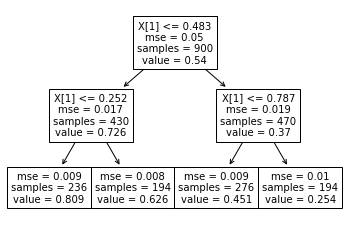

In [19]:
from sklearn import tree
tree.plot_tree(model)

In [20]:
# get the text representation
import numpy as np
print(regressor.tree_.value)
print(np.size(regressor.tree_.value))
float(regressor.tree_.value[0])

[[[0.54012918]]

 [[0.72640085]]

 [[0.80925365]]

 [[0.62561085]]

 [[0.36971042]]

 [[0.45134829]]

 [[0.25356582]]]
7


0.5401291804041537

In [21]:
# get the text representation
text_representation = tree.export_text(regressor)
print(text_representation)

|--- feature_1 <= 0.48
|   |--- feature_1 <= 0.25
|   |   |--- value: [0.81]
|   |--- feature_1 >  0.25
|   |   |--- value: [0.63]
|--- feature_1 >  0.48
|   |--- feature_1 <= 0.79
|   |   |--- value: [0.45]
|   |--- feature_1 >  0.79
|   |   |--- value: [0.25]



In [22]:
threshold = regressor.tree_.threshold
threshold_value = [threshold[0],threshold[1],threshold[4]]
print(threshold_value)

[0.48258817195892334, 0.25189508497714996, 0.7868755757808685]


In [23]:
regressor.tree_.feature

array([ 1,  1, -2, -2,  1, -2, -2], dtype=int64)

In [13]:
# get the values of leaves
index = [2,3,5,6]
leaf_value = []
t=1
# Put the leaf values into leaf_value list
for i in index:
    leaf_value.append(regressor.tree_.value[i])
    
X_0 = (1+0)/2
    
# Print the optimal value and corresponding optimal solutions
while t == True:
    if leaf_value[0] == max(leaf_value):
        print("The maximum value is: %.2f" % float(leaf_value[0]))
        print("The optimal X0 is: %.2f" % X_0)
        print("The optimal X1 is: %.2f" % (threshold_value[1]/2))
        break
    elif leaf_value[1] == max(leaf_value):
        print("The maximum value is: %.2f" % float(leaf_value[1]))
        print("The optimal X0 is: %.2f" % X_0)
        print("The optimal X1 is: %.2f" % (threshold_value[0]+threshold_value[1])/2)
        break
    elif leaf_value[2] == max(leaf_value):
        print("The maximum value is: %.2f" % float(leaf_value[2]))
        print("The optimal X0 is: %.2f" % X_0)
        print("The optimal X1 is: %.2f" % (threshold_value[0]+threshold_value[2])/2)
        break
    else:  
        print("The maximum value is: %.2f" % float(leaf_value[3][1]))
        print("The optimal X0 is: %.2f" % X_0)
        print("The optimal X1 is: %.2f" % (threshold_value[2]+1)/2)
        break
        
    
#regressor.tree_.value[2],regressor.tree_.value[3],regressor.tree_.value[5],regressor.tree_.value[6]
#float(regressor.tree_.value[2])


The maximum value is: 0.81
The optimal X0 is: 0.50
The optimal X1 is: 0.13


In [17]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

In [18]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 3] <= 0.800000011920929 else to node 2.
	node=1 is a leaf node.
	node=2 is a split node: go to node 3 if X[:, 2] <= 4.950000047683716 else to node 4.
		node=3 is a leaf node.
		node=4 is a leaf node.


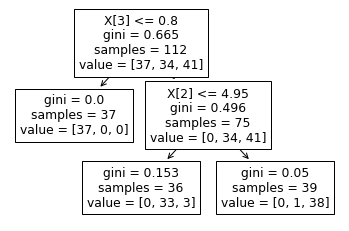

In [19]:
tree.plot_tree(clf)
plt.show()

In [20]:
clf.tree_.feature

array([ 3, -2,  2, -2, -2], dtype=int64)